In [1]:
import sys
#print(sys.path)
sys.path.insert(0, '/eos/user/j/jejarosl/.local/lib/python3.9/site-packages')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

The scikit-learn version is 1.2.0.
Python version
3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]
Version info.
sys.version_info(major=3, minor=9, micro=12, releaselevel='final', serial=0)


In [2]:
from utils import *

import awkward as ak
import glob
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import torch_geometric as pyg
from sklearn.manifold import TSNE
from sklearn import metrics

import torch_geometric.transforms as T
from torch_geometric.data import Data
import torch_geometric.utils as Utils
from tqdm import tqdm

import mplhep as hep
import glob
import argparse
import importlib.util

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import class_likelihood_ratios, precision_recall_fscore_support


%matplotlib inline
from matplotlib import rc
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

2024-03-06 11:26:58.508073: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 11:26:58.602710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, balanced_accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle
import argparse
import mplhep as hep
import importlib.util

#plt.style.use(hep.style.CMS)
"""Testing of the trained models."""


def get_model_prediction(model, testLoader, prepare_network_input_data=None, 
                         device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Gets model predictions on test edges.
    model: the trained network.
    testLoader: DataLoader of already pre-processed data.
    """
    
    model.to(device)
    predictions, truth = [], []
    
    for sample in tqdm(testLoader, desc="Getting model predictions"):
        sample = sample.to(device)
        
        if prepare_network_input_data is not None:
            inputs = prepare_network_input_data(sample.x, sample.edge_index)
        else:
            inputs = (sample.x, sample.edge_index)
            
        link_pred, emb = model(*inputs)
        predictions.append(link_pred.cpu().detach().numpy())
        truth.append(sample.edge_label.cpu().detach().numpy())
    return truth, predictions

def evaluate_clusters(dataset, predictions=None, thr=None, geometric=False, numevents=1000, PU=False):
    """
    Calculates homogenity, completeness, v-measure, adjusted random index and mutual info of the clustering.
    Predictions are the list of lists containing network scores for edges.
    """
    hom, compl, vmeas, randind, mutinfo = [], [], [], [], []
    
    for i in tqdm(range(numevents)):
        event = dataset[i]
        if not geometric:
            components, predicted_cluster_ids = find_connected_components(event, predictions[i], edge_index=None, thr=thr, PU=PU)
        else:
            predicted_cluster_ids = event.candidate_match.cpu().detach().numpy()
            
        t_match = event.best_simTs_match.cpu().detach().numpy()
        
        hom.append(metrics.homogeneity_score(t_match, predicted_cluster_ids))
        compl.append(metrics.completeness_score(t_match, predicted_cluster_ids))
        vmeas.append(metrics.v_measure_score(t_match, predicted_cluster_ids))
        randind.append(metrics.adjusted_rand_score(t_match, predicted_cluster_ids))
        mutinfo.append(metrics.adjusted_mutual_info_score(t_match, predicted_cluster_ids))
    
    return hom, compl, vmeas, randind, mutinfo

def classification_thresholds_plot(scores, ground_truth, threshold_step=0.05, output_folder=None, epoch=None):
    """
    Plots and saves the figure of the dependancy of th eaccuracy, True Positive rate (TPR) and 
    True Negative rate (TNR) on the value of the classification threshold.
    """    
    thresholds = np.arange(0, 1 + threshold_step, threshold_step)
    ACC, TNR, TPR, F1 = [], [], [], []
    for threshold in thresholds:
        
        prediction = scores > threshold
        
        TN, FP, FN, TP = confusion_matrix(ground_truth, prediction).ravel()
        ACC.append((TP+TN)/(TN + FP + FN + TP))
        TNR.append(TN/(TN+FP))
        TPR.append(TP/(TP+FN))
        F1.append(f1_score(ground_truth, prediction))
    
    # Saving the figure of the classification threshold plot
    fig = plt.figure(figsize=(9,6))
    plt.plot(thresholds, ACC, 'go-', label='ACC', linewidth=2)
    plt.plot(thresholds, TNR, 'bo-', label='TNR', linewidth=2)
    plt.plot(thresholds, TPR, 'ro-', label='TPR', linewidth=2)
    plt.plot(thresholds, F1, 'mo-', label='F1', linewidth=2)
    plt.xlabel("Threshold", fontsize=15)
    plt.title("Accuracy / TPR / TNR / F1 based on the classification threshold value", fontsize=16)
    plt.legend()
    
    if output_folder is not None:
        f_name = f"classification_thresholds_epoch_{epoch}.png" if epoch is not None else "classification_thresholds.png"
        plt.savefig(f"{output_folder}/{f_name}", dpi=300, bbox_inches='tight', transparent=True)
        plt.show()
       
    return TNR, TPR, thresholds

def get_best_threshold(TNR, TPR, thresholds, epsilon = 0.02, default=0.65):
    # Find the threshold for which TNR and TPR intersect

    for i in range(len(thresholds)-1):
        if abs(TNR[i] - TPR[i]) < epsilon:
            return round(thresholds[i], 3)
    
        if TNR[i] - TPR[i] < 0 and TNR[i+1] - TPR[i+1] >= epsilon:
            return round(0.5*(thresholds[i] + thresholds[i+1]), 3)
    print("Chosen a default threshold...")
    return default

def test(truth, scores, classification_threshold = 0.7, output_folder=None, epoch=None):
    
    results = {}
    print(scores)
    predictions = scores > classification_threshold    
    sample_weight = compute_sample_weight(class_weight='balanced', y=truth)
    
    cf_matrix = confusion_matrix(truth, predictions)
    print(f"Confusion matrix:\n{cf_matrix}\n")
    
    cf_matrix_w_norm = confusion_matrix(truth, predictions, sample_weight=sample_weight, normalize='all')
    print(f"Confusion matrix weighted:\n{cf_matrix_w_norm}\n")
    
    TN, FP, FN, TP = cf_matrix.ravel()
    print(f"TN: {TN} \t FN: {FN} \t TP: {TP} \t FP: {FP}")
    results["F1"] = f1_score(truth, predictions)
    results["BA"] = balanced_accuracy_score(truth, predictions)
    
    # Sensitivity, hit rate, recall, or true positive rate
    results["TPR"] = TP/(TP+FN)
    # Specificity or true negative rate
    results["TNR"] = TN/(TN+FP) 
    # Precision or positive predictive value
    results["PPV"] = TP/(TP+FP)
    # Negative predictive value
    results["NPV"] = TN/(TN+FN)
    # Fall out or false positive rate
    results["FPR"] = FP/(FP+TN)
    # False negative rate
    results["FNR"] = FN/(TP+FN)
    # False discovery rate
    results["FDR"] = FP/(TP+FP)
    
    tot = TN + FP + FN + TP
    ACC = (TP+TN)/tot
    # normalized to total edges in test dataset
    print(f"Confusion matrix scaled:\n{cf_matrix/tot}\n")
    print(f"Accuracy: {ACC:.4f}")
    print(f"Precision: {results['PPV']:.4f}")
    print(f"Negative predictive value: {results['NPV']:.4f}")
    print(f"Recall: Correctly classifying {results['TPR']*100:.4f} % of positive edges")
    print(f"True negative rate: Correctly classifying {results['TNR']*100:.4f} % of all negative edges")
    print(f"F1 score: {results['F1']:.4f}")
    
    prec_w, rec_w, fscore_w, _ = precision_recall_fscore_support(truth, predictions, sample_weight=sample_weight)
    print(prec_w, rec_w, fscore_w)
    print(f"Balanced accuracy: {results['BA']:.4f}")
    print(f"Precision weighted: {prec_w}")
    print(f"Recall weighted: {rec_w}")
    print(f"F1 score weighted: {fscore_w}")
    
    # computes the positive and negative likelihood ratios (LR+, LR-) to assess the predictive 
    # power of a binary classifier. As we will see, these metrics are independent of the proportion between
    #classes in the test set, which makes
    #them very useful when the available data for a study has a different class proportion than the target application.
    pos_lr, neg_lr = class_likelihood_ratios(truth, predictions, raise_warning=False)
    print(f"positive_likelihood_ratio: {pos_lr}, negative_likelihood_ratio: {neg_lr}")

    max_el = max(np.amax(cf_matrix/tot), np.amax(cf_matrix_w_norm))
    
    # plot confusion matrix
    fig, px = plt.subplots(1, 2, figsize=(8, 4))
    plt.set_cmap("viridis")
    px[0].set_xlabel("Predicted")
    px[0].set_ylabel("True")
    cax = px[0].matshow(cf_matrix/tot)
    
    px[0].set_title(f"(ACC: {ACC:.4f}, TPR: {results['TPR']:.4f}, TNR: {results['TNR']:.4f})\nThreshold: {classification_threshold}",
              fontsize=14)

    px[1].set_xlabel("Predicted")
    px[1].set_ylabel("True")
    cax = px[1].matshow(cf_matrix_w_norm)
    px[1].set_title(f"(BA: {results['BA']:.4f}, TPR: {results['TPR']:.4f}, TNR: {results['TNR']:.4f})\n Threshold: {classification_threshold}",
              fontsize=14)
    #fig.colorbar(cax)
    
    results["TN"], results["FP"], results["FN"], results["TP"] = TN, FP, FN, TP
    results["ACC"] = ACC
    results["cf_matrix"] = cf_matrix
    # Scores output by the neural network without classification
    results["scores"] = scores
    results["prediction"] = predictions
    results["ground_truth"] = truth
    results["classification_threshold"] = classification_threshold
    
    if output_folder is not None:
        f_name = f"confusion_matrix_epoch_{epoch}.png" if epoch is not None else "confusion_matrix_epoch.png"
        plt.savefig(f"{output_folder}/{f_name}", dpi=300, bbox_inches='tight', transparent=True)
        
        pkl_name = f"test_results_{epoch}.pkl" if epoch is not None else "test_results.pkl"
        with open(f'{output_folder}/{pkl_name}','wb') as f:
            pickle.dump(results, f)
    plt.show()
    #----------------------------------
            
    fpr, tpr, _ = roc_curve(truth, scores)
    results["ROC_AUC"] = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % results["ROC_AUC"])
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=18)
    plt.ylabel("True Positive Rate", fontsize=18)
    plt.title("Receiver operating characteristic", fontsize=24)
    plt.legend(loc="lower right")
    
    if output_folder is not None:
        roc_name = f"roc_{epoch}.png" if epoch is not None else "roc.png"
        plt.savefig(f"{output_folder}/{roc_name}", dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
            
    return results   

def getAccuracy(y_true, y_prob, classification_threshold):
    # TODO: make this a vector function
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > classification_threshold
    return (y_true == y_prob).sum().item() / y_true.size(0)

def load_model_for_testing(modelFolder):
    
    modelPath = f"{modelFolder}/model.pt"
    model_architecture_file = f"{modelFolder}/architecture.py"
    
    # Loading the model file
    print(">>> Loading model from the provided path...")
    spec = importlib.util.spec_from_file_location("model", model_architecture_file)
    model_lib = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_lib)
    model = model_lib.TracksterLinkingNet()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(modelPath, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Model epoch: {checkpoint['epoch']}")
    print(">>> Model Loaded.")
    prepare_network_input_data = None
    try:
        prepare_network_input_data = model_lib.prepare_network_input_data
    except Exception as ex:
        print(ex)
    return model, prepare_network_input_data

def plotLoss(model_base_folder):
    plt.style.use(hep.style.CMS)
    #plt.style.use('seaborn-whitegrid')
    train_loss_path = model_base_folder + "/loss/train_loss_history.pkl"
    val_loss_path = model_base_folder + "/loss/val_loss_history.pkl"
    
    with open(train_loss_path, 'rb') as f:
        train_loss = pickle.load(f)
    with open(val_loss_path, 'rb') as f:
        val_loss = pickle.load(f)
        
    fig = plt.figure(figsize=(10, 8))
    plt.style.use('seaborn-whitegrid')
    plt.plot(range(1, len(train_loss)+1), train_loss, label='train', linewidth=2)
    plt.plot(range(1, len(val_loss)+1), val_loss, label='val', linewidth=2)
    plt.ylabel("Loss", fontsize=22)
    plt.xlabel("Epochs", fontsize=22)
    plt.title("Training and Validation Loss", fontsize=24)
    plt.legend()
    plt.show()
    #plt.savefig(f"{model_base_folder}/loss/losses.png")
    
    
def truth_pairs(data_list, ev, thr):
    data_ev = prepare_test_data(data_list, ev)
    truth_edge_index = data_ev.edge_index
    truth_edge_label = data_ev.edge_label > thr
    truth_nodes_features = data_ev.x
    
    src_edge_index_true = truth_edge_index[0][truth_edge_label]
    dest_edge_index_true = truth_edge_index[1][truth_edge_label]
    edge_scores_Ereco = data_ev.edge_score_Ereco[truth_edge_label]

    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i].item(), dest_edge_index_true[i].item()])
    return truth_nodes_features, index_tuple, edge_scores_Ereco

def prediction_pairs(model, data_list, ev, thr, prepare_network_input_data=None, return_net_out=False, device=False, edge_features=False):
    data_ev = prepare_test_data(data_list, ev)
    if prepare_network_input_data is not None:
        if edge_features:
            if data_ev.edge_index.shape[1] != data_ev.edge_features.shape[0]:
                print("ERROR: edge index shape is different from edge features shape")
                return 0
            inputs = prepare_network_input_data(data_ev.x, data_ev.edge_index, data_ev.edge_features,
                                            device='cuda:0' if next(model.parameters()).is_cuda else 'cpu')
            
        else:
            inputs = prepare_network_input_data(data_ev.x, data_ev.edge_index, 
                                            device='cuda:0' if next(model.parameters()).is_cuda else 'cpu')
    else:
        inputs = (data_ev.x, data_ev.edge_index)
        
    if device:
        out, emb = model(*inputs, device='cuda:0' if next(model.parameters()).is_cuda else 'cpu')
    else: 
        out, emb = model(*inputs)
    edge_index = data_ev.edge_index
    truth_edge_label = out > thr
    node_features = data_ev.x
    
    src_edge_index_true = edge_index[0][truth_edge_label]
    dest_edge_index_true = edge_index[1][truth_edge_label]
    edge_scores_Ereco = data_ev.edge_score_Ereco[truth_edge_label]
    
    index_tuple = []
    for i in range(len(src_edge_index_true)):
        index_tuple.append([src_edge_index_true[i].item(), dest_edge_index_true[i].item()])

    if return_net_out:
        return node_features, index_tuple, edge_scores_Ereco, out
    
    return node_features, index_tuple, edge_scores_Ereco

def connectivity_matrix(model, data_list, ev, thr, similarity=True, prepare_network_input_data=None):
    data_ev = prepare_test_data(data_list, ev)
    
    if prepare_network_input_data is not None:
        inputs = prepare_network_input_data(data_ev.x, data_ev.edge_index, 
                                            device='cuda:0' if next(model.parameters()).is_cuda else 'cpu')
    else:
        inputs = data_ev.x, data_ev.edge_index
    out, emb = model(*inputs)
    N = data_ev.num_nodes
    mat = np.zeros([N, N])
    truth_mat = np.zeros([N, N])
    for indx, src in enumerate(data_ev.edge_index[0]):
        dest = data_ev.edge_index[1][indx]
        mat[src][dest] = out[indx]
        mat[dest][src] = out[indx]
        truth_mat[src][dest] = data_ev.edge_label[indx]
        truth_mat[dest][src] = data_ev.edge_label[indx]
        
    if similarity == False:
        mat = mat > thr
    return mat, truth_mat


def plot_prediction_distribution(model, test_dl, threshold=0.7):
    for sample in test_dl:
        sample = sample.to(device)
        pred, emb = model(sample.x, sample.edge_index)
        targets = sample.edge_label
        break
    
    pred = pred.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    fig, axs = plt.subplots(3, figsize=(5, 8))
    fig.suptitle('Distributions of the labels')
    axs[0].set_title('Prediction distribution')
    axs[0].hist(pred, bins=20)
    axs[1].hist(targets, bins=20)
    axs[1].set_title('True Edge Labels')
    thresholded = (np.array(pred) > thr).astype(int)

    axs[2].set_title(f'Predicted Edge Labels for thr: {thr}')
    axs[2].hist(thresholded, bins=20)

    print(f"Edge labels: number of positive: {targets.sum()}")
    print(f"Predictions: number of positive: {thresholded.sum()}")

    plt.tight_layout()
    # hep.cms.text('Preliminary')
    plt.show()

def get_truth_labels(data_list, ev):
    """list of indices of best matched simts to all ts in an event"""
    x_best_simts = data_list[ev][5]
    return x_best_simts
 
def get_cand_labels(data_list, ev):
    """candidates containing the trackster"""
    cand_match = data_list[ev][6]
    return cand_match

In [4]:
# Training

"""
Training of the networks for trackster linking.
"""


GPU_index = 0
print(f"Torch version: {torch.__version__}")
print("Device {}".format(torch.cuda.get_device_name()))
use_cuda = torch.cuda.is_available()
device = torch.device(f'cuda:{GPU_index}' if use_cuda else 'cpu')
if use_cuda:
    print('>>> CUDNN VERSION:', torch.backends.cudnn.version())
    print('>>> Number CUDA Devices:', torch.cuda.device_count())
    print('>>> CUDA Device Name:', torch.cuda.get_device_name(GPU_index))
    print('>>> CUDA Device Total Memory [GB]:', torch.cuda.get_device_properties(GPU_index).total_memory/1e9)

  
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.4):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, predictions, targets):        
        """Binary focal loss, mean.

        Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with
        improvements for alpha.
        :param bce_loss: Binary Cross Entropy loss, a torch tensor.
        :param targets: a torch tensor containing the ground truth, 0s and 1s.
        :param gamma: focal loss power parameter, a float scalar.
        :param alpha: weight of the class indicated by 1, a float scalar.
        """
        bce_loss = F.binary_cross_entropy(predictions, targets)
        p_t = torch.exp(-bce_loss)
        alpha_tensor = (1 - self.alpha) + targets * (2 * self.alpha - 1)  
        # alpha if target = 1 and 1 - alpha if target = 0
        f_loss = alpha_tensor * (1 - p_t) ** self.gamma * bce_loss
        return f_loss.mean()
    
def get_unique_run(models_path):
    """
    Prepare the output folder run id.
    """
    previous_runs = os.listdir(models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number

def train_val(model, trainLoader, valLoader, optimizer, loss_function, epochs, outputModelPath,
              scheduler=None, with_scores=False, update_every=1, save_checkpoint_every=1):
    """
    Performs training and validation of the network for a required number of epochs.
    """    
    outputModelCheckpointPath = outputModelPath + "/checkpoints/"
    outputLossFunctionPath = outputModelPath + "/loss/"
    outputTrainingPlotsPath = outputModelPath + "/trainingPlots/"
    
    # Create directories for saving the models/checkpoints if not exist
    mkdir_p(outputModelPath)
    mkdir_p(outputModelCheckpointPath)
    mkdir_p(outputLossFunctionPath)
    mkdir_p(outputTrainingPlotsPath)
    
    train_loss_history = []
    val_loss_history = []

    print(f"Model output directory: {outputModelPath}")
    print(f"Saving checkpoints every {save_checkpoint_every} epochs.")
    
    print(">>> Model training started.")
    model.to(device)
    
    for epoch in range(epochs):
        batchloss = []
        train_true_seg, train_pred_seg, scores_seg = [], [], []
        b = 0
        num_samples = len(trainLoader)
        optimizer.zero_grad()
                
        # Training ----------------------------------------------------
        model.train()
        for sample in tqdm(trainLoader, desc=f'Training epoch {epoch+1}'):
            sample.to(device)
            
            num_tracksters, feat_dim = sample.x.shape
            if num_tracksters <= 1:
                continue
        
            inputs = prepare_network_input_data(sample.x, sample.edge_index)
            out, emb = model(*inputs)
            if not with_scores:
                loss = loss_function(out, sample.edge_label.to(torch.float32))
            else:
                loss = loss_function(out, sample.edge_score_Ereco)
            batchloss.append(loss.item())
            loss.backward()
            
            if (b+1) % update_every == 0 or (b+1) == num_samples:
                optimizer.step()
                optimizer.zero_grad()
            
            b += 1
            
            seg_np = sample.edge_label.cpu().numpy()
            scores = sample.edge_score_Ereco.cpu().numpy()
            pred_np = out.detach().cpu().numpy()

            train_true_seg.append(seg_np.reshape(-1))
            train_pred_seg.append(pred_np.reshape(-1))
            scores_seg.append(scores.reshape(-1))

        train_true_cls = np.concatenate(train_true_seg)
        train_pred_cls = np.concatenate(train_pred_seg)
        scores_cls = np.concatenate(scores_seg)
        
        plot_prediction_distribution_standard_and_log(train_pred_cls, train_true_cls,
                                                      epoch=epoch+1, thr = 0.65, scores=scores_cls,
                                                      folder=outputTrainingPlotsPath)

        train_loss = np.mean(batchloss)
        
        if hasattr(model, 'writer'):
            model.writer.add_scalar("Loss/train", train_loss, epoch)
            model.writer.flush()
            
        train_loss_history.append(train_loss)
        # End Training ----------------------------------------------------
            
        # Validation ------------------------------------------------------
        val_true_seg, val_pred_seg = [], []
        
        with torch.set_grad_enabled(False):
            batchloss = []
            model.eval()
            for sample in tqdm(valLoader, desc=f'Validation epoch {epoch+1}'):
                sample.to(device)
                
                num_tracksters, feat_dim = sample.x.shape
                if num_tracksters <= 1:
                    continue
                
                inputs = prepare_network_input_data(sample.x, sample.edge_index)
                out, emb = model(*inputs)
                if not with_scores:
                    val_loss = loss_function(out, sample.edge_label.to(torch.float32))
                else:
                    val_loss = loss_function(out, sample.edge_score_Ereco)
                
                batchloss.append(val_loss.item())
                
                seg_np = sample.edge_label.cpu().numpy()
                pred_np = out.detach().cpu().numpy()

                val_true_seg.append(seg_np.reshape(-1))
                val_pred_seg.append(pred_np.reshape(-1))

        val_true_cls = np.concatenate(val_true_seg)
        val_pred_cls = np.concatenate(val_pred_seg)        
                
        print("Testing model on validation data...")
        TNR, TPR, thresholds = classification_thresholds_plot(val_pred_cls, val_true_cls, threshold_step=0.05,
                                       output_folder=outputTrainingPlotsPath, epoch=epoch+1)
        classification_threshold = get_best_threshold(TNR, TPR, thresholds)
        print(f"Chosen classification threshold is: {classification_threshold}")
        
        plot_prediction_distribution_standard_and_log(val_pred_cls, val_true_cls,
                                                      epoch=epoch+1, thr = classification_threshold,
                                                     folder=outputTrainingPlotsPath, val=True)
        
        test_results = test(val_true_cls, val_pred_cls, classification_threshold=classification_threshold,
                            output_folder=outputTrainingPlotsPath, epoch=epoch+1)

        val_loss = np.mean(batchloss)
        
        if hasattr(model, 'writer'):
            model.writer.add_scalar("Loss/val", val_loss, epoch)
            model.writer.flush()
        val_loss_history.append(val_loss)
        # End Validation ----------------------------------------------------
        
        # Save checkpoint every 'save_checkpoint_every' epochs
        if(epoch != 0 and epoch != epochs-1 and (epoch+1) % save_checkpoint_every == 0):
            print("Saving a model checkpoint.")
            torch.save({
                        'epoch': epoch+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': train_loss_history,
                        }, outputModelCheckpointPath + f"/epoch_{epoch+1}_val_loss{val_loss:.6f}.pt")
        
        if scheduler is not None:
            scheduler.step(val_loss_history[-1])
            for param_group in optimizer.param_groups:
                print(f"lr: {param_group['lr']}")
            
        print(f"epoch {epoch+1}: Train loss: {train_loss_history[-1]} \t Val loss: {val_loss_history[-1]}")
        
        # Save the updated picture and pkl files of the losses 
        save_loss(train_loss_history, val_loss_history, outputLossFunctionPath)

    # Save the final model
    print(f">>> Training finished. Saving model to {outputModelPath + '/model.pt'}")
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss_history,
                }, outputModelPath + "/model.pt")
    
    if hasattr(model, 'writer'):
        model.writer.close()
        
    return train_loss_history, val_loss_history

def save_loss(train_loss_history, val_loss_history, outputLossFunctionPath):
    # Saving the figure of the training and validation loss
    fig = plt.figure(figsize=(9, 5))
    #plt.style.use('seaborn-whitegrid')
    epochs = len(train_loss_history)
    plt.plot(range(1, epochs+1), train_loss_history, label='train', linewidth=2)
    plt.plot(range(1, epochs+1), val_loss_history, label='val', linewidth=2)
    plt.ylabel("Loss", fontsize=16)
    plt.xlabel("Epochs", fontsize=16)
    plt.title("Training and Validation Loss", fontsize=18)
    plt.legend()
    plt.savefig(f"{outputLossFunctionPath}/losses.png")
    plt.show()
    
    # Save the train and validation loss histories to pkl files
    with open(outputLossFunctionPath + 'train_loss_history.pkl','wb') as f:
        pickle.dump(train_loss_history, f)

    with open(outputLossFunctionPath + 'val_loss_history.pkl','wb') as f:
        pickle.dump(val_loss_history, f)

def print_training_dataset_statistics(trainDataset):
    print(f"Number of events in training dataset: {len(trainDataset)}")
    num_nodes, num_edges, num_neg, num_pos = 0, 0, 0, 0
    for ev in trainDataset:
        num_nodes += ev.num_nodes
        num_edges += len(ev.edge_label)
        num_pos += (ev.edge_label == 1).sum()
        num_neg += (ev.edge_label == 0).sum()
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Number of positive edges: {num_pos}")
    print(f"Number of negative edges: {num_neg}")


def plot_prediction_distribution_standard_and_log(pred, targets, epoch=None, thr = 0.65, scores=None, folder=None, val=False):
    
    fig = plt.figure(figsize=(10,9))
    #plt.style.use('seaborn-whitegrid')

    fig.suptitle(f'Distributions of the labels (Epoch: {epoch})')
    
    num_plots = 4 if scores is not None else 3
    
    # Predictions in linear and log scales
    ax1 = fig.add_subplot(num_plots,2,1)
    ax1.set_title('Prediction distribution')
    ax1.hist(pred, bins=30)
    
    ax2 = fig.add_subplot(num_plots,2,2)
    ax2.set_title('Prediction distribution Log')
    ax2.hist(pred, bins=30)
    ax2.set_yscale('log')
    #------------------------
    
    # Truth labels in linear and log scales
    ax3 = fig.add_subplot(num_plots,2,3)
    ax3.hist(targets, bins=30)
    ax3.set_title('True Edge Labels')
    thresholded = (np.array(pred) > thr).astype(int)
    
    ax4 = fig.add_subplot(num_plots,2,4)
    ax4.hist(targets, bins=30)
    ax4.set_title('True Edge Labels Log')
    ax4.set_yscale('log')
    #------------------------

    # Thresholded labels in linear and log scales
    ax5 = fig.add_subplot(num_plots,2,5)
    ax5.set_title(f'Predicted Edge Labels for thr: {thr}')
    ax5.hist(thresholded, bins=30)
    
    ax6 = fig.add_subplot(num_plots,2,6)
    ax6.set_title(f'Predicted Edge Labels Log for thr: {thr}')
    ax6.hist(thresholded, bins=30)
    ax6.set_yscale('log')
    #------------------------
    
    if scores is not None:
        ax7 = fig.add_subplot(num_plots,2,7)
        ax7.set_title('Edge Scores')
        ax7.hist(scores, bins=30)
        
        ax8 = fig.add_subplot(num_plots,2,8)
        ax8.set_title('Edge Scores Log')
        ax8.hist(scores, bins=30)
        ax8.set_yscale('log')

    print(f"Edge labels: number of positive: {targets.sum()}")
    print(f"Predictions: number of positive: {thresholded.sum()}")

    plt.xlim([0, 1])
    plt.tight_layout()
    if folder is not None:
        name = f"plot_train_prediction_distribution_epoch_{epoch}.png" if val else f"plot_val_prediction_distribution_epoch_{epoch}.png"
        plt.savefig(f'{folder}/{name}', bbox_inches='tight')
    plt.show()

Torch version: 2.1.0a0
Device Tesla T4
>>> CUDNN VERSION: 8600
>>> Number CUDA Devices: 1
>>> CUDA Device Name: Tesla T4
>>> CUDA Device Total Memory [GB]: 15.835398144


In [5]:
# Load the dataset
dataset_location = "./vertexing_dataset/"

print(">>> Loading datasets...")
trainDataset = torch.load(f"{dataset_location}/dataTraining.pt")
valDataset = torch.load(f"{dataset_location}/dataVal.pt")
testList = torch.load(f"{dataset_location}/dataTest.pt")

testDataset = []

for ev in tqdm(range(len(testList))):
    data = prepare_test_data(testList, ev)
    testDataset.append(data)
print(">>> Loaded.")

>>> Loading datasets...


100%|██████████| 22/22 [00:00<00:00, 4243.49it/s]

>>> Loaded.


In [6]:
trainDataset[0]

Data(x=[2795, 19], edge_index=[2, 197628], num_nodes=2795, edge_label=[197628], edge_features=[197628, 12], e_PIDs=[2795], e_times=[2795])

# GNN Model & Tuning

In [7]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.utils import scatter

def batch_sum(x, batch):
    size = int(batch.max().item() + 1)
    return scatter(x, batch, dim=0, dim_size=size, reduce='sum')

class QualityFocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(QualityFocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, predictions, targets):
        bce_loss = F.binary_cross_entropy_with_logits(predictions, targets, reduction='none')
        modulator = (targets - predictions) ** self.gamma
        return (modulator * bce_loss).sum()


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.4):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
 
    def forward(self, predictions, targets):        
        """Binary focal loss, mean.

        Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with
        improvements for alpha.
        :param bce_loss: Binary Cross Entropy loss, a torch tensor.
        :param targets: a torch tensor containing the ground truth, 0s and 1s.
        :param gamma: focal loss power parameter, a float scalar.
        :param alpha: weight of the class indicated by 1, a float scalar.
        """
        bce_loss = F.binary_cross_entropy(predictions, targets)
        p_t = torch.exp(-bce_loss)
        alpha_tensor = (1 - self.alpha) + targets * (2 * self.alpha - 1)  
        # alpha if target = 1 and 1 - alpha if target = 0
        f_loss = alpha_tensor * (1 - p_t) ** self.gamma * bce_loss
        return f_loss.mean()

In [9]:
def train(model, opt, loader, epoch, device="cuda", edge_features=True, emb_out=False):

    epoch_loss = 0
    model.train()
    j = 0
    for sample in tqdm(loader, desc=f"Training epoch {epoch}"):
        # reset optimizer and enable training mode
        opt.zero_grad()

        # move data to the device
        sample = sample.to(device)

        # get the prediction tensor
        if edge_features:
            if sample.edge_index.shape[1] != sample.edge_features.shape[0]:
                continue
            data = prepare_network_input_data(sample.x, sample.edge_index, sample.edge_features, device=device)
        else:
            data = prepare_network_input_data(sample.x, sample.edge_index, device=device)
        if emb_out:
            z, emb = model(*data, device)   
        else:
            z = model(*data, device)

        # compute the loss
        loss = loss_obj(z, sample.edge_label.float())
   
        # back-propagate and update the weight
        loss.backward()
        opt.step()
        epoch_loss += loss
        j+=1

    return float(epoch_loss)/j

@torch.no_grad()
def test_simple(model, data, device="cuda", edge_features=False):
    total = 0
    correct = 0
    model.eval()
    for sample in tqdm(data, desc="Testing"):
        sample = sample.to(device)
        if edge_features:
            if sample.edge_index.shape[1] != sample.edge_features.shape[0]:
                continue
            data = prepare_network_input_data(sample.x, sample.edge_index, sample.edge_features, device=device)
        else:
            data = prepare_network_input_data(sample.x, sample.edge_index, device=device)
        z, emb = model(*data, device) 
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == sample.edge_label.type(torch.int))
    return (correct / total)

In [10]:
train_dl = DataLoader(trainDataset[:20], batch_size=1, shuffle=True)
val_dl = DataLoader(valDataset[:5], batch_size=1, shuffle=True)

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

def prepare_network_input_data(X, edge_index, edge_features, device=None):
    X = torch.nan_to_num(X, nan=0.0)    
    edge_features = torch.nan_to_num(edge_features, nan=0.0)
    return torch.unsqueeze(X, dim=0), torch.unsqueeze(edge_index, dim=0).float(), torch.unsqueeze(edge_features, dim=0).float()


class EdgeConvBlock(nn.Module):
    """EdgeConv layer.
    .. math::
       x_i^{(l+1)} = \max_{j \in \mathcal{N}(i)} \mathrm{ReLU}(
       \Theta \cdot (x_j^{(l)} - x_i^{(l)}) + \Phi \cdot x_i^{(l)})
    where :math:`\mathcal{N}(i)` is the neighbor of :math:`i`.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    """

    def __init__(self, in_feat, out_feats, activation=True, dropout=0.2, weighted_aggr=False):
        super(EdgeConvBlock, self).__init__()
        self.activation = activation
        self.num_layers = len(out_feats)
        self.weighted_aggr = weighted_aggr
        
        self.drop = nn.Dropout(dropout)

        self.convs = nn.ModuleList()
        for i in range(self.num_layers):
            self.convs.append(nn.Linear(2 * in_feat if i == 0 else out_feats[i - 1], out_feats[i]))

        self.acts = nn.ModuleList()
        for i in range(self.num_layers):
            self.acts.append(nn.ReLU())

        if in_feat == out_feats[-1]:
            self.sc = None
        else:
            self.sc = nn.Linear(in_feat, out_feats[-1])

        if activation:
            self.sc_act = nn.ReLU()

    def forward(self, features, ind_p1, ind_p2, alpha=None, device='cpu'):
        
        EDGE_EMB_p1 = features[ind_p1, :]
        EDGE_EMB_p2 = features[ind_p2, :] - EDGE_EMB_p1
        x = torch.cat((EDGE_EMB_p1, EDGE_EMB_p2), dim=1)
        N = features.shape[0]
        i = 0
        for conv, act in zip(self.convs, self.acts):
            
            x = conv(x) 
            if self.activation:
                x = act(x)
            if i == 0:
                x = self.drop(x)
            i += 1

        # Do aggregation
        if self.weighted_aggr and alpha is not None:
            
            alpha_vec = torch.cat((torch.ones(N, device=device, dtype=float).float(), torch.squeeze(alpha)), dim=0)
            
            x = torch.mul(alpha_vec, x.transpose(0, 1)).transpose(0, 1)
            
        # Create a destination tensor to store the summed rows
        summed_matrix = torch.zeros(N, x.size(1), device=device).float()
        # Sum the rows based on the index using torch.scatter_add
        x = torch.scatter_add(summed_matrix, 0, ind_p1.unsqueeze(1).repeat(1, x.size(1)), x)
        
        # Skip connection:
        if self.sc:
            sc = self.sc(features)
        else:
            sc = features
        out = self.sc_act(sc + x)

        return out
    
    
class GNN_TrackLinkingNet(nn.Module):
    
    def __init__(self, input_dim=19, hidden_dim=16, output_dim=1, niters=2, dropout=0.2,
                 edge_feature_dim=12, edge_hidden_dim=16, weighted_aggr=True):
        super(GNN_TrackLinkingNet, self).__init__()
        
        self.writer = SummaryWriter(f"tensorboard_runs/gnn_model_no_geometric")
        
        self.niters = niters
        self.input_dim = input_dim
        self.edge_feature_dim = edge_feature_dim
        self.weighted_aggr = weighted_aggr
        
        # Feature transformation to latent space
        self.inputnetwork = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU()
        )
        
        # Edge Feature transformation to latent space
        self.edge_inputnetwork = nn.Sequential(
            nn.Linear(edge_feature_dim, edge_hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(edge_hidden_dim, edge_hidden_dim),
            nn.LeakyReLU()
        )
        
        self.attention_direct = nn.Sequential(
            nn.Linear(edge_hidden_dim, edge_hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(edge_hidden_dim, 1),
            nn.Sigmoid()
        )
        
        self.attention_reverse = nn.Sequential(
            nn.Linear(edge_hidden_dim, edge_hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(edge_hidden_dim, 1),
            nn.Sigmoid()
        )
        
        # EdgeConv
        self.graphconvs = nn.ModuleList()
        for i in range(niters):
            self.graphconvs.append(EdgeConvBlock(in_feat=hidden_dim, 
                                                 out_feats=[2*hidden_dim, hidden_dim], dropout=dropout,
                                                 weighted_aggr=weighted_aggr))
        
        # Edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_feature_dim + edge_hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
    
    def forward(self, X, edge_index, edge_features, device="cpu", return_emb=False):
        
        X = torch.squeeze(X, dim=0)
        N = X.shape[0]

        X_norm = torch.zeros_like(X)
        
        epsilon = 10e-5 * torch.ones(X.shape, device=device)
        std = X.std(dim=0, unbiased=False) + epsilon
        X_norm = (X - X.mean(dim=0)) / std           
        
        edge_features = torch.squeeze(edge_features, dim=0)
        edge_features_norm = torch.zeros_like(edge_features)
        epsilon = 10e-5 * torch.ones(edge_features.shape, device=device)
        std = edge_features.std(dim=0, unbiased=False) + epsilon
        edge_features_norm = (edge_features - edge_features.mean(dim=0)) / std
        edge_features_NN = self.edge_inputnetwork(edge_features_norm)

        alpha_dir = self.attention_direct(edge_features_NN)
        alpha_rev = self.attention_reverse(edge_features_NN)
        alpha = torch.cat([alpha_dir, alpha_rev], dim=0).float()
        
        edge_index = torch.squeeze(edge_index, dim=0).long()
        E = edge_index.shape[1]
        src, dst = edge_index
        
        # Feature transformation to latent space
        node_emb = self.inputnetwork(X_norm)
        
        ind_p1 = torch.cat((torch.arange(0, N, dtype=int, device=device), src, dst))
        ind_p2 = torch.cat((torch.arange(0, N, dtype=int, device=device), dst, src))

        # Niters x EdgeConv block
        for graphconv in self.graphconvs:
            node_emb = graphconv(node_emb, ind_p1, ind_p2, alpha=alpha, device=device)
            
        edge_emb = torch.cat([node_emb[src], node_emb[dst], edge_features_NN, edge_features_norm], dim=-1)    
        pred = self.edgenetwork(edge_emb).squeeze(-1) 
        if not return_emb:
            return pred
        return pred, node_emb


In [12]:
def list_flatten(my_list):
    return [item for sublist in my_list for item in sublist]

def weight_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None: 
            m.bias.data.fill_(0.)

def save_pred(pred_flat, lab_flat, epoch=0, out_folder=None):
    
    true_pred = pred_flat[lab_flat==1] 
    false_pred = pred_flat[lab_flat!=1]

    bins = 100
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(121)
    ax1.hist(false_pred, bins=bins, density=1, label="False predictions", histtype='step')
    ax1.hist(true_pred, bins=bins, density=1, label="True predictions", histtype='step')
    ax1.legend(loc="upper center") #loc="upper left")
    #ax1.set_yscale('log')

    ax2 = fig.add_subplot(122)
    ax2.hist(pred_flat, bins=bins, label="All predictions")
    ax2.legend()

    ax1.set_title("True and False edge prediction distribtion", fontsize=15)
    ax1.set_xlabel("Predicted score", fontsize=14)
    ax1.set_ylabel('Probability [%]', fontsize=14)
    ax2.set_title("Edge prediction distribtion", fontsize=15)
    ax2.set_xlabel("Predicted score", fontsize=14)
    ax2.set_ylabel('Counts', fontsize=14)
    plt.show()

    if out_folder is not None:
        fig.savefig(f'{out_folder}/edge-pred-distributions-epoch-{epoch+1}.pdf', dpi=300, bbox_inches='tight', transparent=True)
        fig.savefig(f'{out_folder}/edge-pred-distributions-eppoch-{epoch+1}.png', dpi=300, bbox_inches='tight', transparent=True)

In [13]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [16]:
model = GNN_TrackLinkingNet(input_dim = trainDataset[0].x.shape[1], 
                                edge_feature_dim=trainDataset[0].edge_features.shape[1],
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True)
                               #dropout=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

epochs = 50
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)

loss_obj = FocalLoss()
model.apply(weight_init)

GNN_TrackLinkingNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=19, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (edge_inputnetwork): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (attention_direct): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (attention_reverse): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)

Training epoch 1: 100%|██████████| 20/20 [00:01<00:00, 17.35it/s]


Epoch: 1, train loss: 0.0435
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_1_loss_0.0435.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.08it/s]


Epoch: 1, val loss: 0.0334


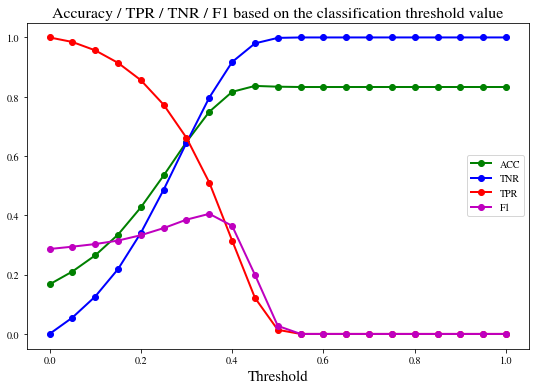

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 665645


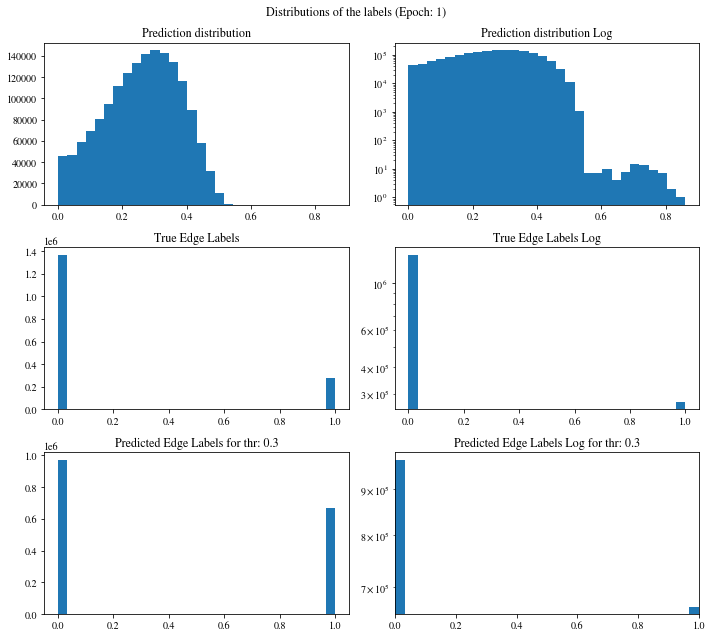

[2.76532590e-01 1.83090597e-01 2.48073518e-01 ... 4.39680889e-06
 8.71923912e-05 4.24665928e-01]
Confusion matrix:
[[879119 484581]
 [ 92680 181064]]

Confusion matrix weighted:
[[0.32232859 0.17767141]
 [0.16928225 0.33071775]]

TN: 879119 	 FN: 92680 	 TP: 181064 	 FP: 484581
Confusion matrix scaled:
[[0.53688493 0.29593745]
 [0.05660041 0.11057722]]

Accuracy: 0.6475
Precision: 0.2720
Negative predictive value: 0.9046
Recall: Correctly classifying 66.1436 % of positive edges
True negative rate: Correctly classifying 64.4657 % of all negative edges
F1 score: 0.3855
[0.65565802 0.65052086] [0.64465718 0.6614355 ] [0.65011107 0.65593278]
Balanced accuracy: 0.6530
Precision weighted: [0.65565802 0.65052086]
Recall weighted: [0.64465718 0.6614355 ]
F1 score weighted: [0.65011107 0.65593278]
positive_likelihood_ratio: 1.8614010738783628, negative_likelihood_ratio: 0.5251853346577074


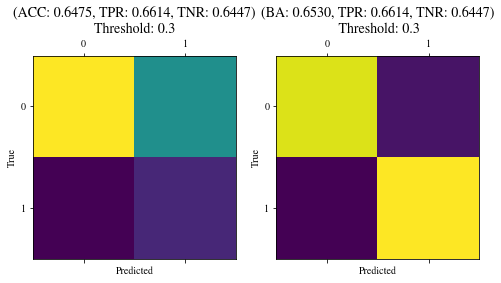

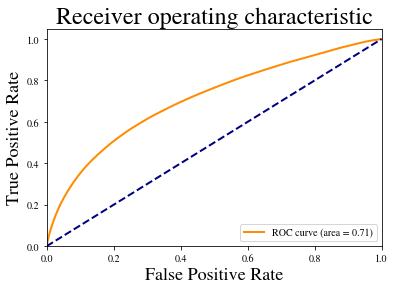

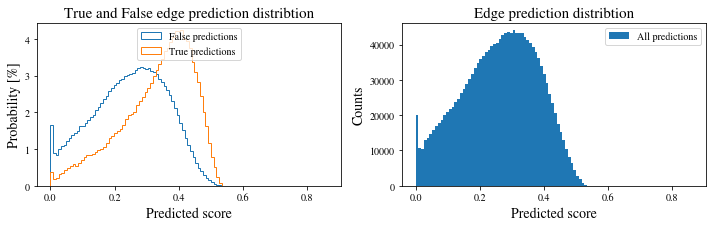

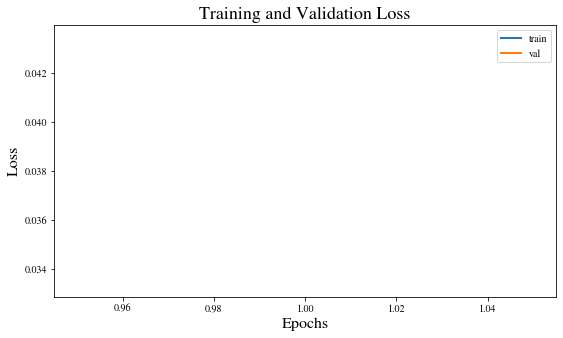

Training epoch 2: 100%|██████████| 20/20 [00:01<00:00, 17.67it/s]


Epoch: 2, train loss: 0.0368
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_2_loss_0.0368.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s]


Epoch: 2, val loss: 0.0326


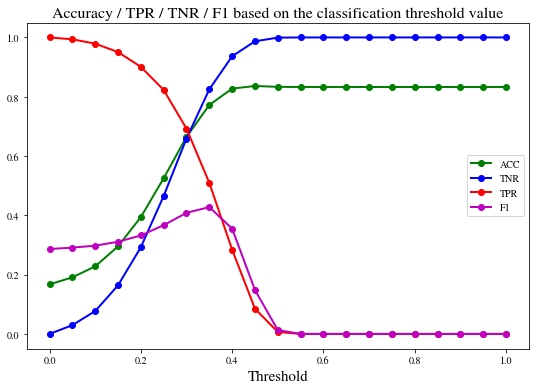

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 510015


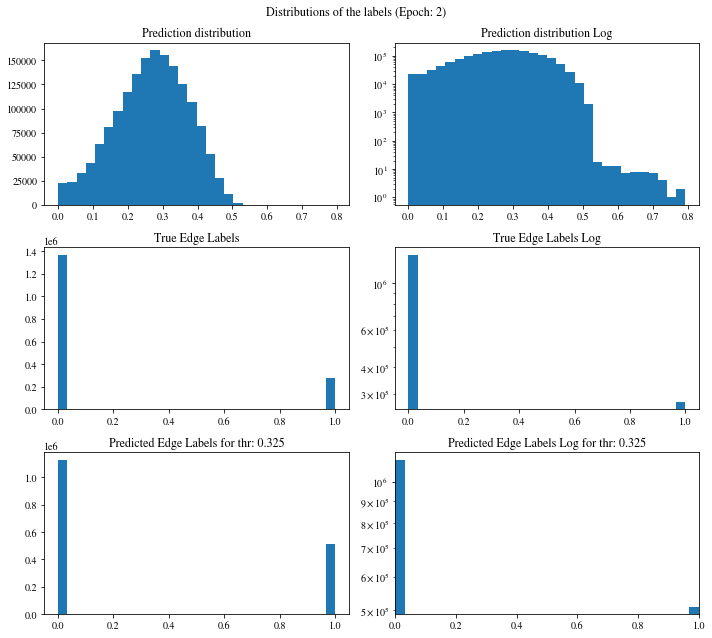

[0.44872889 0.41843739 0.46290484 ... 0.25642404 0.14234212 0.20406888]
Confusion matrix:
[[1019719  343981]
 [ 107710  166034]]

Confusion matrix weighted:
[[0.37387952 0.12612048]
 [0.19673491 0.30326509]]

TN: 1019719 	 FN: 107710 	 TP: 166034 	 FP: 343981
Confusion matrix scaled:
[[0.62275046 0.21007192]
 [0.06577935 0.10139828]]

Accuracy: 0.7241
Precision: 0.3255
Negative predictive value: 0.9045
Recall: Correctly classifying 60.6530 % of positive edges
True negative rate: Correctly classifying 74.7759 % of all negative edges
F1 score: 0.4237
[0.65522269 0.70627686] [0.74775904 0.60653019] [0.69843916 0.65261416]
Balanced accuracy: 0.6771
Precision weighted: [0.65522269 0.70627686]
Recall weighted: [0.74775904 0.60653019]
F1 score weighted: [0.69843916 0.65261416]
positive_likelihood_ratio: 2.4045665849342743, negative_likelihood_ratio: 0.5261986699744964


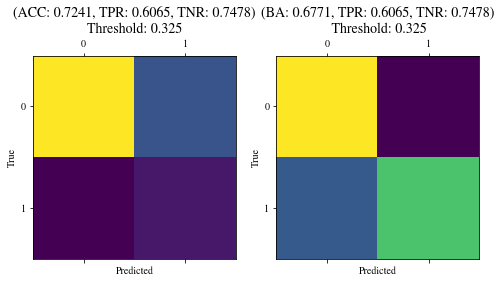

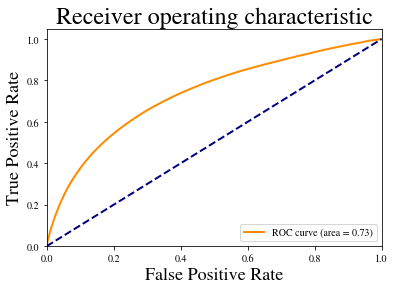

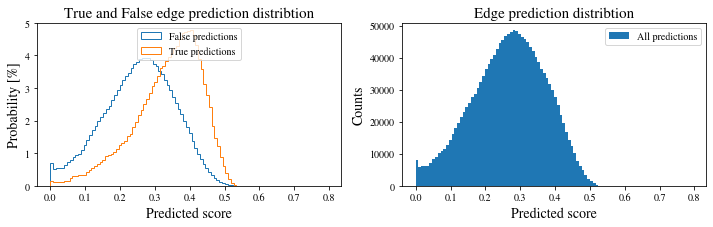

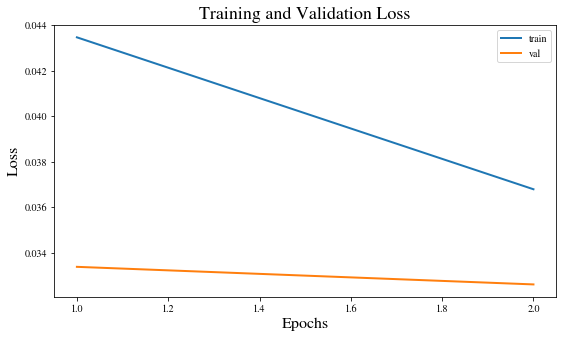

Training epoch 3: 100%|██████████| 20/20 [00:01<00:00, 17.74it/s]


Epoch: 3, train loss: 0.0339
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_3_loss_0.0339.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


Epoch: 3, val loss: 0.0296


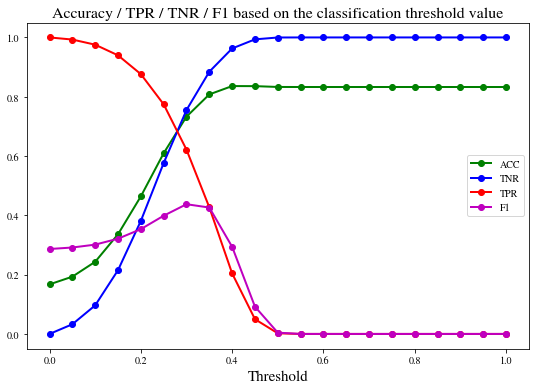

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 641552


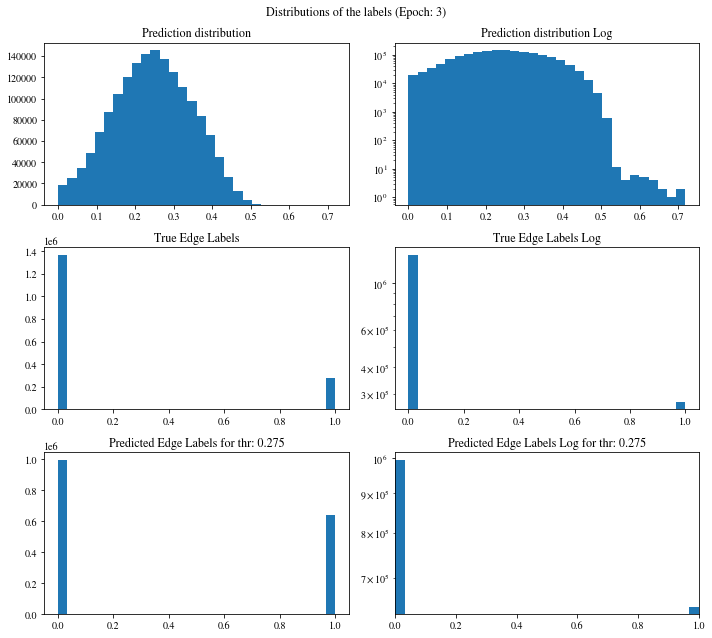

[0.2905747  0.14292046 0.25137681 ... 0.21334258 0.12206355 0.18335161]
Confusion matrix:
[[914673 449027]
 [ 81219 192525]]

Confusion matrix weighted:
[[0.33536445 0.16463555]
 [0.14834846 0.35165154]]

TN: 914673 	 FN: 81219 	 TP: 192525 	 FP: 449027
Confusion matrix scaled:
[[0.55859803 0.27422434]
 [0.04960109 0.11757654]]

Accuracy: 0.6762
Precision: 0.3001
Negative predictive value: 0.9184
Recall: Correctly classifying 70.3303 % of positive edges
True negative rate: Correctly classifying 67.0729 % of all negative edges
F1 score: 0.4207
[0.69331301 0.68111628] [0.6707289  0.70330309] [0.68183399 0.6920319 ]
Balanced accuracy: 0.6870
Precision weighted: [0.69331301 0.68111628]
Recall weighted: [0.6707289  0.70330309]
F1 score weighted: [0.68183399 0.6920319 ]
positive_likelihood_ratio: 2.135939305448899, negative_likelihood_ratio: 0.442349978071067


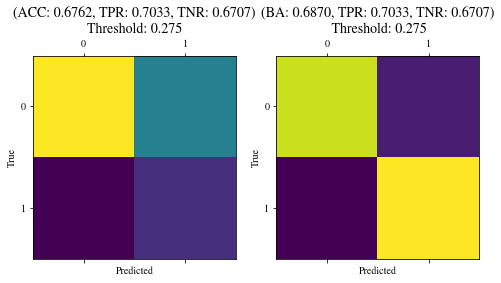

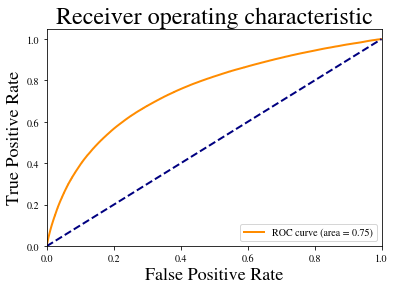

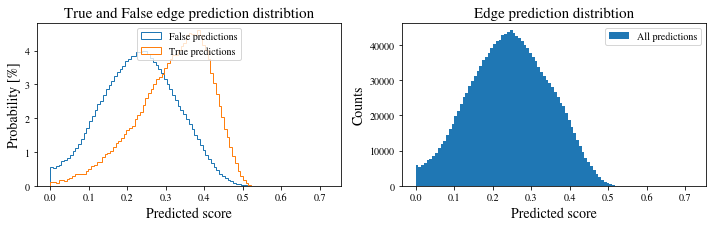

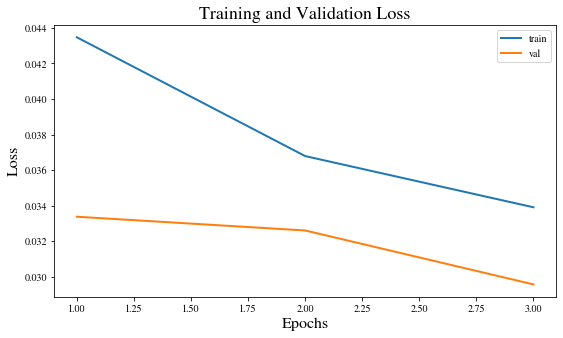

Training epoch 4: 100%|██████████| 20/20 [00:01<00:00, 16.97it/s]


Epoch: 4, train loss: 0.0326
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_4_loss_0.0326.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


Epoch: 4, val loss: 0.0293


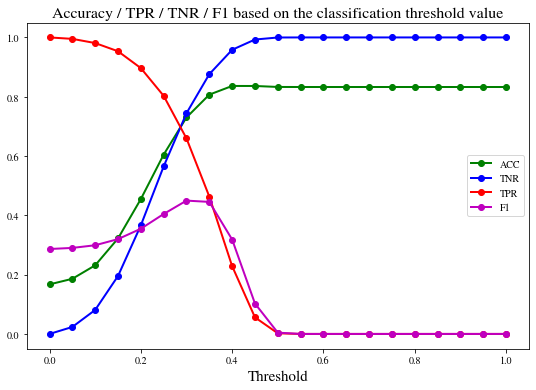

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 665617


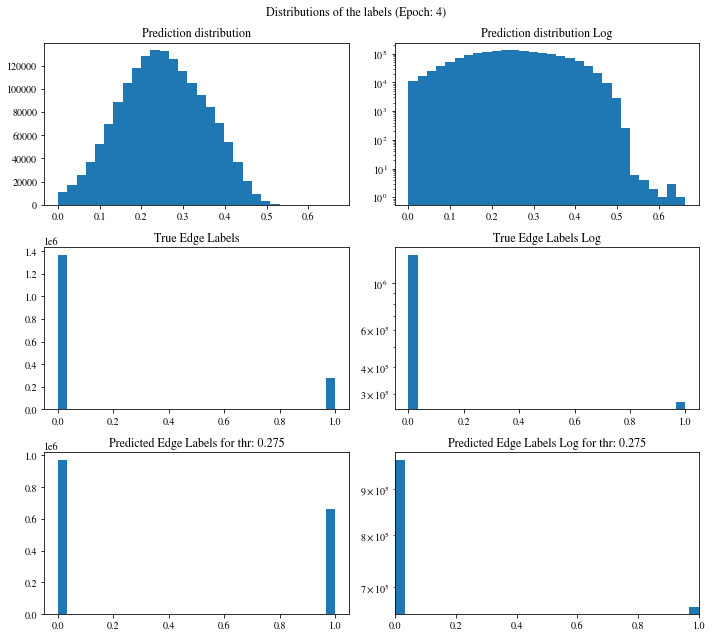

[0.39119276 0.1996121  0.38439482 ... 0.22105436 0.13475801 0.19811694]
Confusion matrix:
[[900269 463431]
 [ 71558 202186]]

Confusion matrix weighted:
[[0.33008323 0.16991677]
 [0.13070241 0.36929759]]

TN: 900269 	 FN: 71558 	 TP: 202186 	 FP: 463431
Confusion matrix scaled:
[[0.5498014  0.28302098]
 [0.04370104 0.12347659]]

Accuracy: 0.6733
Precision: 0.3038
Negative predictive value: 0.9264
Recall: Correctly classifying 73.8595 % of positive edges
True negative rate: Correctly classifying 66.0166 % of all negative edges
F1 score: 0.4305
[0.71634878 0.68488085] [0.66016646 0.73859518] [0.68711108 0.71072457]
Balanced accuracy: 0.6994
Precision weighted: [0.71634878 0.68488085]
Recall weighted: [0.66016646 0.73859518]
F1 score weighted: [0.68711108 0.71072457]
positive_likelihood_ratio: 2.1734028413662805, negative_likelihood_ratio: 0.3959680360234367


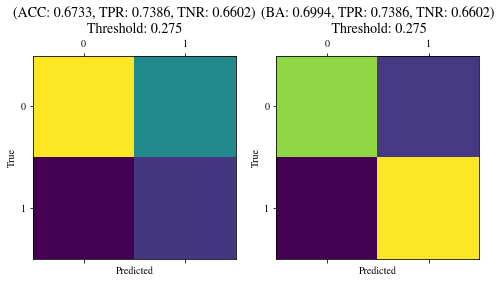

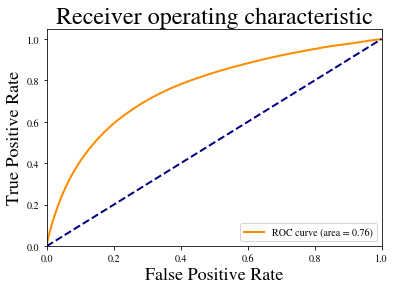

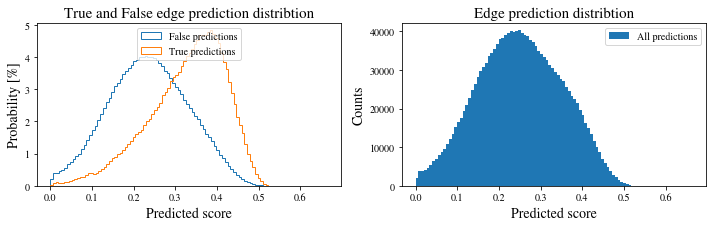

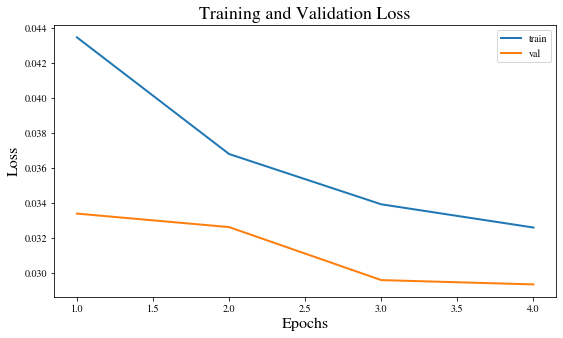

Training epoch 5: 100%|██████████| 20/20 [00:01<00:00, 17.01it/s]


Epoch: 5, train loss: 0.0313
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_5_loss_0.0313.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


Epoch: 5, val loss: 0.0279


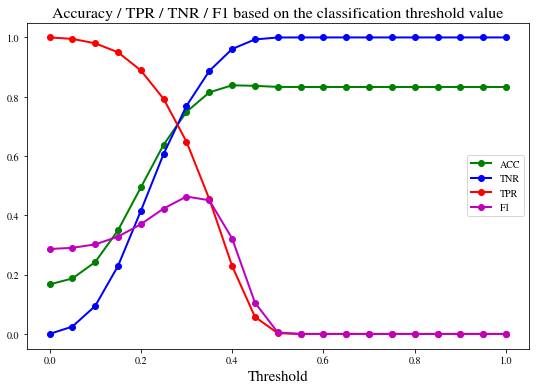

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 616526


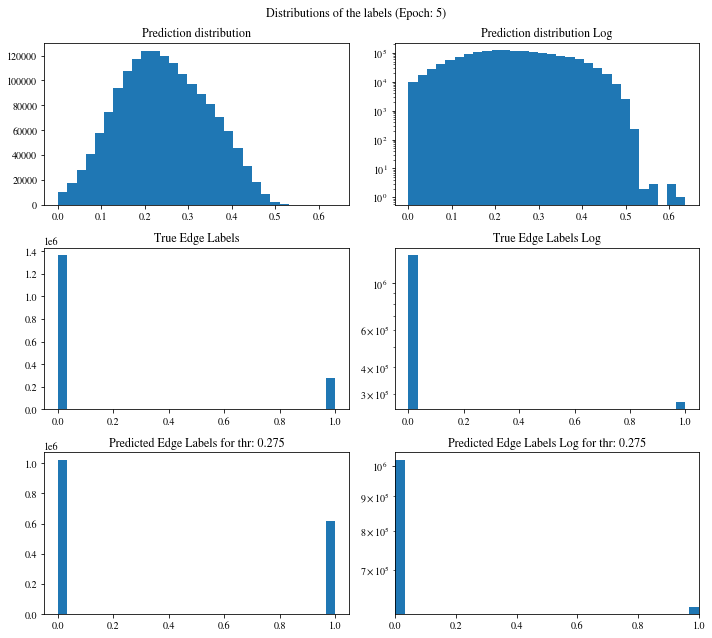

[0.43725464 0.42903748 0.46298414 ... 0.2188651  0.12689875 0.19204141]
Confusion matrix:
[[946245 417455]
 [ 74673 199071]]

Confusion matrix weighted:
[[0.34694031 0.15305969]
 [0.13639203 0.36360797]]

TN: 946245 	 FN: 74673 	 TP: 199071 	 FP: 417455
Confusion matrix scaled:
[[0.5778793  0.25494307]
 [0.04560339 0.12157423]]

Accuracy: 0.6995
Precision: 0.3229
Negative predictive value: 0.9269
Recall: Correctly classifying 72.7216 % of positive edges
True negative rate: Correctly classifying 69.3881 % of all negative edges
F1 score: 0.4472
[0.71780901 0.70375601] [0.69388062 0.72721594] [0.70564202 0.71529367]
Balanced accuracy: 0.7105
Precision weighted: [0.71780901 0.70375601]
Recall weighted: [0.69388062 0.72721594]
F1 score weighted: [0.70564202 0.71529367]
positive_likelihood_ratio: 2.3755958749717285, negative_likelihood_ratio: 0.3931282321319288


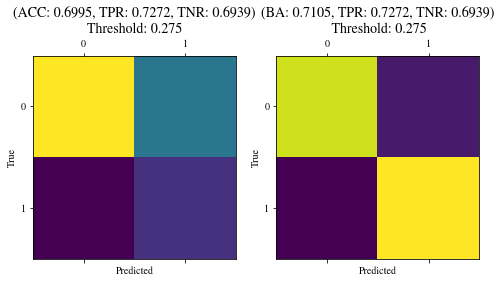

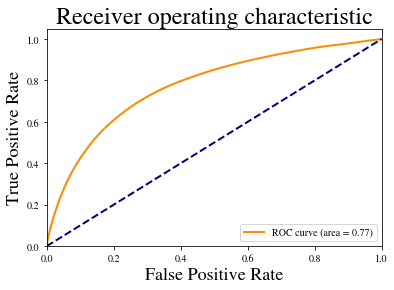

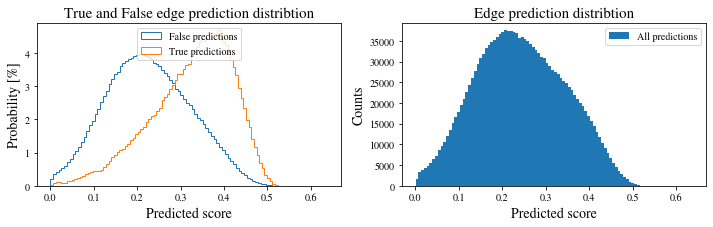

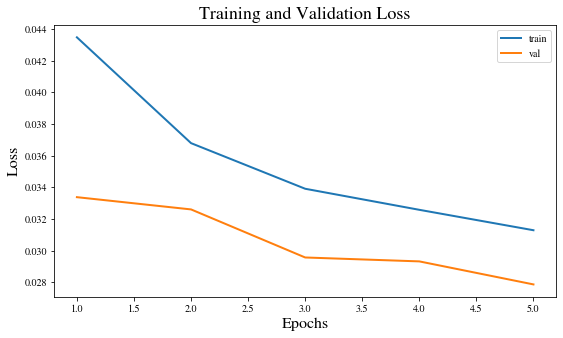

Training epoch 6: 100%|██████████| 20/20 [00:01<00:00, 17.43it/s]


Epoch: 6, train loss: 0.0302
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_6_loss_0.0302.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.63it/s]


Epoch: 6, val loss: 0.0276


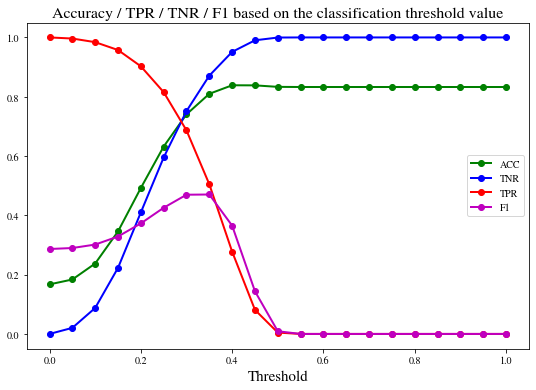

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 646922


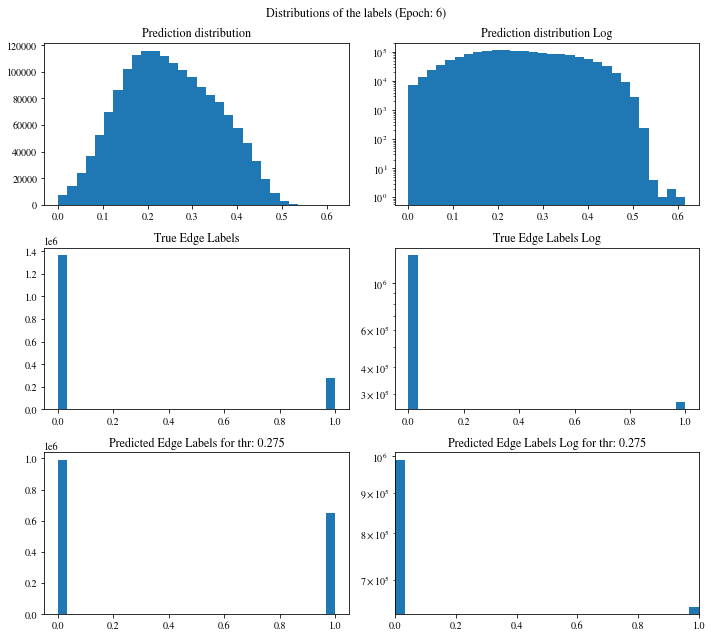

[0.4673377  0.39552951 0.26332039 ... 0.04004951 0.13748327 0.46549317]
Confusion matrix:
[[924127 439573]
 [ 66395 207349]]

Confusion matrix weighted:
[[0.33883075 0.16116925]
 [0.12127206 0.37872794]]

TN: 924127 	 FN: 66395 	 TP: 207349 	 FP: 439573
Confusion matrix scaled:
[[0.56437167 0.26845071]
 [0.04054795 0.12662967]]

Accuracy: 0.6910
Precision: 0.3205
Negative predictive value: 0.9330
Recall: Correctly classifying 75.7456 % of positive edges
True negative rate: Correctly classifying 67.7662 % of all negative edges
F1 score: 0.4504
[0.73642399 0.70148159] [0.67766151 0.75745587] [0.70582181 0.72839497]
Balanced accuracy: 0.7176
Precision weighted: [0.73642399 0.70148159]
Recall weighted: [0.67766151 0.75745587]
F1 score weighted: [0.70582181 0.72839497]
positive_likelihood_ratio: 2.34987720248214, negative_likelihood_ratio: 0.35791339120415067


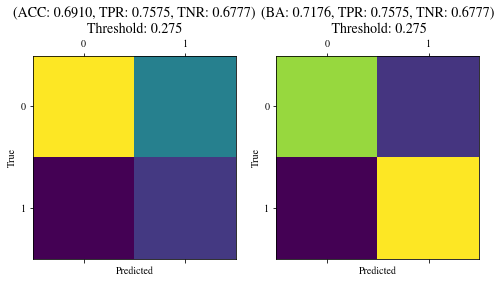

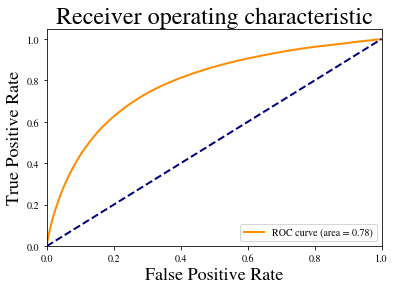

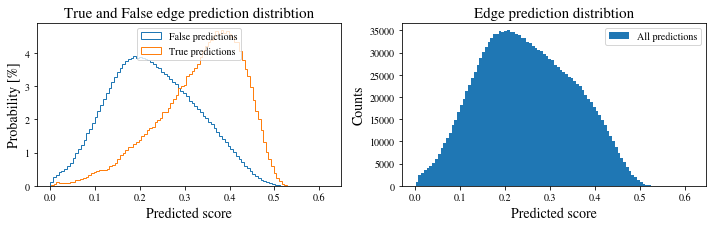

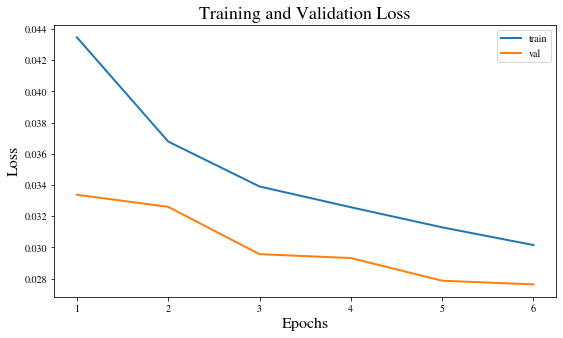

Training epoch 7: 100%|██████████| 20/20 [00:01<00:00, 16.88it/s]


Epoch: 7, train loss: 0.0292
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_7_loss_0.0292.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


Epoch: 7, val loss: 0.0263


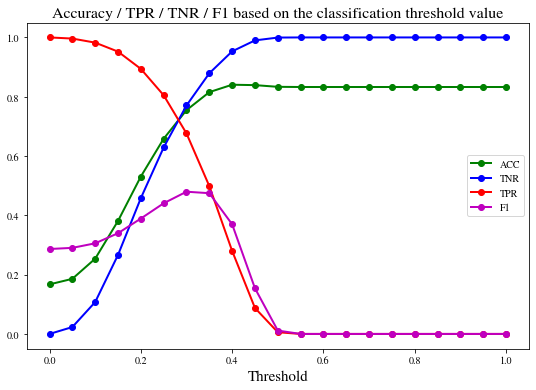

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 608561


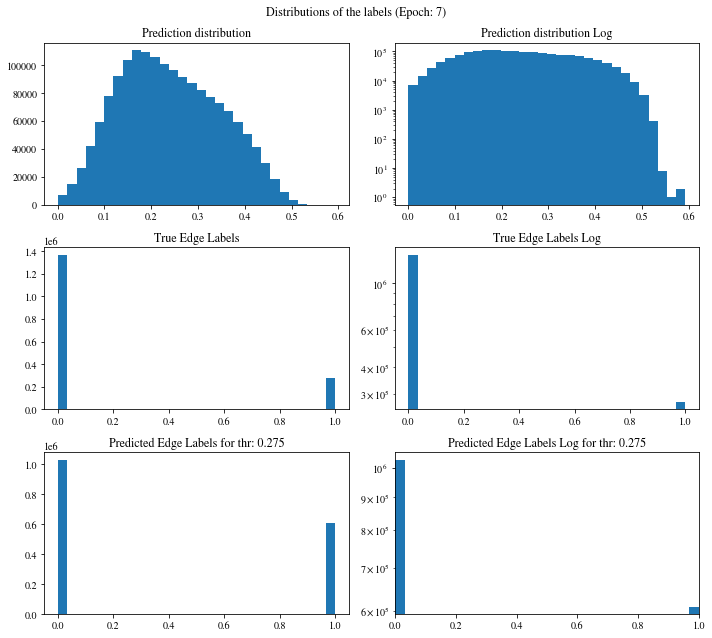

[0.45256788 0.43458608 0.39832208 ... 0.0099805  0.01281107 0.41082066]
Confusion matrix:
[[959372 404328]
 [ 69511 204233]]

Confusion matrix weighted:
[[0.35175332 0.14824668]
 [0.12696351 0.37303649]]

TN: 959372 	 FN: 69511 	 TP: 204233 	 FP: 404328
Confusion matrix scaled:
[[0.58589607 0.24692631]
 [0.04245092 0.12472671]]

Accuracy: 0.7106
Precision: 0.3356
Negative predictive value: 0.9324
Recall: Correctly classifying 74.6073 % of positive edges
True negative rate: Correctly classifying 70.3507 % of all negative edges
F1 score: 0.4630
[0.73478369 0.71561199] [0.70350664 0.74607297] [0.71880509 0.73052508]
Balanced accuracy: 0.7248
Precision weighted: [0.73478369 0.71561199]
Recall weighted: [0.70350664 0.74607297]
F1 score weighted: [0.71880509 0.73052508]
positive_likelihood_ratio: 2.5163226728648267, negative_likelihood_ratio: 0.3609447496131952


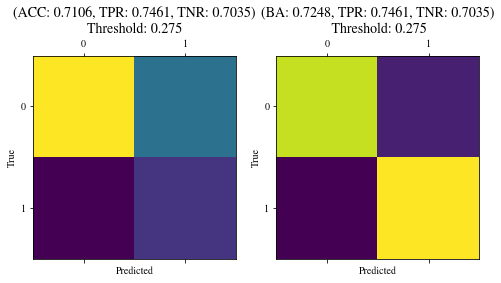

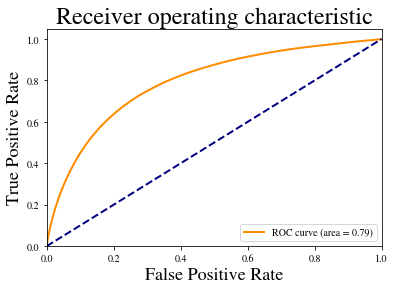

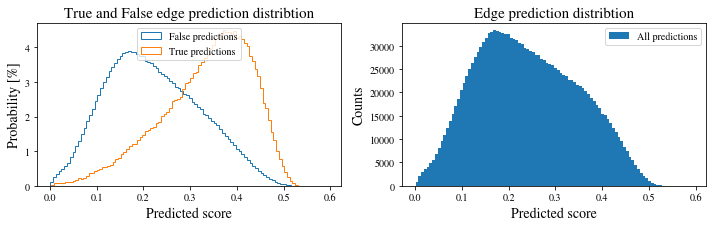

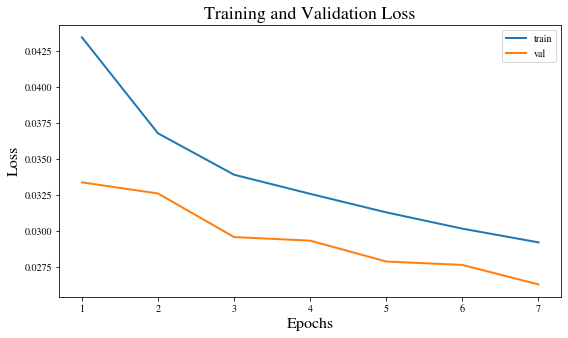

Training epoch 8: 100%|██████████| 20/20 [00:01<00:00, 16.92it/s]


Epoch: 8, train loss: 0.0283
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_8_loss_0.0283.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.50it/s]


Epoch: 8, val loss: 0.0254


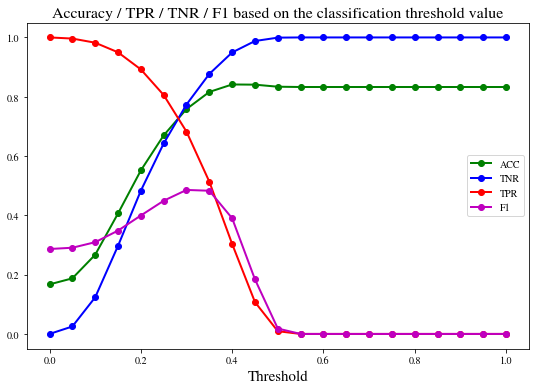

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 598846


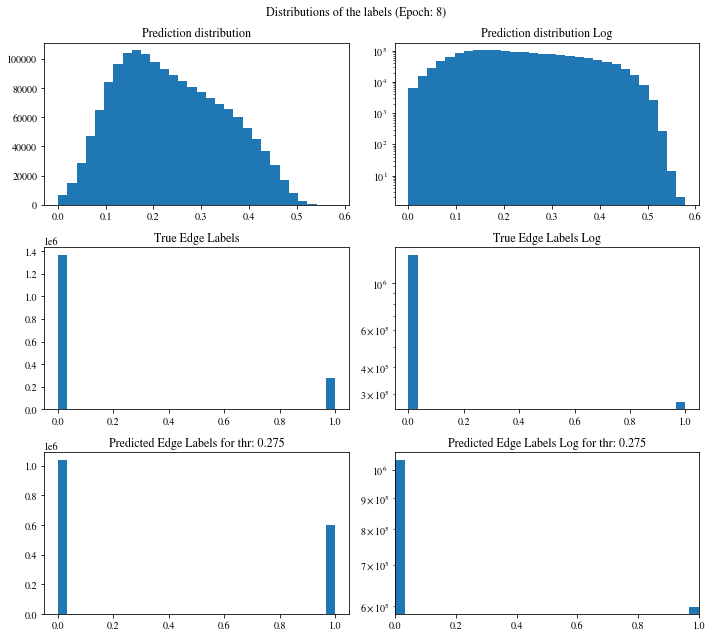

[0.45591372 0.43235564 0.39511362 ... 0.01169788 0.01368952 0.41361904]
Confusion matrix:
[[969862 393838]
 [ 68736 205008]]

Confusion matrix weighted:
[[0.35559947 0.14440053]
 [0.12554796 0.37445204]]

TN: 969862 	 FN: 68736 	 TP: 205008 	 FP: 393838
Confusion matrix scaled:
[[0.59230239 0.24051998]
 [0.04197762 0.12520001]]

Accuracy: 0.7175
Precision: 0.3423
Negative predictive value: 0.9338
Recall: Correctly classifying 74.8904 % of positive edges
True negative rate: Correctly classifying 71.1199 % of all negative edges
F1 score: 0.4699
[0.73906551 0.72169257] [0.71119894 0.74890409] [0.7248645  0.73504657]
Balanced accuracy: 0.7301
Precision weighted: [0.73906551 0.72169257]
Recall weighted: [0.71119894 0.74890409]
F1 score weighted: [0.7248645  0.73504657]
positive_likelihood_ratio: 2.593148709597458, negative_likelihood_ratio: 0.35306002143558196


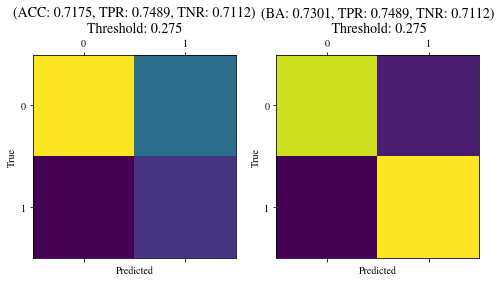

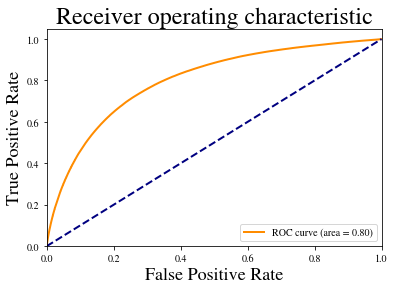

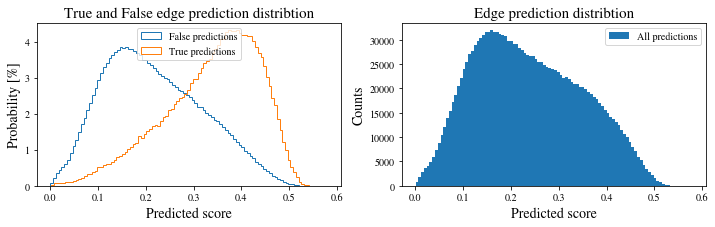

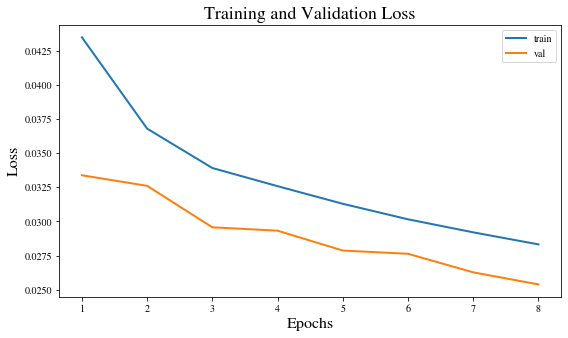

Training epoch 9: 100%|██████████| 20/20 [00:01<00:00, 16.80it/s]


Epoch: 9, train loss: 0.0275
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_9_loss_0.0275.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.51it/s]


Epoch: 9, val loss: 0.0247


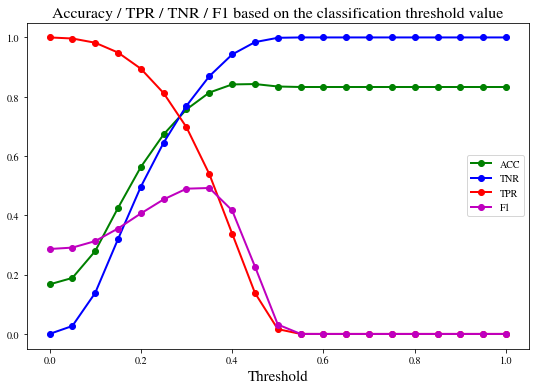

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 603293


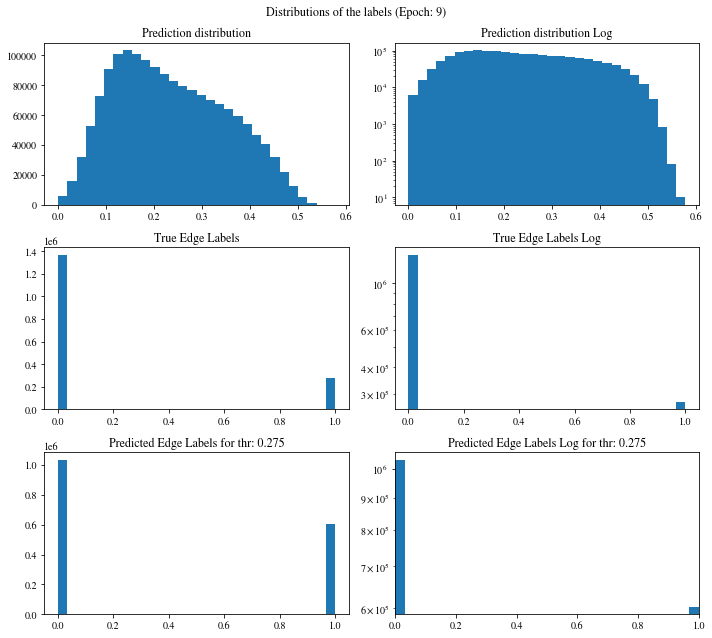

[0.44148886 0.4719972  0.49019527 ... 0.26305637 0.38492876 0.31943727]
Confusion matrix:
[[968273 395427]
 [ 65878 207866]]

Confusion matrix weighted:
[[0.35501687 0.14498313]
 [0.12032775 0.37967225]]

TN: 968273 	 FN: 65878 	 TP: 207866 	 FP: 395427
Confusion matrix scaled:
[[0.59133198 0.2414904 ]
 [0.04023222 0.12694541]]

Accuracy: 0.7183
Precision: 0.3446
Negative predictive value: 0.9363
Recall: Correctly classifying 75.9344 % of positive edges
True negative rate: Correctly classifying 71.0034 % of all negative edges
F1 score: 0.4740
[0.74686207 0.72366026] [0.71003373 0.7593445 ] [0.72798242 0.74107306]
Balanced accuracy: 0.7347
Precision weighted: [0.74686207 0.72366026]
Recall weighted: [0.71003373 0.7593445 ]
F1 score weighted: [0.72798242 0.74107306]
positive_likelihood_ratio: 2.6187339018954634, negative_likelihood_ratio: 0.33893530995409626


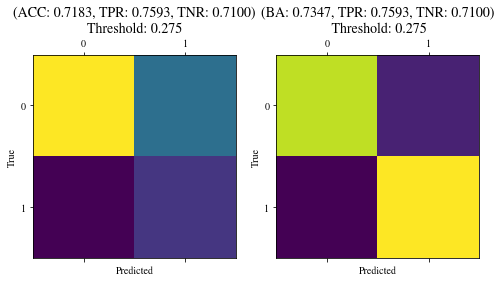

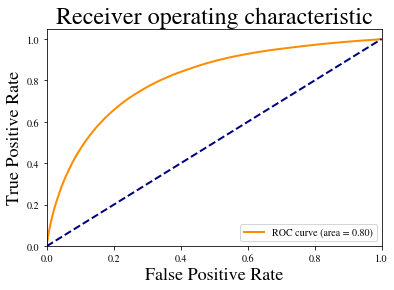

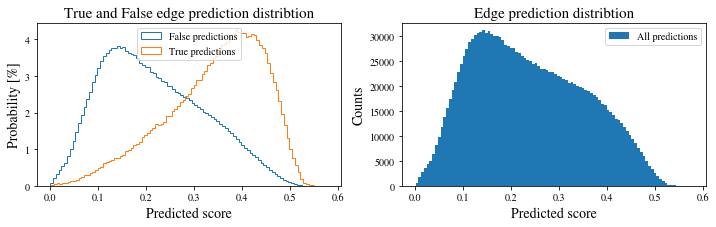

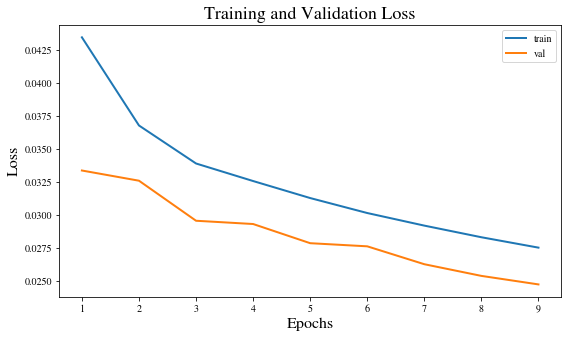

Training epoch 10: 100%|██████████| 20/20 [00:01<00:00, 17.74it/s]


Epoch: 10, train loss: 0.0267
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_10_loss_0.0267.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.32it/s]


Epoch: 10, val loss: 0.0237


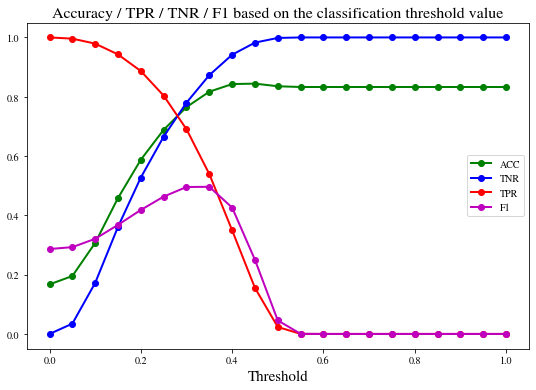

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 580218


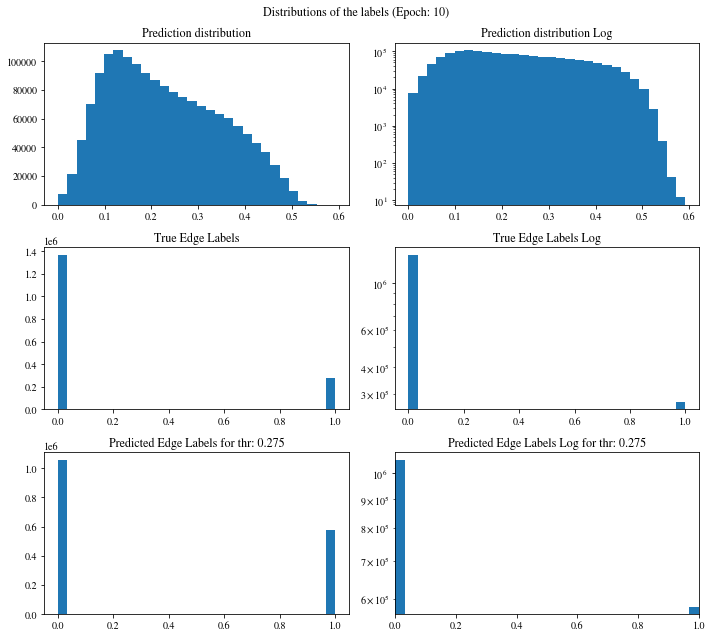

[0.35081574 0.08534757 0.24376279 ... 0.24152896 0.11222483 0.18712668]
Confusion matrix:
[[989172 374528]
 [ 68054 205690]]

Confusion matrix weighted:
[[0.36267947 0.13732053]
 [0.12430227 0.37569773]]

TN: 989172 	 FN: 68054 	 TP: 205690 	 FP: 374528
Confusion matrix scaled:
[[0.60409516 0.22872721]
 [0.04156112 0.12561651]]

Accuracy: 0.7297
Precision: 0.3545
Negative predictive value: 0.9356
Recall: Correctly classifying 75.1395 % of positive edges
True negative rate: Correctly classifying 72.5359 % of all negative edges
F1 score: 0.4817
[0.74474963 0.73232819] [0.72535895 0.75139546] [0.73492641 0.74173931]
Balanced accuracy: 0.7384
Precision weighted: [0.74474963 0.73232819]
Recall weighted: [0.72535895 0.75139546]
F1 score weighted: [0.73492641 0.74173931]
positive_likelihood_ratio: 2.735918261835791, negative_likelihood_ratio: 0.34273311944855384


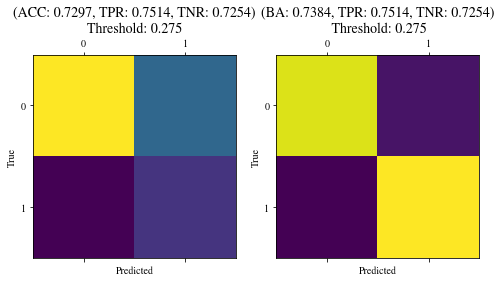

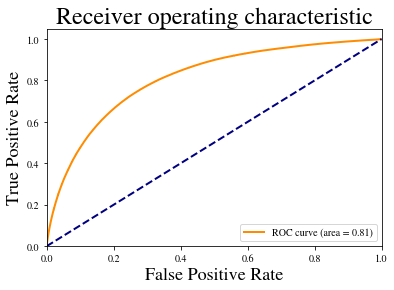

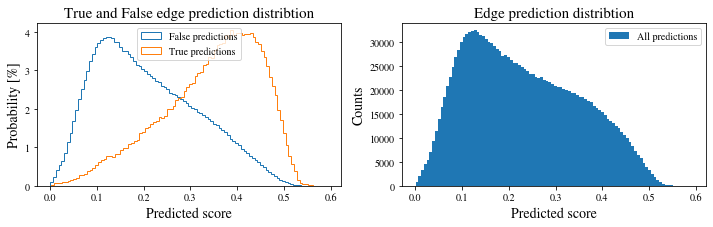

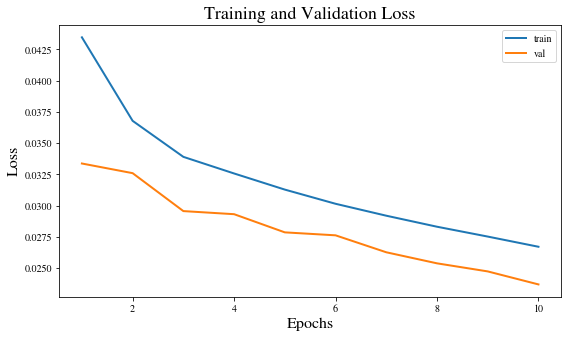

Training epoch 11: 100%|██████████| 20/20 [00:01<00:00, 17.26it/s]


Epoch: 11, train loss: 0.0261
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_11_loss_0.0261.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


Epoch: 11, val loss: 0.0234


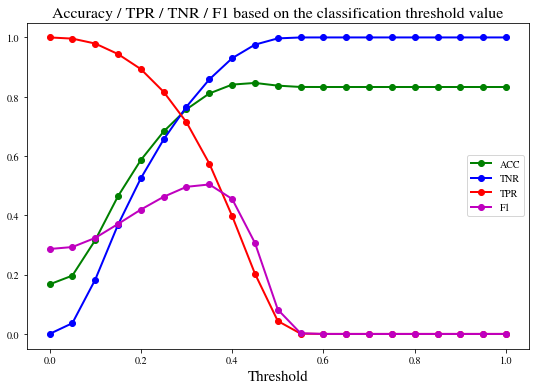

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 601379


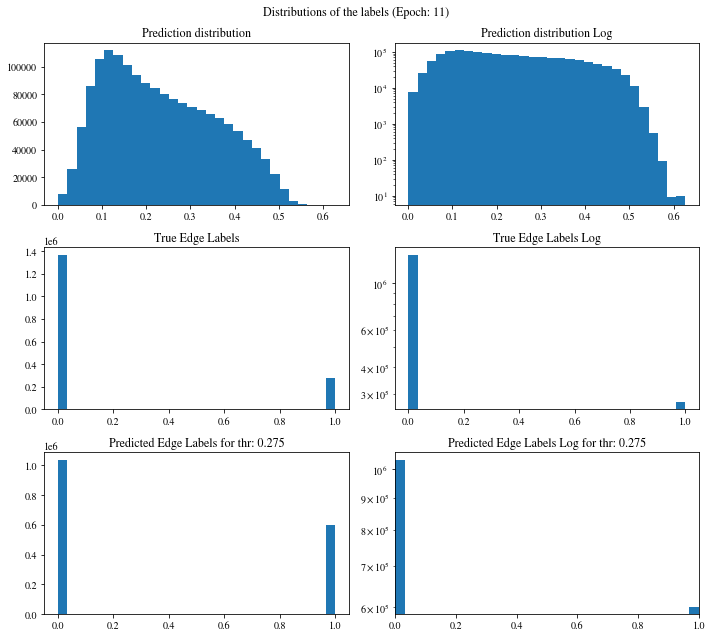

[0.48581722 0.3701438  0.19764394 ... 0.0476664  0.15851836 0.49601209]
Confusion matrix:
[[972917 390783]
 [ 63148 210596]]

Confusion matrix weighted:
[[0.35671959 0.14328041]
 [0.11534134 0.38465866]]

TN: 972917 	 FN: 63148 	 TP: 210596 	 FP: 390783
Confusion matrix scaled:
[[0.59416811 0.23865427]
 [0.03856498 0.12861264]]

Accuracy: 0.7228
Precision: 0.3502
Negative predictive value: 0.9391
Recall: Correctly classifying 76.9317 % of positive edges
True negative rate: Correctly classifying 71.3439 % of all negative edges
F1 score: 0.4813
[0.75566429 0.72860426] [0.71343917 0.76931732] [0.73394491 0.74840751]
Balanced accuracy: 0.7414
Precision weighted: [0.75566429 0.72860426]
Recall weighted: [0.71343917 0.76931732]
F1 score weighted: [0.73394491 0.74840751]
positive_likelihood_ratio: 2.6846562595143095, negative_likelihood_ratio: 0.32333896204734797


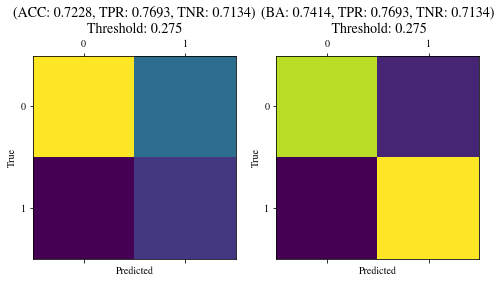

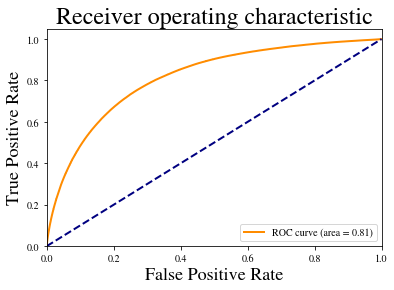

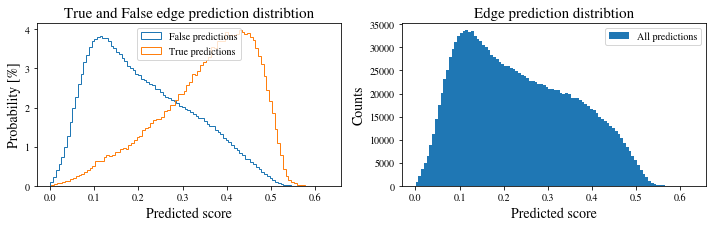

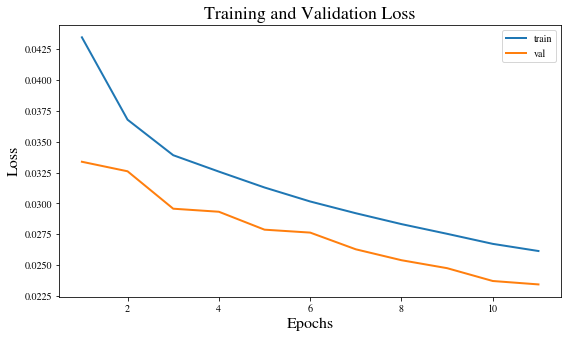

Training epoch 12: 100%|██████████| 20/20 [00:01<00:00, 17.17it/s]


Epoch: 12, train loss: 0.0256
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_12_loss_0.0256.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.20it/s]


Epoch: 12, val loss: 0.0227


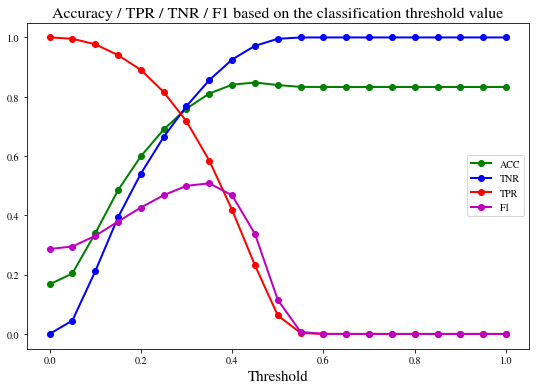

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 595126


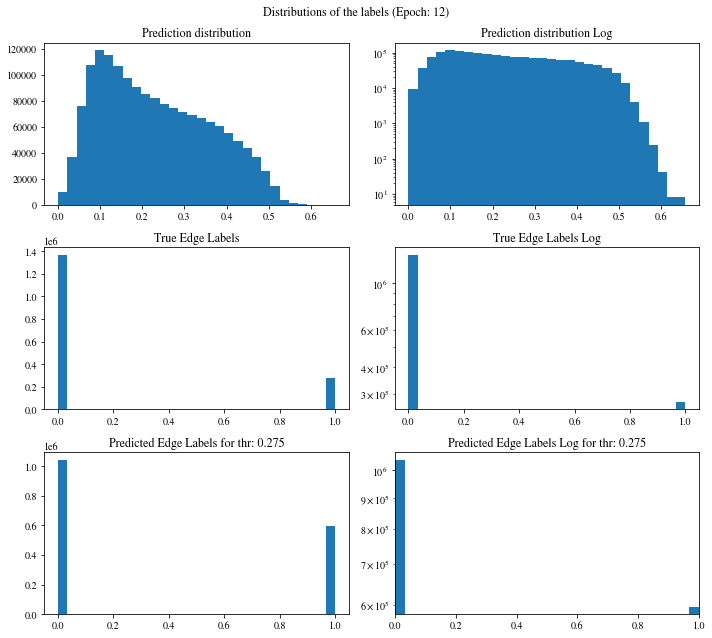

[0.48897007 0.36388651 0.18641952 ... 0.04831938 0.15950805 0.50265968]
Confusion matrix:
[[979477 384223]
 [ 62841 210903]]

Confusion matrix weighted:
[[0.35912481 0.14087519]
 [0.1147806  0.3852194 ]]

TN: 979477 	 FN: 62841 	 TP: 210903 	 FP: 384223
Confusion matrix scaled:
[[0.59817435 0.23464802]
 [0.0383775  0.12880013]]

Accuracy: 0.7270
Precision: 0.3544
Negative predictive value: 0.9397
Recall: Correctly classifying 77.0439 % of positive edges
True negative rate: Correctly classifying 71.8250 % of all negative edges
F1 score: 0.4855
[0.7577985 0.7322246] [0.71824962 0.7704388 ] [0.73749423 0.75084579]
Balanced accuracy: 0.7443
Precision weighted: [0.7577985 0.7322246]
Recall weighted: [0.71824962 0.7704388 ]
F1 score weighted: [0.73749423 0.75084579]
positive_likelihood_ratio: 2.7344729420238414, negative_likelihood_ratio: 0.31961199987010785


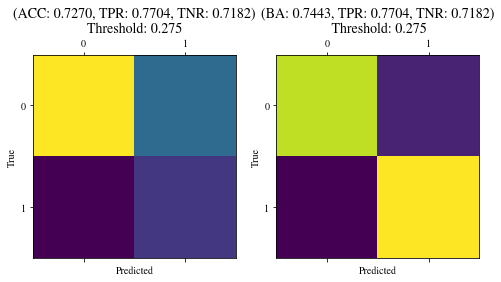

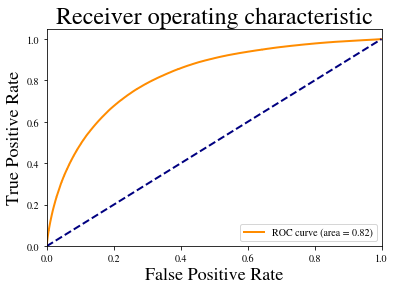

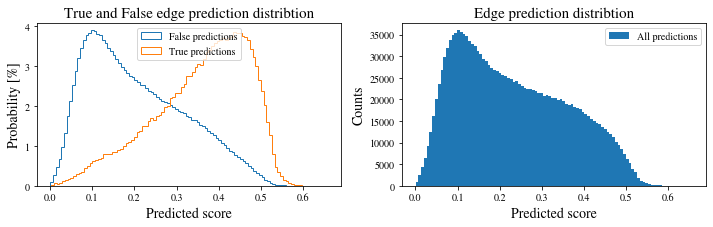

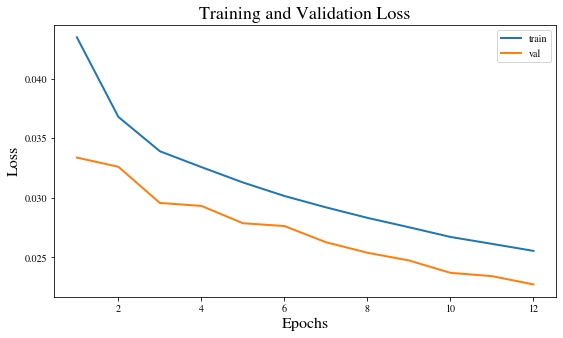

Training epoch 13: 100%|██████████| 20/20 [00:01<00:00, 17.37it/s]


Epoch: 13, train loss: 0.0251
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_13_loss_0.0251.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.31it/s]


Epoch: 13, val loss: 0.0225


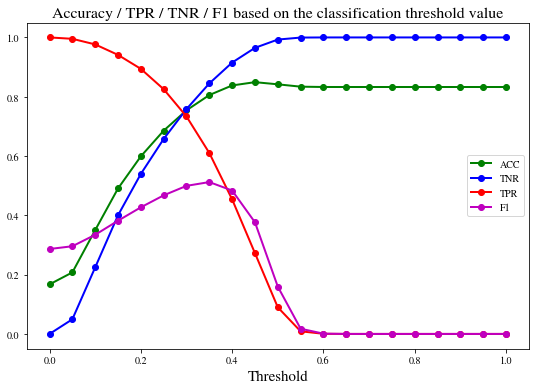

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 610128


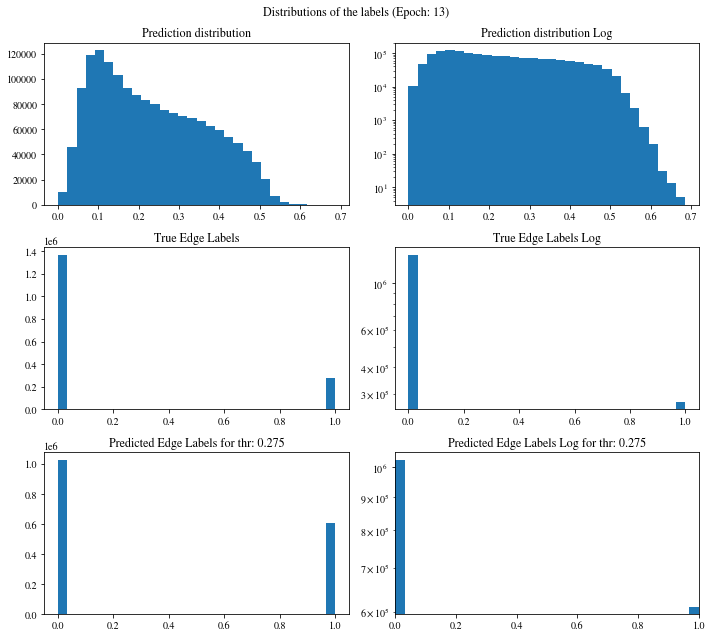

[0.49560282 0.36179307 0.17898364 ... 0.26430172 0.20675698 0.29536119]
Confusion matrix:
[[967988 395712]
 [ 59328 214416]]

Confusion matrix weighted:
[[0.35491237 0.14508763]
 [0.10836402 0.39163598]]

TN: 967988 	 FN: 59328 	 TP: 214416 	 FP: 395712
Confusion matrix scaled:
[[0.59115793 0.24166445]
 [0.03623208 0.13094555]]

Accuracy: 0.7221
Precision: 0.3514
Negative predictive value: 0.9422
Recall: Correctly classifying 78.3272 % of positive edges
True negative rate: Correctly classifying 70.9825 % of all negative edges
F1 score: 0.4852
[0.76609208 0.72967906] [0.70982474 0.78327196] [0.73688585 0.75552631]
Balanced accuracy: 0.7465
Precision weighted: [0.76609208 0.72967906]
Recall weighted: [0.70982474 0.78327196]
F1 score weighted: [0.73688585 0.75552631]
positive_likelihood_ratio: 2.6993065025830187, negative_likelihood_ratio: 0.30532612516877117


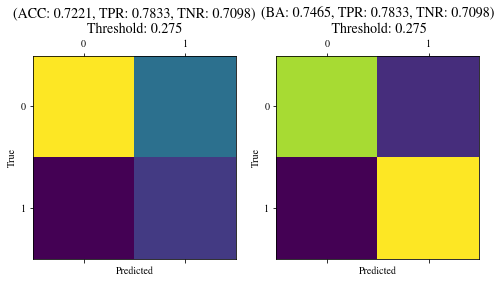

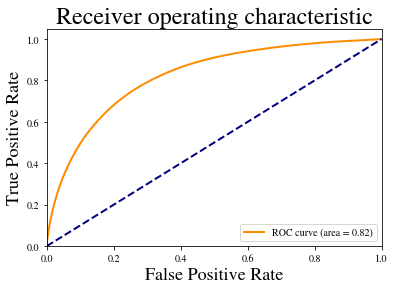

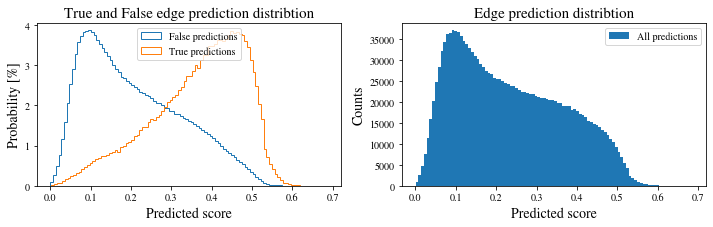

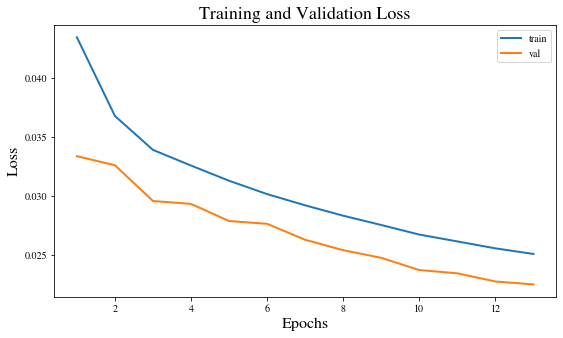

Training epoch 14: 100%|██████████| 20/20 [00:01<00:00, 17.21it/s]


Epoch: 14, train loss: 0.0245
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_14_loss_0.0245.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.72it/s]


Epoch: 14, val loss: 0.0217


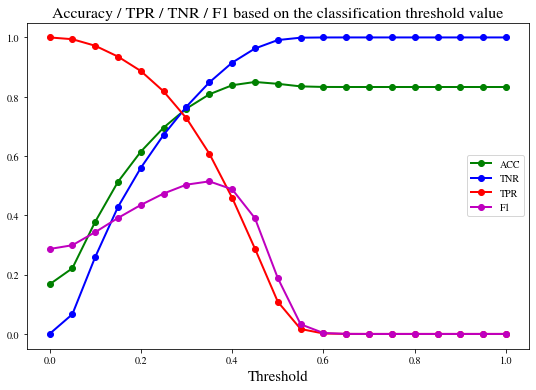

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 593103


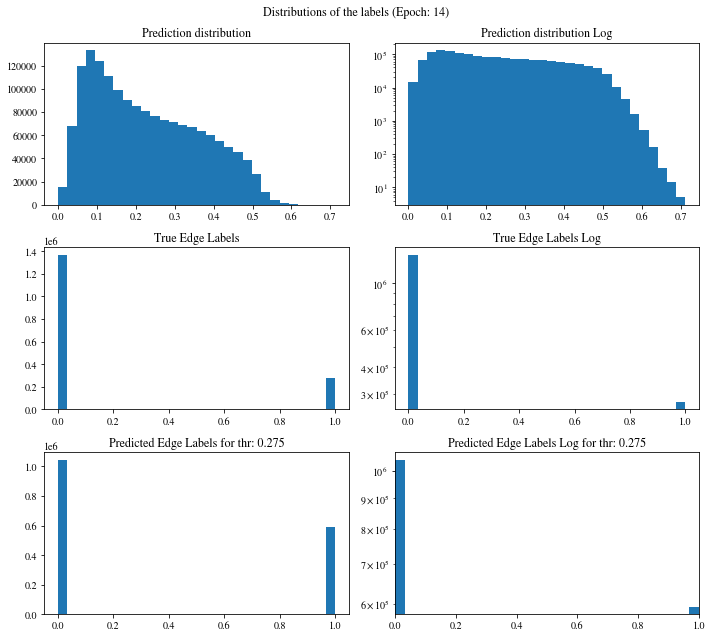

[0.49605584 0.35423148 0.16778249 ... 0.26529247 0.20530699 0.29835778]
Confusion matrix:
[[983072 380628]
 [ 61269 212475]]

Confusion matrix weighted:
[[0.36044291 0.13955709]
 [0.1119093  0.3880907 ]]

TN: 983072 	 FN: 61269 	 TP: 212475 	 FP: 380628
Confusion matrix scaled:
[[0.60036984 0.23245253]
 [0.03741746 0.12976016]]

Accuracy: 0.7301
Precision: 0.3582
Negative predictive value: 0.9413
Recall: Correctly classifying 77.6181 % of positive edges
True negative rate: Correctly classifying 72.0886 % of all negative edges
F1 score: 0.4902
[0.76308081 0.7355109 ] [0.72088583 0.7761814 ] [0.74138344 0.75529905]
Balanced accuracy: 0.7485
Precision weighted: [0.76308081 0.7355109 ]
Recall weighted: [0.72088583 0.7761814 ]
F1 score weighted: [0.74138344 0.75529905]
positive_likelihood_ratio: 2.780874159003809, negative_likelihood_ratio: 0.3104771884528277


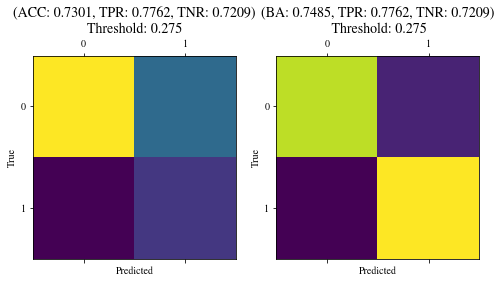

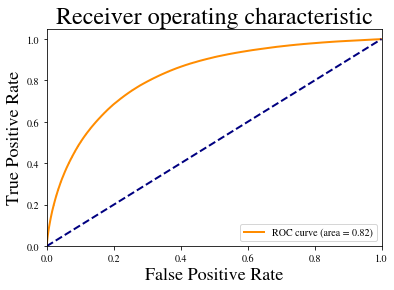

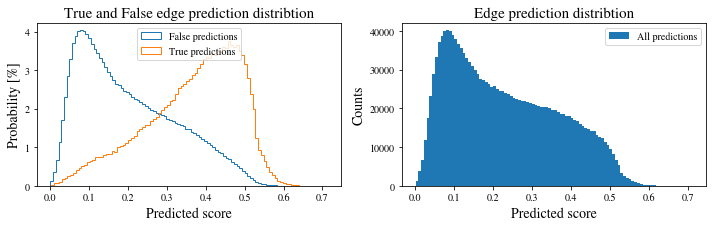

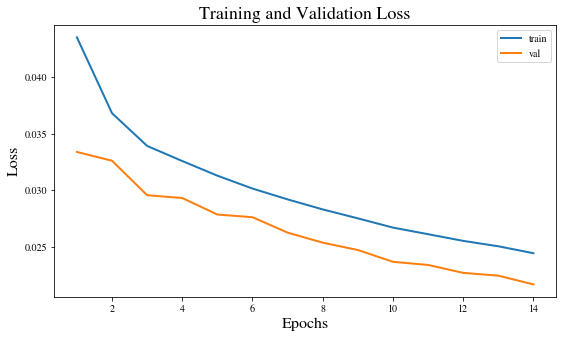

Training epoch 15: 100%|██████████| 20/20 [00:01<00:00, 17.82it/s]


Epoch: 15, train loss: 0.0241
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_15_loss_0.0241.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.24it/s]


Epoch: 15, val loss: 0.0212


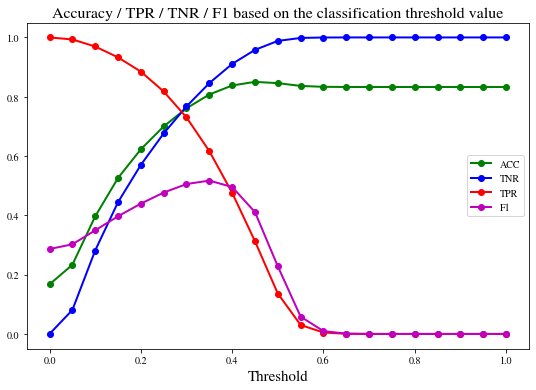

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 590094


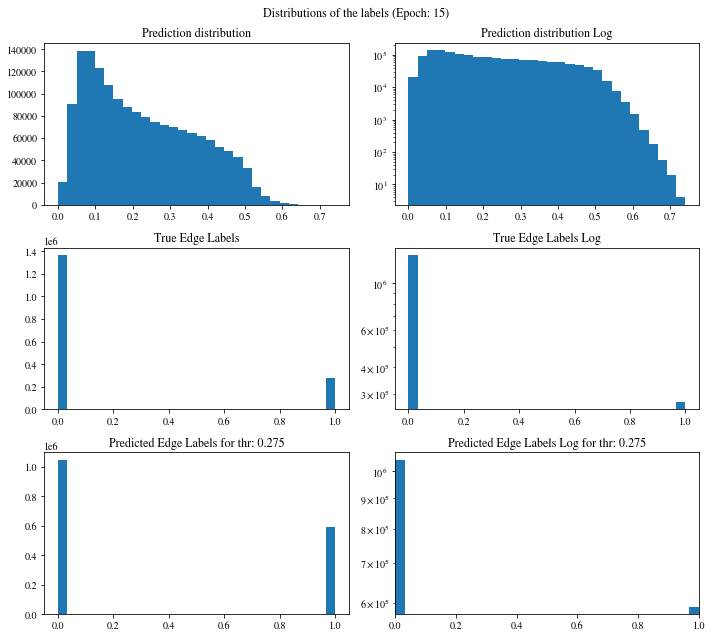

[0.53670073 0.45551512 0.41291362 ... 0.2746259  0.20812438 0.3065196 ]
Confusion matrix:
[[986366 377334]
 [ 60984 212760]]

Confusion matrix weighted:
[[0.36165066 0.13834934]
 [0.11138874 0.38861126]]

TN: 986366 	 FN: 60984 	 TP: 212760 	 FP: 377334
Confusion matrix scaled:
[[0.60238152 0.23044086]
 [0.03724341 0.12993421]]

Accuracy: 0.7323
Precision: 0.3606
Negative predictive value: 0.9418
Recall: Correctly classifying 77.7223 % of positive edges
True negative rate: Correctly classifying 72.3301 % of all negative edges
F1 score: 0.4926
[0.76452544 0.7374579 ] [0.72330131 0.77722251] [0.74334227 0.75681824]
Balanced accuracy: 0.7503
Precision weighted: [0.76452544 0.7374579 ]
Recall weighted: [0.72330131 0.77722251]
F1 score weighted: [0.74334227 0.75681824]
positive_likelihood_ratio: 2.808912907337744, negative_likelihood_ratio: 0.30800094186399335


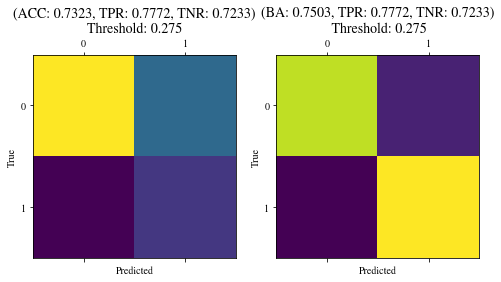

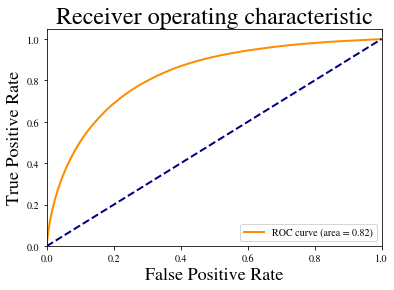

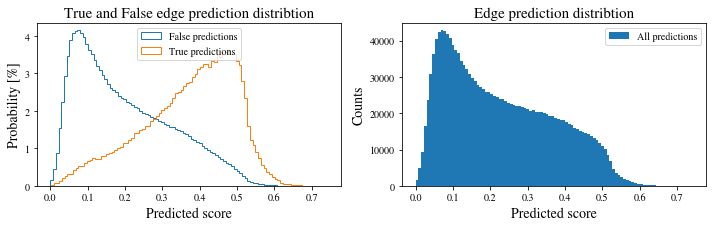

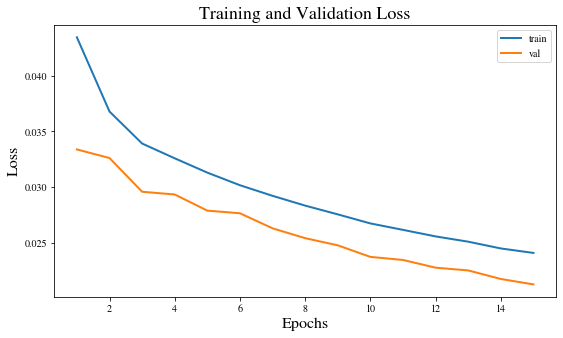

Training epoch 16: 100%|██████████| 20/20 [00:01<00:00, 17.77it/s]


Epoch: 16, train loss: 0.0236
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_16_loss_0.0236.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 20.13it/s]


Epoch: 16, val loss: 0.0212


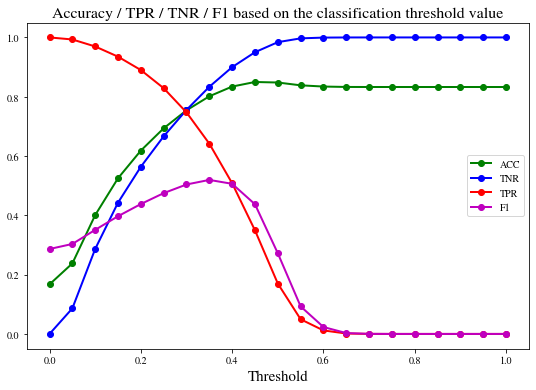

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 537918


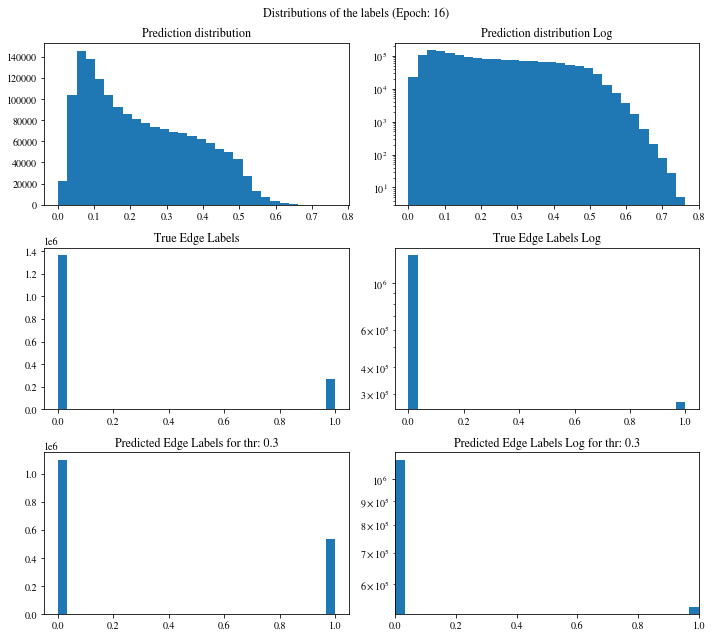

[0.44801232 0.53962725 0.51880348 ... 0.27536154 0.10379812 0.18660325]
Confusion matrix:
[[1030340  333360]
 [  69186  204558]]

Confusion matrix weighted:
[[0.3777737  0.1222263 ]
 [0.12636989 0.37363011]]

TN: 1030340 	 FN: 69186 	 TP: 204558 	 FP: 333360
Confusion matrix scaled:
[[0.62923679 0.20358559]
 [0.04225244 0.12492519]]

Accuracy: 0.7542
Precision: 0.3803
Negative predictive value: 0.9371
Recall: Correctly classifying 74.7260 % of positive edges
True negative rate: Correctly classifying 75.5547 % of all negative edges
F1 score: 0.5040
[0.7493375  0.75350465] [0.75554741 0.74726021] [0.75242964 0.75036944]
Balanced accuracy: 0.7514
Precision weighted: [0.7493375  0.75350465]
Recall weighted: [0.75554741 0.74726021]
F1 score weighted: [0.75242964 0.75036944]
positive_likelihood_ratio: 3.0568717114414117, negative_likelihood_ratio: 0.33451214771229976


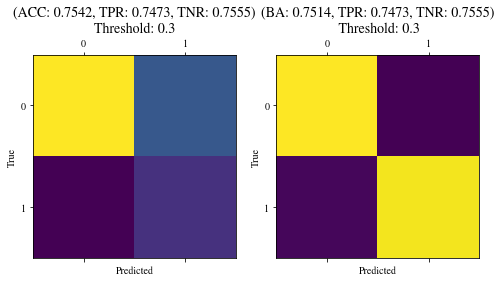

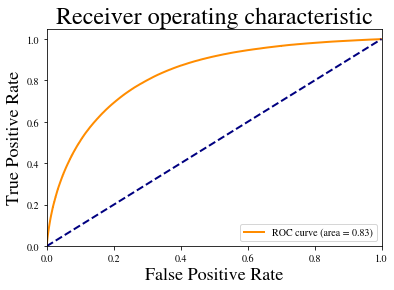

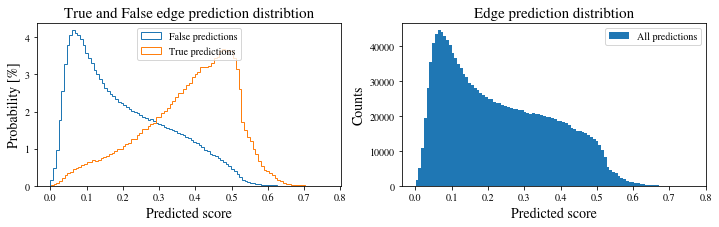

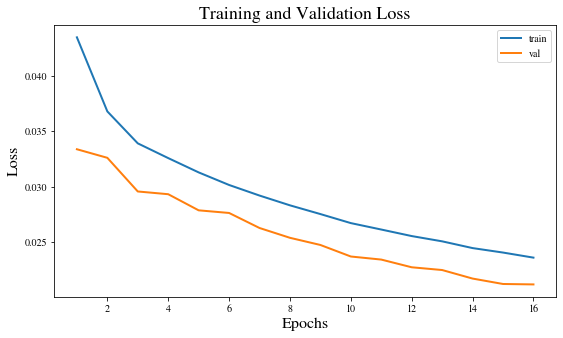

Training epoch 17: 100%|██████████| 20/20 [00:01<00:00, 14.50it/s]


Epoch: 17, train loss: 0.0234
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_17_loss_0.0234.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.52it/s]


Epoch: 17, val loss: 0.0205


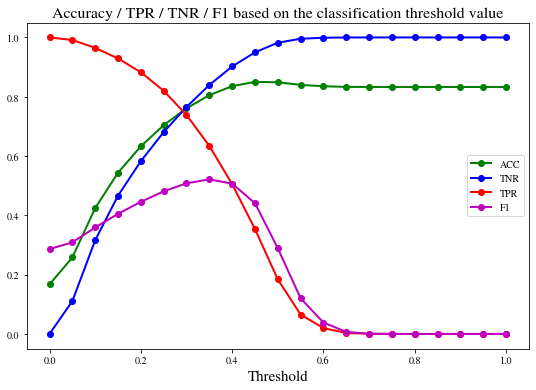

Chosen classification threshold is: 0.275
Edge labels: number of positive: 273744
Predictions: number of positive: 589988


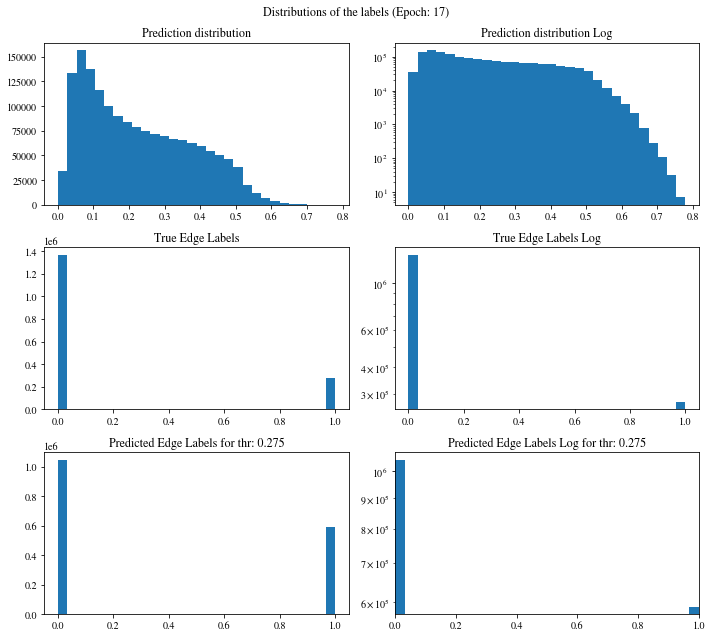

[0.50450224 0.34141591 0.14543213 ... 0.03535438 0.03141584 0.47943252]
Confusion matrix:
[[987645 376055]
 [ 59811 213933]]

Confusion matrix weighted:
[[0.3621196  0.1378804 ]
 [0.10924623 0.39075377]]

TN: 987645 	 FN: 59811 	 TP: 213933 	 FP: 376055
Confusion matrix scaled:
[[0.60316261 0.22965976]
 [0.03652705 0.13065057]]

Accuracy: 0.7338
Precision: 0.3626
Negative predictive value: 0.9429
Recall: Correctly classifying 78.1508 % of positive edges
True negative rate: Correctly classifying 72.4239 % of all negative edges
F1 score: 0.4954
[0.76823473 0.73917615] [0.7242392  0.78150754] [0.74558851 0.75975265]
Balanced accuracy: 0.7529
Precision weighted: [0.76823473 0.73917615]
Recall weighted: [0.7242392  0.78150754]
F1 score weighted: [0.74558851 0.75975265]
positive_likelihood_ratio: 2.834005217720136, negative_likelihood_ratio: 0.30168549210521417


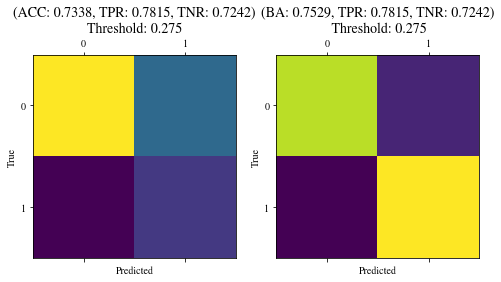

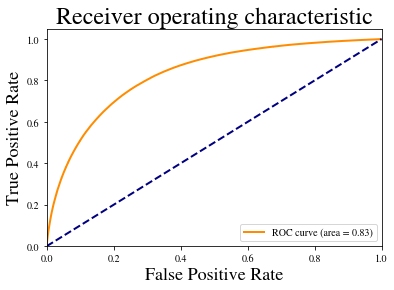

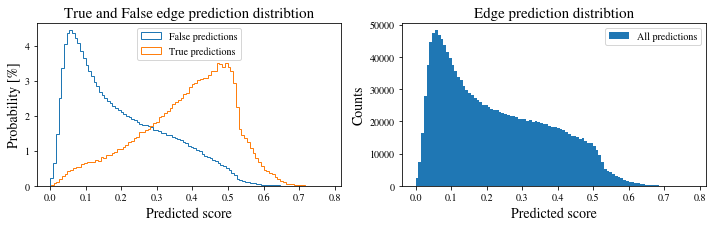

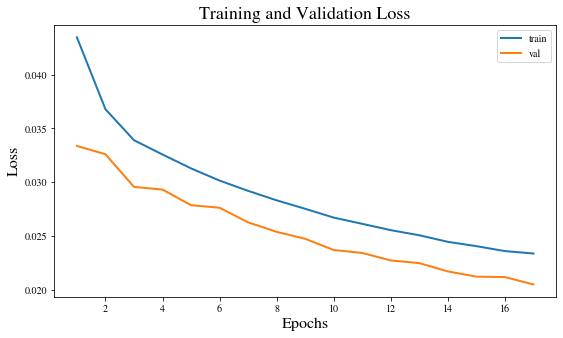

Training epoch 18: 100%|██████████| 20/20 [00:01<00:00, 17.06it/s]


Epoch: 18, train loss: 0.0230
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_18_loss_0.0230.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


Epoch: 18, val loss: 0.0205


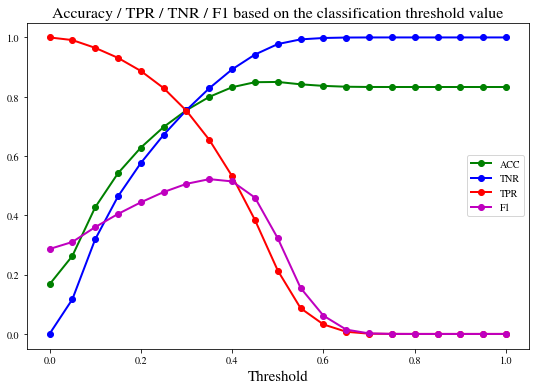

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 540077


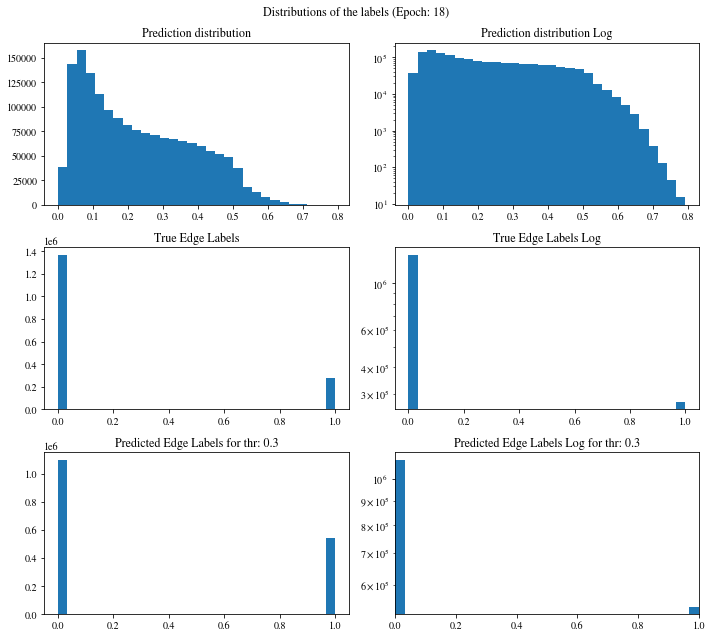

[0.46362802 0.05360156 0.3914831  ... 0.25570798 0.46123782 0.41225535]
Confusion matrix:
[[1029623  334077]
 [  67744  206000]]

Confusion matrix weighted:
[[0.37751082 0.12248918]
 [0.12373605 0.37626395]]

TN: 1029623 	 FN: 67744 	 TP: 206000 	 FP: 334077
Confusion matrix scaled:
[[0.62879891 0.20402347]
 [0.0413718  0.12580583]]

Accuracy: 0.7546
Precision: 0.3814
Negative predictive value: 0.9383
Recall: Correctly classifying 75.2528 % of positive edges
True negative rate: Correctly classifying 75.5022 % of all negative edges
F1 score: 0.5063
[0.7531435 0.7544092] [0.75502163 0.75252791] [0.7540814  0.75346738]
Balanced accuracy: 0.7538
Precision weighted: [0.7531435 0.7544092]
Recall weighted: [0.75502163 0.75252791]
F1 score weighted: [0.7540814  0.75346738]
positive_likelihood_ratio: 3.071813713291776, negative_likelihood_ratio: 0.3277682123501741


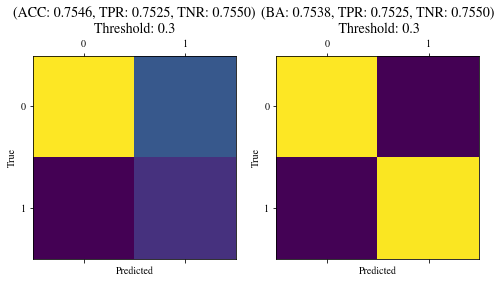

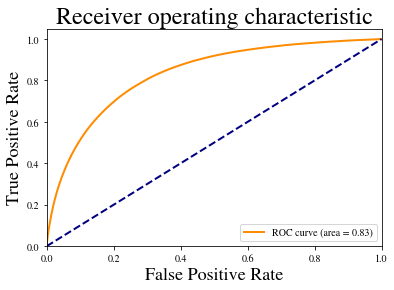

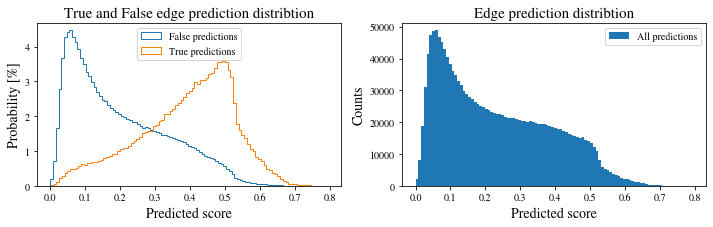

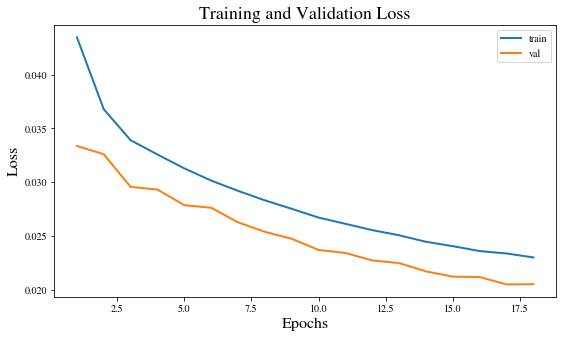

Training epoch 19: 100%|██████████| 20/20 [00:01<00:00, 17.40it/s]


Epoch: 19, train loss: 0.0228
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_19_loss_0.0228.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.53it/s]


Epoch: 19, val loss: 0.0202


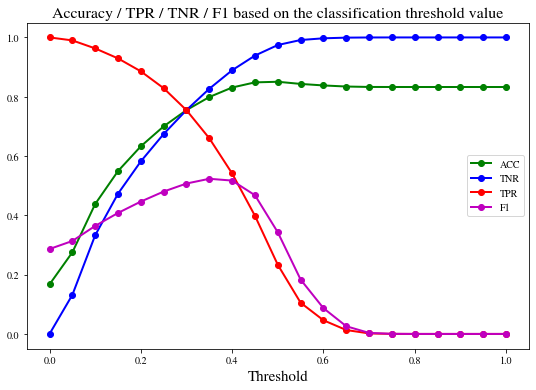

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 540585


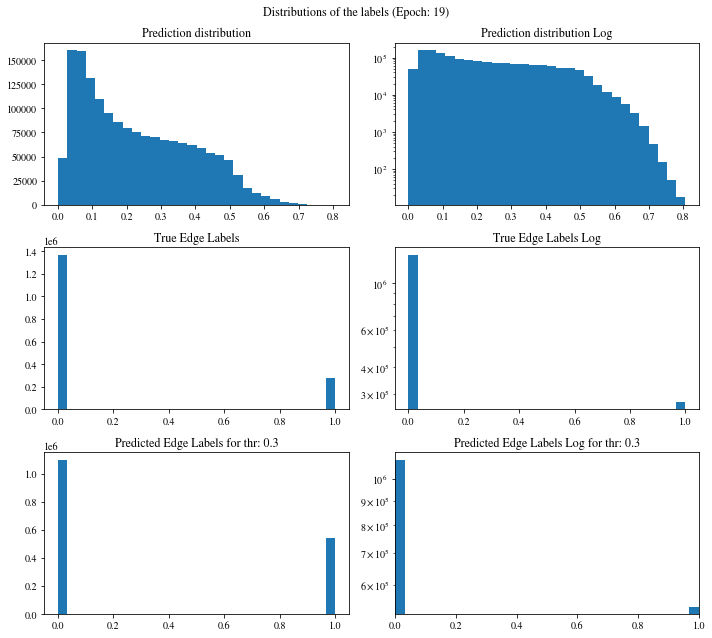

[0.51322544 0.33747515 0.13570076 ... 0.28388375 0.09657437 0.19418648]
Confusion matrix:
[[1029669  334031]
 [  67190  206554]]

Confusion matrix weighted:
[[0.37752768 0.12247232]
 [0.12272415 0.37727585]]

TN: 1029669 	 FN: 67190 	 TP: 206554 	 FP: 334031
Confusion matrix scaled:
[[0.628827   0.20399537]
 [0.04103346 0.12614416]]

Accuracy: 0.7550
Precision: 0.3821
Negative predictive value: 0.9387
Recall: Correctly classifying 75.4552 % of positive edges
True negative rate: Correctly classifying 75.5055 % of all negative edges
F1 score: 0.5073
[0.75467526 0.75493193] [0.75505536 0.7545517 ] [0.75486526 0.75474177]
Balanced accuracy: 0.7548
Precision weighted: [0.75467526 0.75493193]
Recall weighted: [0.75505536 0.7545517 ]
F1 score weighted: [0.75486526 0.75474177]
positive_likelihood_ratio: 3.0804989670909513, negative_likelihood_ratio: 0.3250732512328161


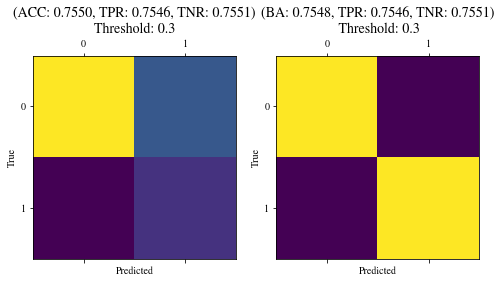

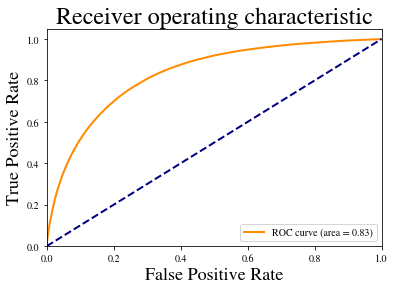

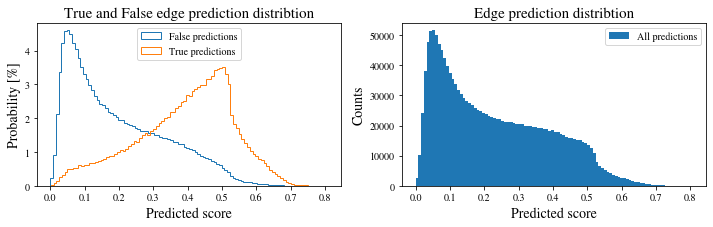

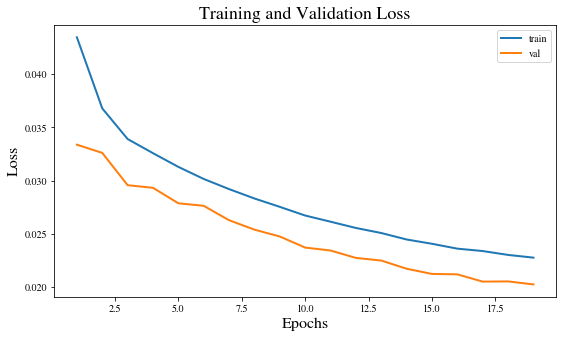

Training epoch 20: 100%|██████████| 20/20 [00:01<00:00, 17.06it/s]


Epoch: 20, train loss: 0.0225
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_20_loss_0.0225.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.66it/s]


Epoch: 20, val loss: 0.0199


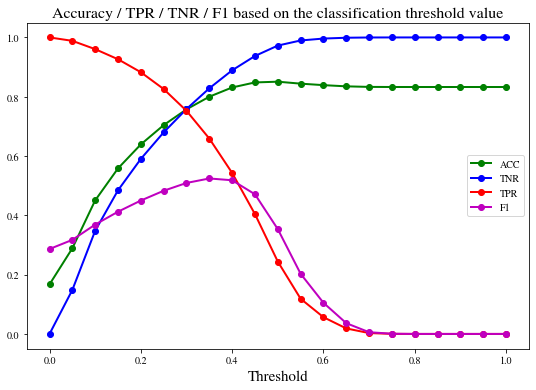

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 535357


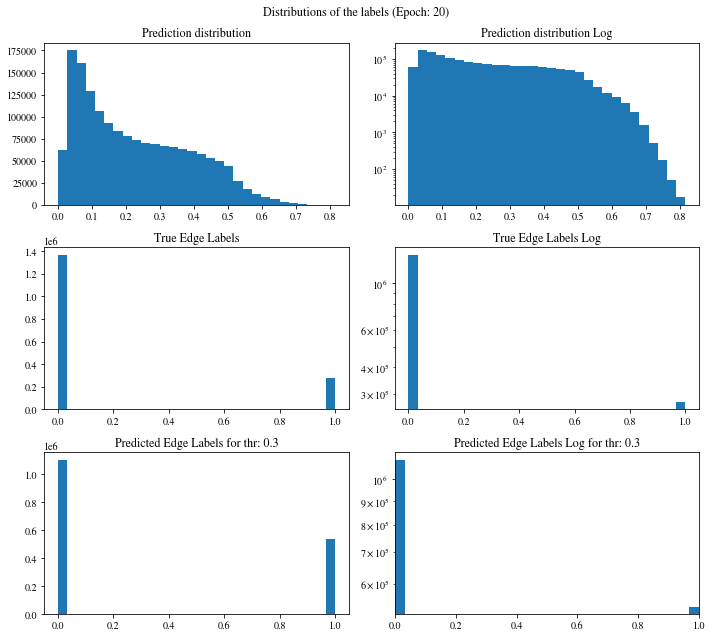

[0.44582352 0.56487203 0.52315629 ... 0.2844955  0.09292337 0.19300628]
Confusion matrix:
[[1034348  329352]
 [  67739  206005]]

Confusion matrix weighted:
[[0.37924324 0.12075676]
 [0.12372691 0.37627309]]

TN: 1034348 	 FN: 67739 	 TP: 206005 	 FP: 329352
Confusion matrix scaled:
[[0.6316845  0.20113787]
 [0.04136874 0.12580888]]

Accuracy: 0.7575
Precision: 0.3848
Negative predictive value: 0.9385
Recall: Correctly classifying 75.2546 % of positive edges
True negative rate: Correctly classifying 75.8486 % of all negative edges
F1 score: 0.5092
[0.75400744 0.75704324] [0.75848647 0.75254617] [0.75624032 0.75478801]
Balanced accuracy: 0.7555
Precision weighted: [0.75400744 0.75704324]
Recall weighted: [0.75848647 0.75254617]
F1 score weighted: [0.75624032 0.75478801]
positive_likelihood_ratio: 3.115958664905236, negative_likelihood_ratio: 0.3262468548265484


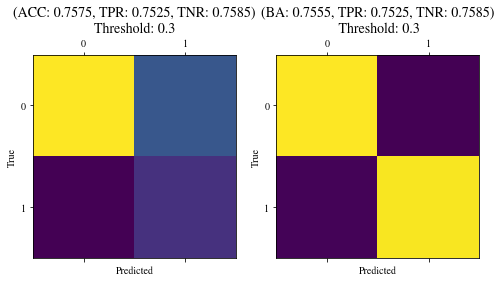

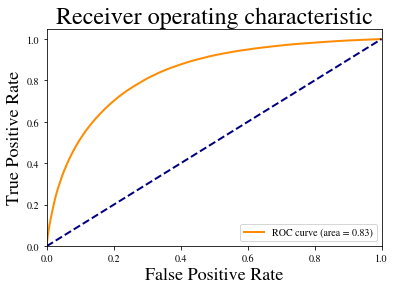

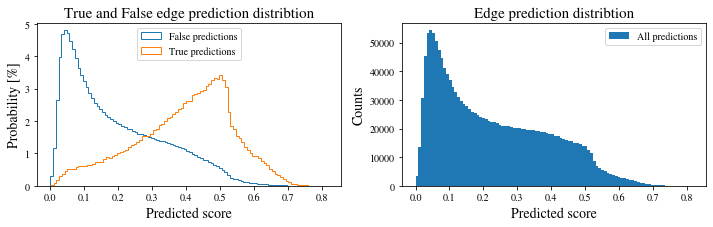

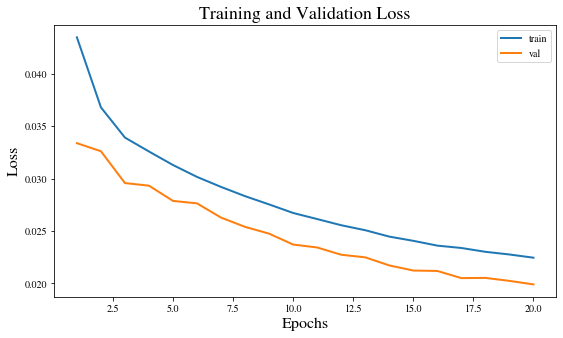

Training epoch 21: 100%|██████████| 20/20 [00:01<00:00, 16.89it/s]


Epoch: 21, train loss: 0.0223
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_21_loss_0.0223.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.55it/s]


Epoch: 21, val loss: 0.0199


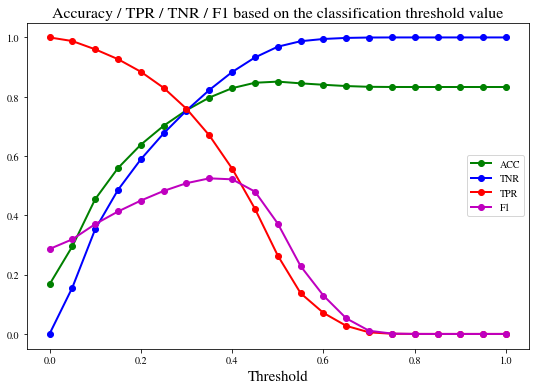

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 543917


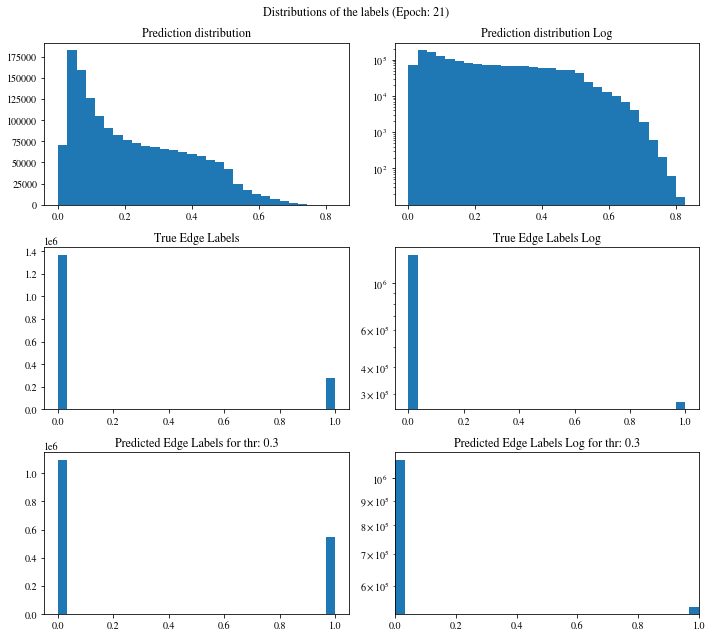

[0.47692484 0.03988636 0.21059342 ... 0.24685776 0.46868083 0.43556961]
Confusion matrix:
[[1027654  336046]
 [  65873  207871]]

Confusion matrix weighted:
[[0.37678888 0.12321112]
 [0.12031862 0.37968138]]

TN: 1027654 	 FN: 65873 	 TP: 207871 	 FP: 336046
Confusion matrix scaled:
[[0.62759642 0.20522595]
 [0.04022916 0.12694846]]

Accuracy: 0.7545
Precision: 0.3822
Negative predictive value: 0.9398
Recall: Correctly classifying 75.9363 % of positive edges
True negative rate: Correctly classifying 75.3578 % of all negative edges
F1 score: 0.5085
[0.75796258 0.75499512] [0.75357777 0.75936276] [0.75576381 0.75717264]
Balanced accuracy: 0.7565
Precision weighted: [0.75796258 0.75499512]
Recall weighted: [0.75357777 0.75936276]
F1 score weighted: [0.75576381 0.75717264]
positive_likelihood_ratio: 3.0815513320596284, negative_likelihood_ratio: 0.3193263501788443


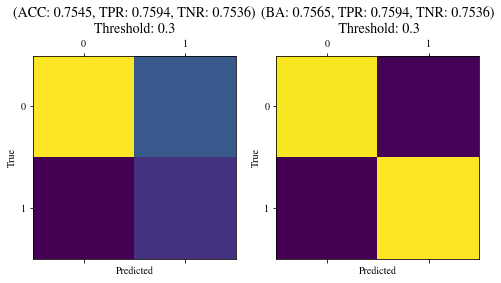

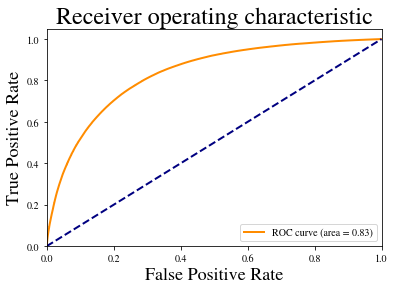

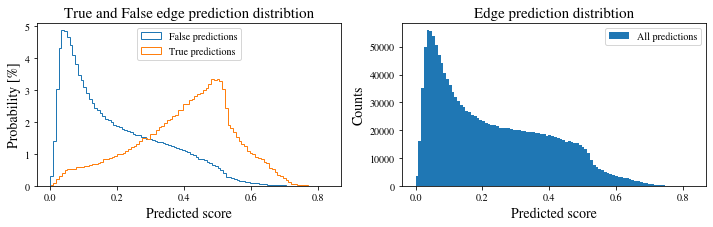

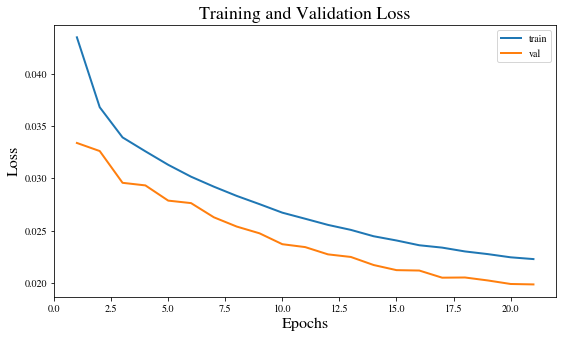

Training epoch 22: 100%|██████████| 20/20 [00:01<00:00, 16.91it/s]


Epoch: 22, train loss: 0.0221
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_22_loss_0.0221.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.46it/s]


Epoch: 22, val loss: 0.0197


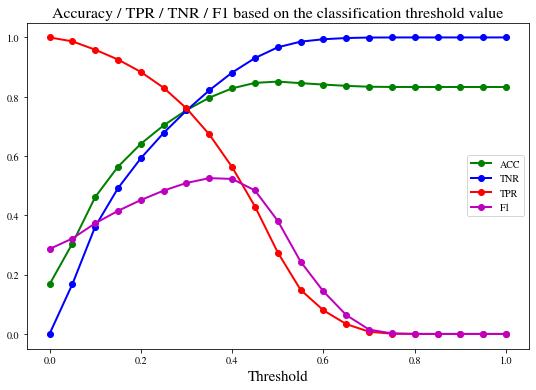

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 544203


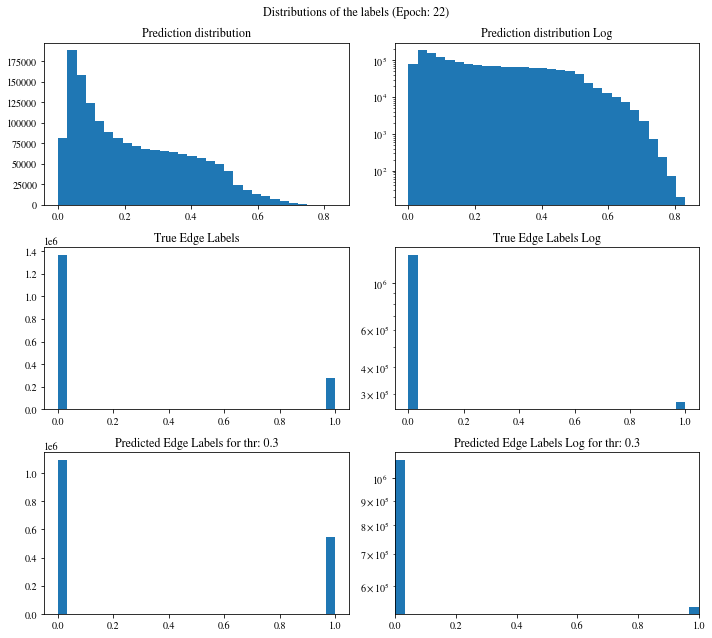

[0.63126361 0.51717746 0.4756467  ... 0.05127105 0.04589814 0.53325385]
Confusion matrix:
[[1027731  335969]
 [  65510  208234]]

Confusion matrix weighted:
[[0.37681712 0.12318288]
 [0.11965559 0.38034441]]

TN: 1027731 	 FN: 65510 	 TP: 208234 	 FP: 335969
Confusion matrix scaled:
[[0.62764345 0.20517893]
 [0.04000748 0.12717015]]

Accuracy: 0.7548
Precision: 0.3826
Negative predictive value: 0.9401
Recall: Correctly classifying 76.0689 % of positive edges
True negative rate: Correctly classifying 75.3634 % of all negative edges
F1 score: 0.5092
[0.75898858 0.75536006] [0.75363423 0.76068882] [0.75630193 0.75801508]
Balanced accuracy: 0.7572
Precision weighted: [0.75898858 0.75536006]
Recall weighted: [0.75363423 0.76068882]
F1 score weighted: [0.75630193 0.75801508]
positive_likelihood_ratio: 3.087640056463165, negative_likelihood_ratio: 0.3175428763656315


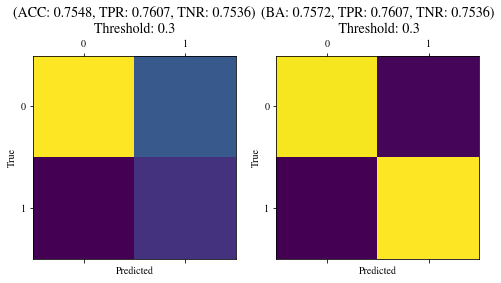

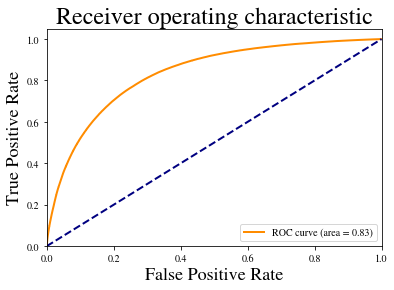

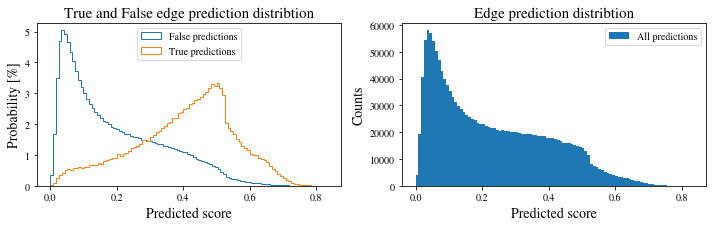

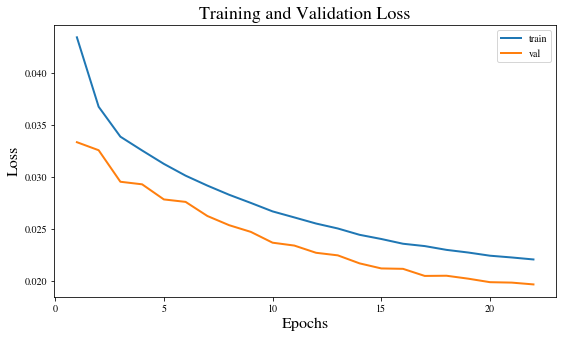

Training epoch 23: 100%|██████████| 20/20 [00:01<00:00, 16.84it/s]


Epoch: 23, train loss: 0.0219
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_23_loss_0.0219.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


Epoch: 23, val loss: 0.0197


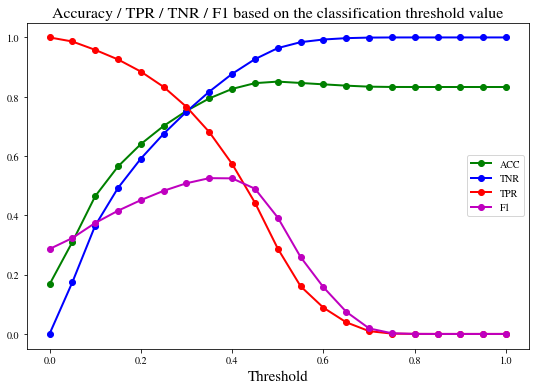

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 551100


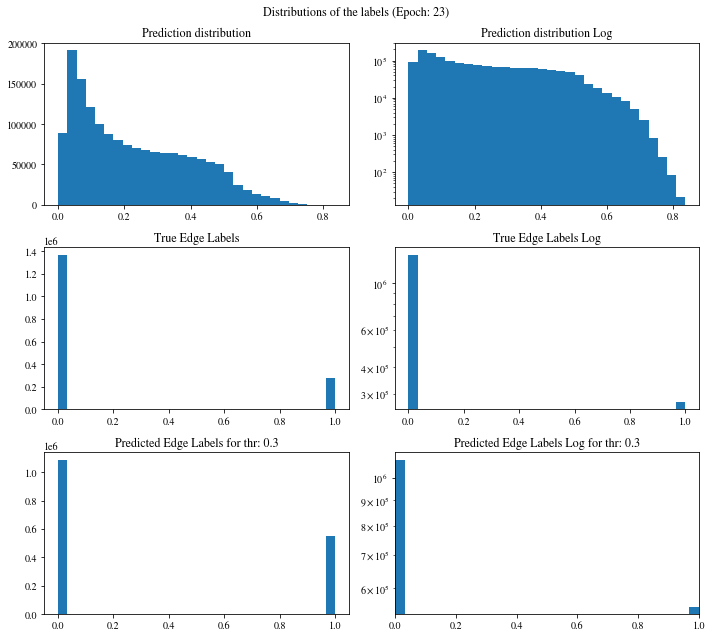

[0.449222   0.57777798 0.5297187  ... 0.2442582  0.47366226 0.44817367]
Confusion matrix:
[[1022219  341481]
 [  64125  209619]]

Confusion matrix weighted:
[[0.37479614 0.12520386]
 [0.11712585 0.38287415]]

TN: 1022219 	 FN: 64125 	 TP: 209619 	 FP: 341481
Confusion matrix scaled:
[[0.62427723 0.20854515]
 [0.03916164 0.12801598]]

Accuracy: 0.7523
Precision: 0.3804
Negative predictive value: 0.9410
Recall: Correctly classifying 76.5748 % of positive edges
True negative rate: Correctly classifying 74.9592 % of all negative edges
F1 score: 0.5083
[0.76190157 0.75357355] [0.74959229 0.76574829] [0.75569681 0.75961214]
Balanced accuracy: 0.7577
Precision weighted: [0.76190157 0.75357355]
Recall weighted: [0.74959229 0.76574829]
F1 score weighted: [0.75569681 0.75961214]
positive_likelihood_ratio: 3.05800599032545, negative_likelihood_ratio: 0.3125054967846175


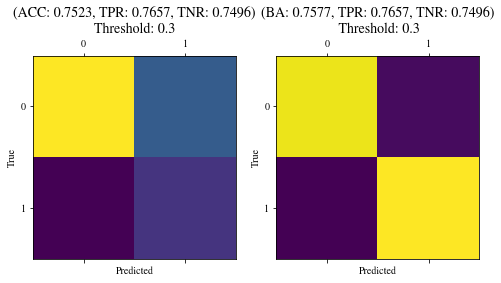

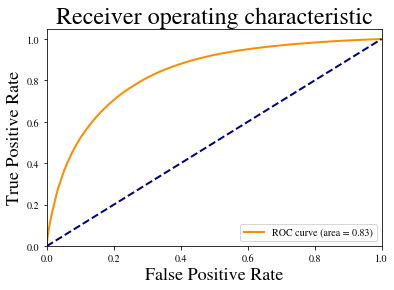

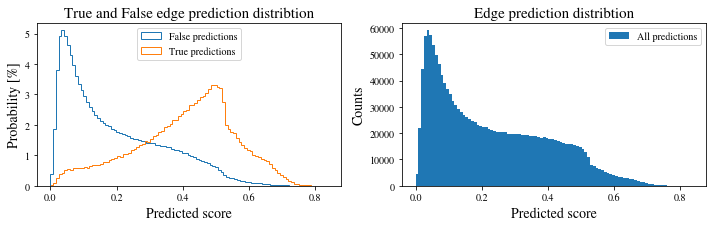

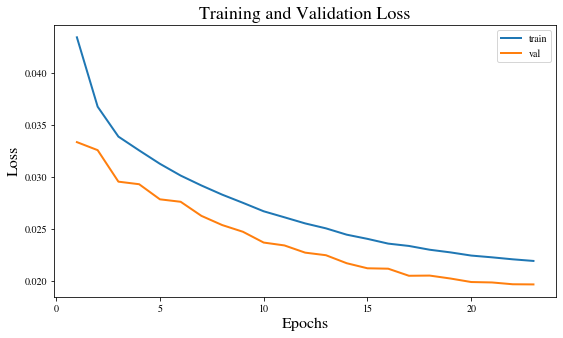

Training epoch 24: 100%|██████████| 20/20 [00:01<00:00, 17.48it/s]


Epoch: 24, train loss: 0.0218
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_24_loss_0.0218.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.11it/s]


Epoch: 24, val loss: 0.0195


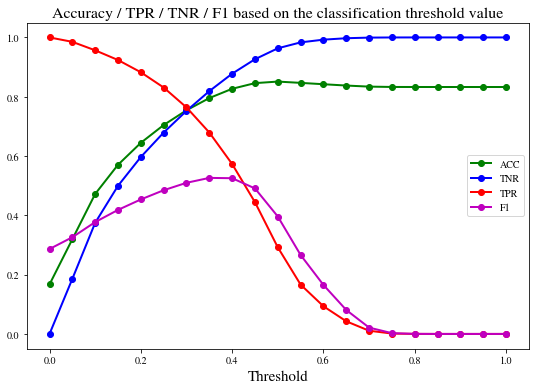

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 546857


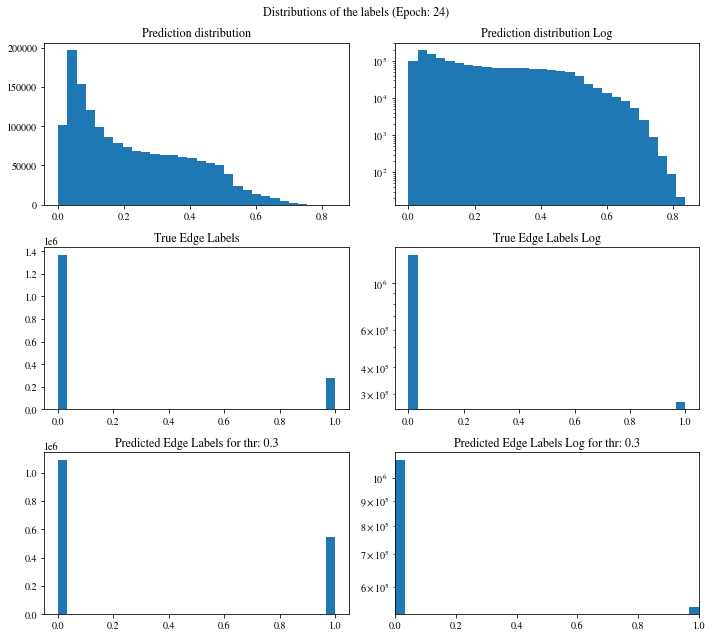

[0.44780383 0.58031285 0.53091198 ... 0.05730388 0.05187329 0.54364014]
Confusion matrix:
[[1025994  337706]
 [  64593  209151]]

Confusion matrix weighted:
[[0.37618024 0.12381976]
 [0.11798067 0.38201933]]

TN: 1025994 	 FN: 64593 	 TP: 209151 	 FP: 337706
Confusion matrix scaled:
[[0.62658265 0.20623972]
 [0.03944746 0.12773017]]

Accuracy: 0.7543
Precision: 0.3825
Negative predictive value: 0.9408
Recall: Correctly classifying 76.4039 % of positive edges
True negative rate: Correctly classifying 75.2360 % of all negative edges
F1 score: 0.5098
[0.76125051 0.75521908] [0.75236049 0.76403866] [0.75677939 0.75960327]
Balanced accuracy: 0.7582
Precision weighted: [0.76125051 0.75521908]
Recall weighted: [0.75236049 0.76403866]
F1 score weighted: [0.75677939 0.75960327]
positive_likelihood_ratio: 3.0852857986160065, negative_likelihood_ratio: 0.313628027154723


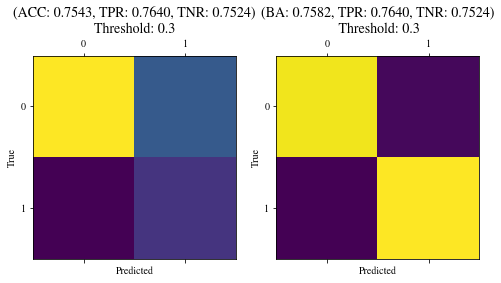

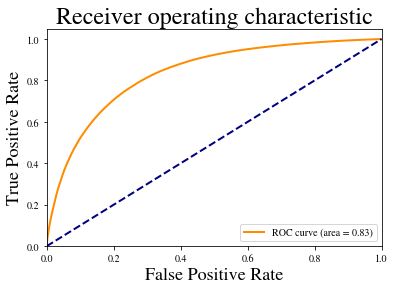

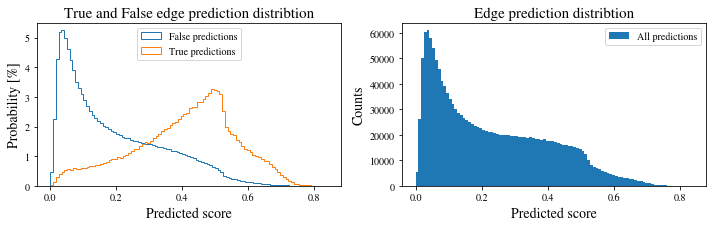

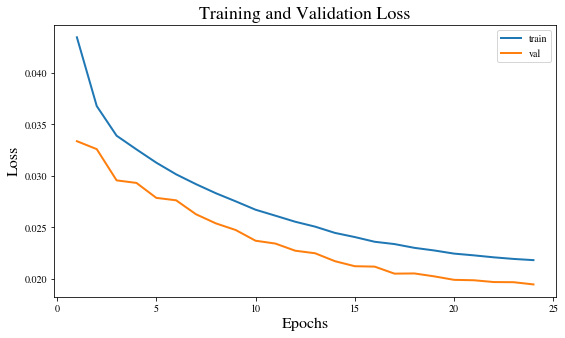

Training epoch 25: 100%|██████████| 20/20 [00:01<00:00, 17.78it/s]


Epoch: 25, train loss: 0.0217
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_25_loss_0.0217.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.32it/s]


Epoch: 25, val loss: 0.0193


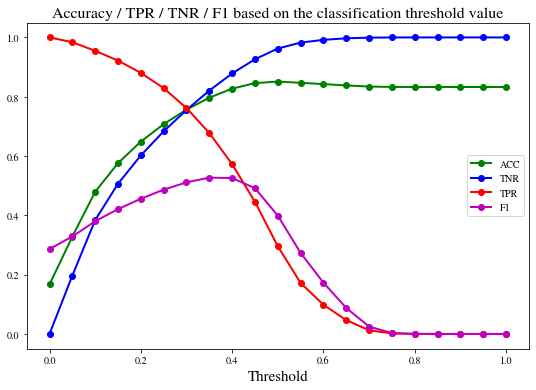

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 542233


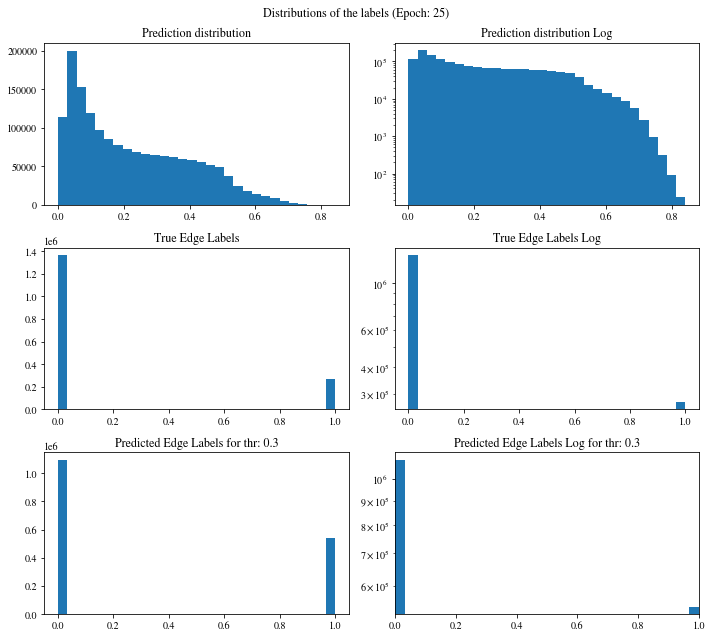

[0.51770425 0.32875741 0.11336634 ... 0.05689343 0.05067683 0.54625964]
Confusion matrix:
[[1030046  333654]
 [  65165  208579]]

Confusion matrix weighted:
[[0.37766591 0.12233409]
 [0.11902544 0.38097456]]

TN: 1030046 	 FN: 65165 	 TP: 208579 	 FP: 333654
Confusion matrix scaled:
[[0.62905724 0.20376514]
 [0.03979678 0.12738084]]

Accuracy: 0.7564
Precision: 0.3847
Negative predictive value: 0.9405
Recall: Correctly classifying 76.1949 % of positive edges
True negative rate: Correctly classifying 75.5332 % of all negative edges
F1 score: 0.5112
[0.76036337 0.75694022] [0.75533182 0.76194912] [0.75783924 0.75943641]
Balanced accuracy: 0.7586
Precision weighted: [0.76036337 0.75694022]
Recall weighted: [0.75533182 0.76194912]
F1 score weighted: [0.75783924 0.75943641]
positive_likelihood_ratio: 3.114214172213919, negative_likelihood_ratio: 0.3151606671781037


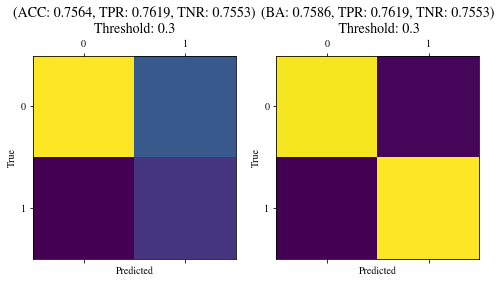

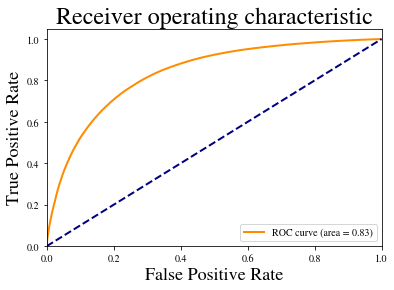

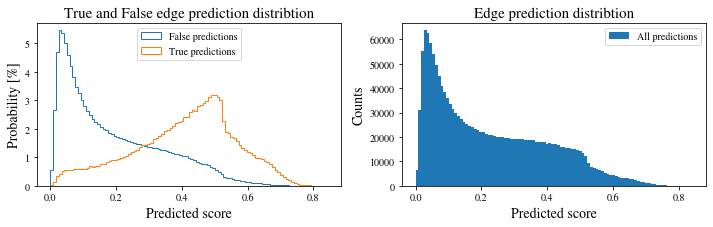

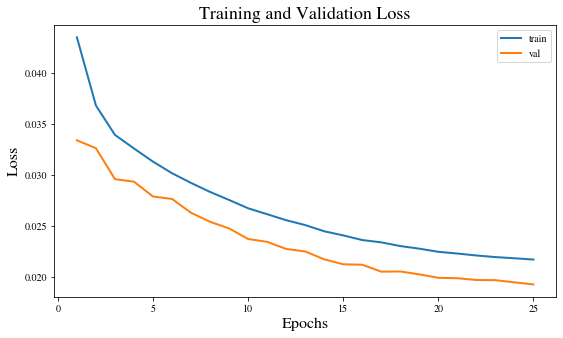

Training epoch 26: 100%|██████████| 20/20 [00:01<00:00, 16.90it/s]


Epoch: 26, train loss: 0.0215
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_26_loss_0.0215.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.06it/s]


Epoch: 26, val loss: 0.0193


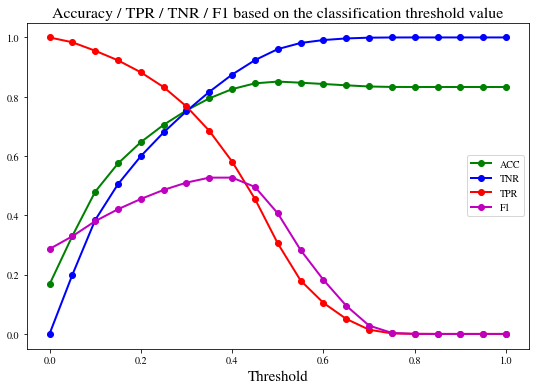

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 549060


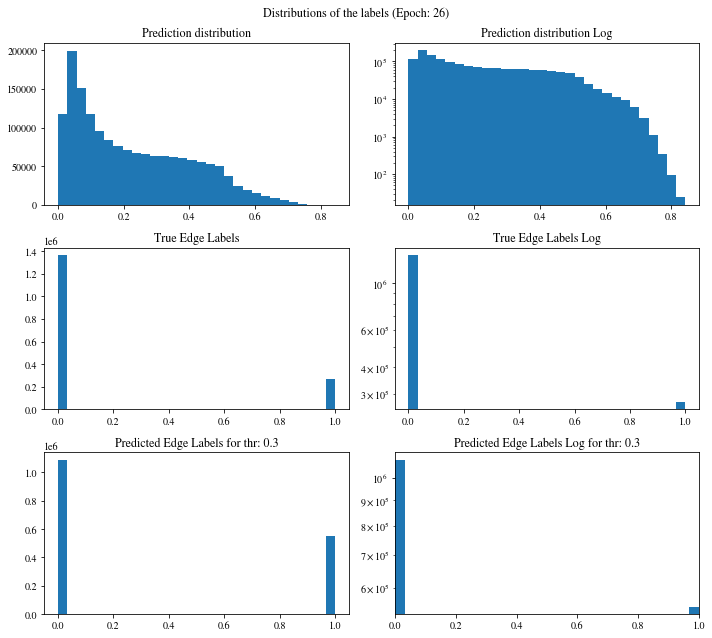

[0.64798933 0.52362853 0.48112386 ... 0.06706878 0.19138625 0.63084787]
Confusion matrix:
[[1024633  339067]
 [  63751  209993]]

Confusion matrix weighted:
[[0.37568123 0.12431877]
 [0.11644273 0.38355727]]

TN: 1024633 	 FN: 63751 	 TP: 209993 	 FP: 339067
Confusion matrix scaled:
[[0.62575148 0.2070709 ]
 [0.03893324 0.12824439]]

Accuracy: 0.7540
Precision: 0.3825
Negative predictive value: 0.9414
Recall: Correctly classifying 76.7115 % of positive edges
True negative rate: Correctly classifying 75.1362 % of all negative edges
F1 score: 0.5104
[0.76338739 0.75521829] [0.75136247 0.76711453] [0.7573272  0.76111993]
Balanced accuracy: 0.7592
Precision weighted: [0.76338739 0.75521829]
Recall weighted: [0.75136247 0.76711453]
F1 score weighted: [0.7573272  0.76111993]
positive_likelihood_ratio: 3.085272483189376, negative_likelihood_ratio: 0.3099508945568101


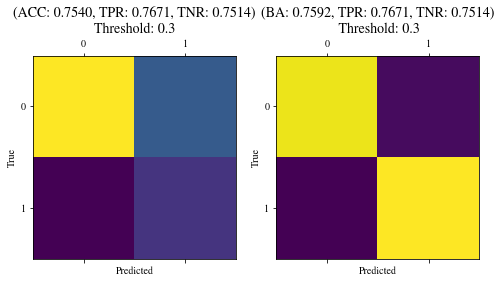

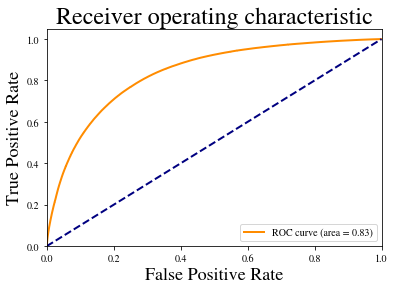

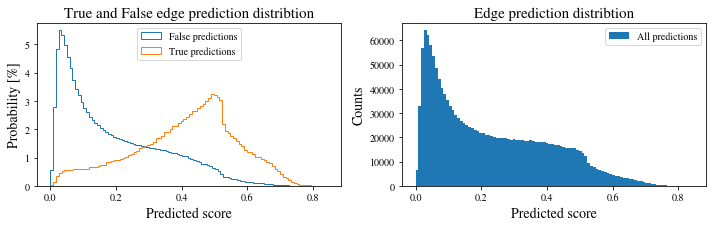

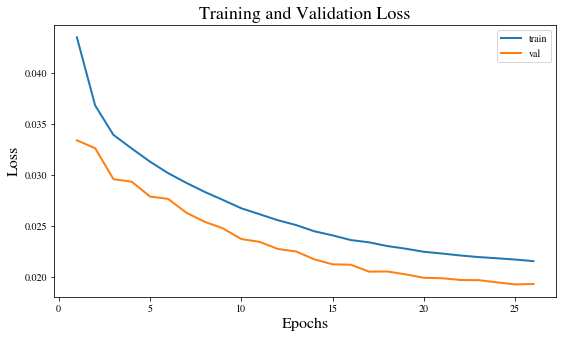

Training epoch 27: 100%|██████████| 20/20 [00:01<00:00, 17.31it/s]


Epoch: 27, train loss: 0.0215
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_27_loss_0.0215.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.70it/s]


Epoch: 27, val loss: 0.0193


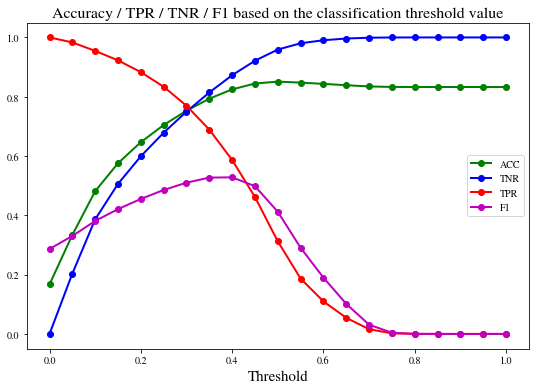

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 552162


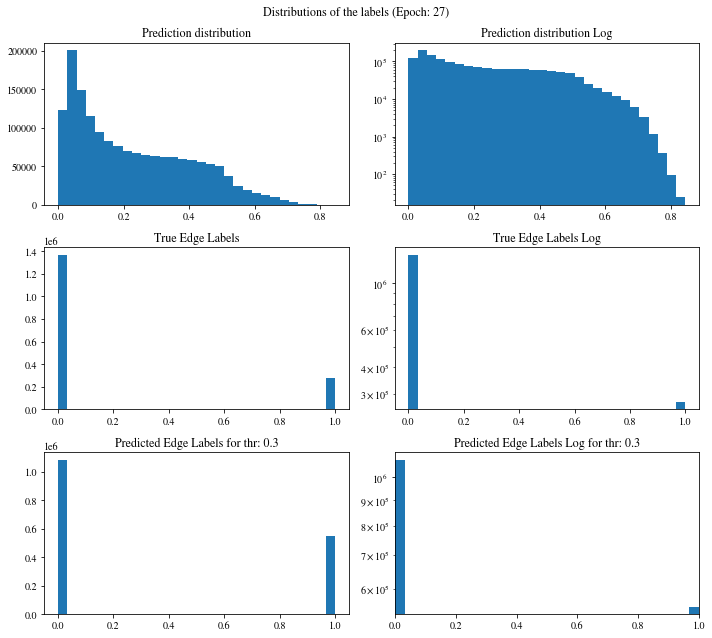

[0.50335413 0.03187931 0.20283537 ... 0.23653682 0.48387378 0.45954138]
Confusion matrix:
[[1022201  341499]
 [  63081  210663]]

Confusion matrix weighted:
[[0.37478954 0.12521046]
 [0.11521896 0.38478104]]

TN: 1022201 	 FN: 63081 	 TP: 210663 	 FP: 341499
Confusion matrix scaled:
[[0.62426623 0.20855614]
 [0.03852407 0.12865356]]

Accuracy: 0.7529
Precision: 0.3815
Negative predictive value: 0.9419
Recall: Correctly classifying 76.9562 % of positive edges
True negative rate: Correctly classifying 74.9579 % of all negative edges
F1 score: 0.5101
[0.76486334 0.75448521] [0.74957909 0.76956207] [0.75714409 0.76194906]
Balanced accuracy: 0.7596
Precision weighted: [0.76486334 0.75448521]
Recall weighted: [0.74957909 0.76956207]
F1 score weighted: [0.75714409 0.76194906]
positive_likelihood_ratio: 3.0730742942016853, negative_likelihood_ratio: 0.3074231013317525


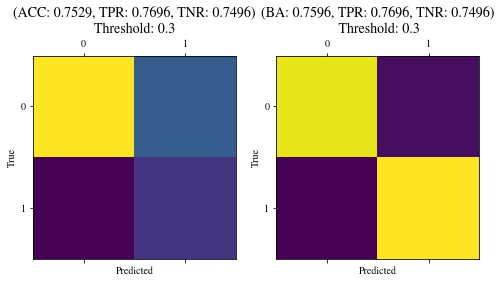

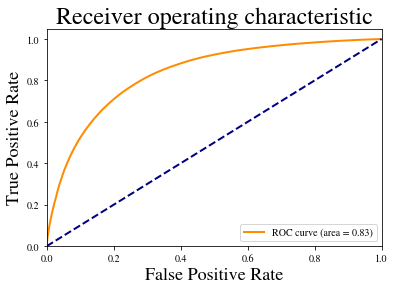

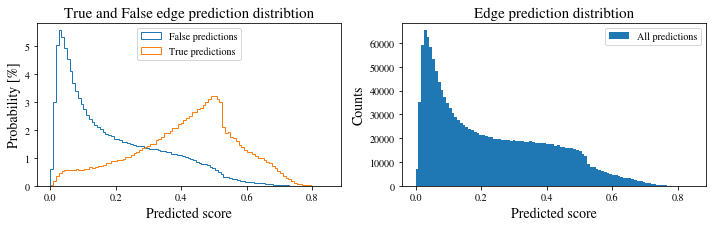

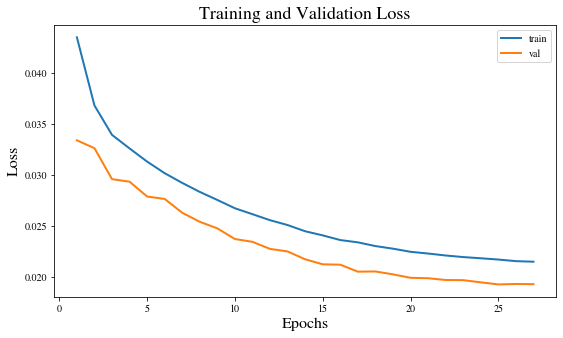

Training epoch 28: 100%|██████████| 20/20 [00:01<00:00, 16.87it/s]


Epoch: 28, train loss: 0.0215
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_28_loss_0.0215.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.19it/s]


Epoch: 28, val loss: 0.0192


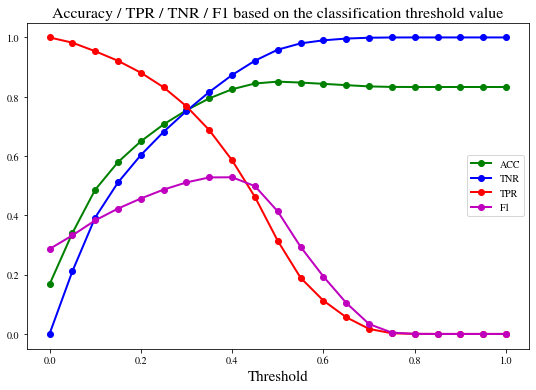

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 548436


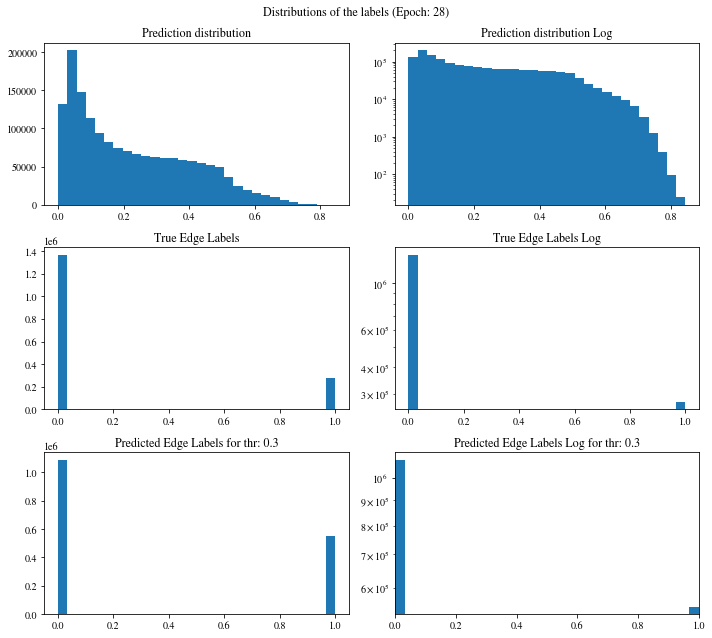

[0.44767293 0.58880866 0.53489637 ... 0.06304749 0.0555786  0.55541205]
Confusion matrix:
[[1025394  338306]
 [  63614  210130]]

Confusion matrix weighted:
[[0.37596026 0.12403974]
 [0.1161925  0.3838075 ]]

TN: 1025394 	 FN: 63614 	 TP: 210130 	 FP: 338306
Confusion matrix scaled:
[[0.62621622 0.20660615]
 [0.03884957 0.12832805]]

Accuracy: 0.7545
Precision: 0.3831
Negative predictive value: 0.9416
Recall: Correctly classifying 76.7615 % of positive edges
True negative rate: Correctly classifying 75.1921 % of all negative edges
F1 score: 0.5112
[0.76390968 0.75575383] [0.75192051 0.767615  ] [0.75786768 0.76163824]
Balanced accuracy: 0.7598
Precision weighted: [0.76390968 0.75575383]
Recall weighted: [0.75192051 0.767615  ]
F1 score weighted: [0.75786768 0.76163824]
positive_likelihood_ratio: 3.094229995064437, negative_likelihood_ratio: 0.3090552775710903


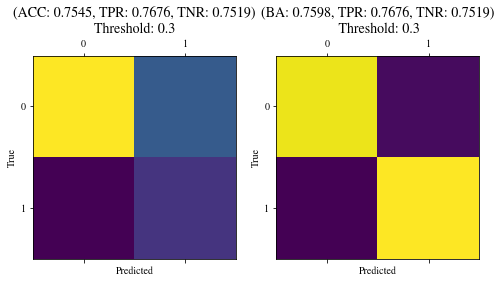

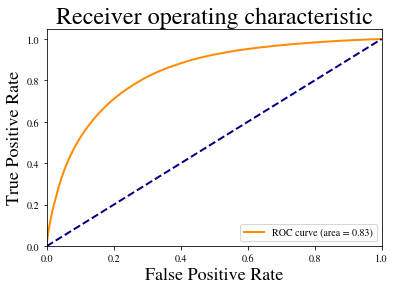

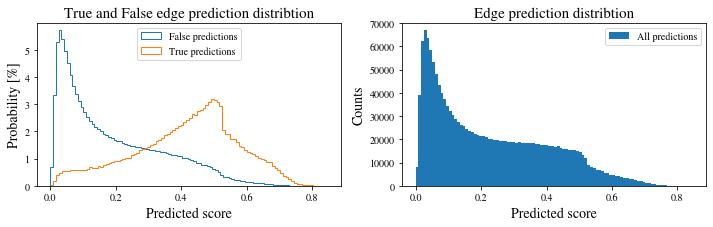

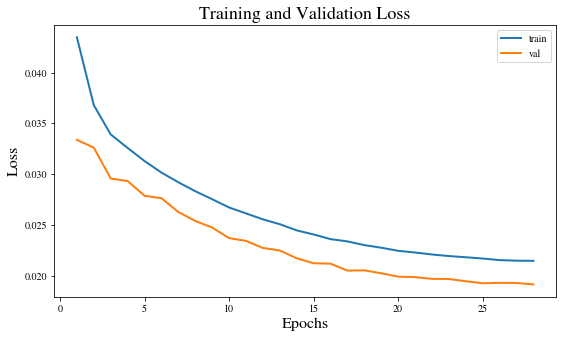

Training epoch 29: 100%|██████████| 20/20 [00:01<00:00, 17.04it/s]


Epoch: 29, train loss: 0.0214
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_29_loss_0.0214.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.35it/s]


Epoch: 29, val loss: 0.0191


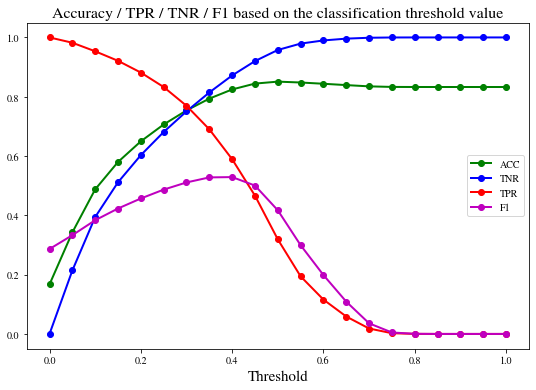

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 550756


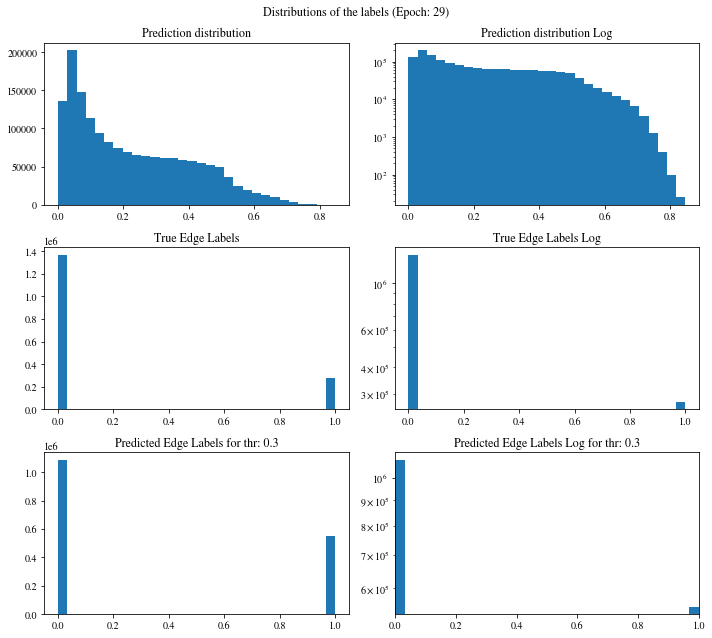

[0.44809762 0.59039342 0.53549296 ... 0.30571854 0.08643518 0.20186402]
Confusion matrix:
[[1023586  340114]
 [  63102  210642]]

Confusion matrix weighted:
[[0.37529735 0.12470265]
 [0.11525732 0.38474268]]

TN: 1023586 	 FN: 63102 	 TP: 210642 	 FP: 340114
Confusion matrix scaled:
[[0.62511206 0.20771031]
 [0.03853689 0.12864074]]

Accuracy: 0.7538
Precision: 0.3825
Negative predictive value: 0.9419
Recall: Correctly classifying 76.9485 % of positive edges
True negative rate: Correctly classifying 75.0595 % of all negative edges
F1 score: 0.5110
[0.76504694 0.75521878] [0.75059471 0.76948536] [0.75775192 0.76228532]
Balanced accuracy: 0.7600
Precision weighted: [0.76504694 0.75521878]
Recall weighted: [0.75059471 0.76948536]
F1 score weighted: [0.75775192 0.76228532]
positive_likelihood_ratio: 3.0852807690948105, negative_likelihood_ratio: 0.30710933570807697


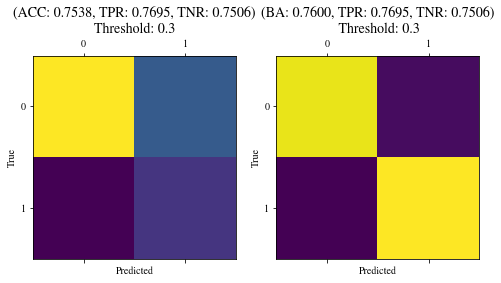

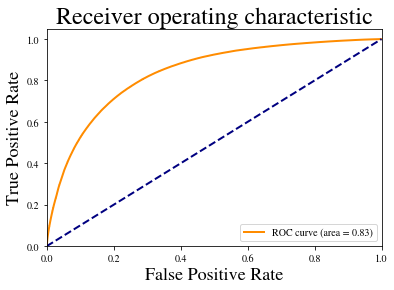

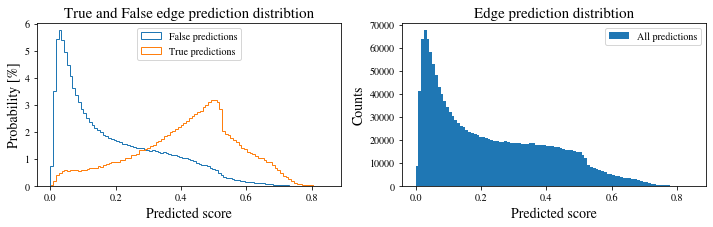

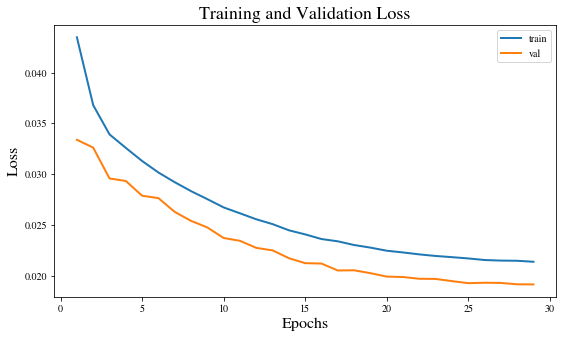

Training epoch 30: 100%|██████████| 20/20 [00:01<00:00, 17.46it/s]


Epoch: 30, train loss: 0.0213
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_30_loss_0.0213.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


Epoch: 30, val loss: 0.0191


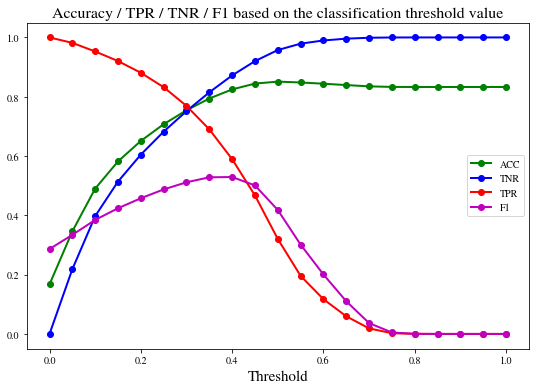

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 549499


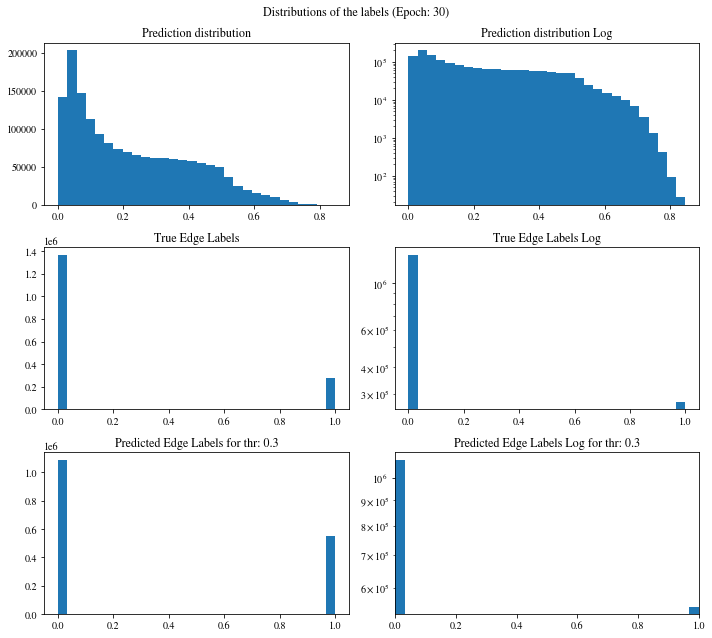

[0.51070338 0.02891897 0.19941327 ... 0.23187748 0.49011612 0.46268281]
Confusion matrix:
[[1024737  338963]
 [  63208  210536]]

Confusion matrix weighted:
[[0.37571937 0.12428063]
 [0.11545093 0.38454907]]

TN: 1024737 	 FN: 63208 	 TP: 210536 	 FP: 338963
Confusion matrix scaled:
[[0.62581499 0.20700738]
 [0.03860163 0.128576  ]]

Accuracy: 0.7544
Precision: 0.3831
Negative predictive value: 0.9419
Recall: Correctly classifying 76.9098 % of positive edges
True negative rate: Correctly classifying 75.1439 % of all negative edges
F1 score: 0.5115
[0.76494724 0.75575201] [0.75143873 0.76909814] [0.75813282 0.76236667]
Balanced accuracy: 0.7603
Precision weighted: [0.76494724 0.75575201]
Recall weighted: [0.75143873 0.76909814]
F1 score weighted: [0.75813282 0.76236667]
positive_likelihood_ratio: 3.09419944760894, negative_likelihood_ratio: 0.3072796948291424


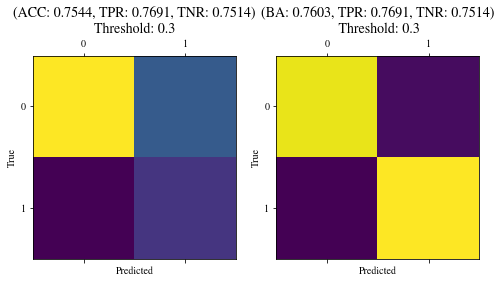

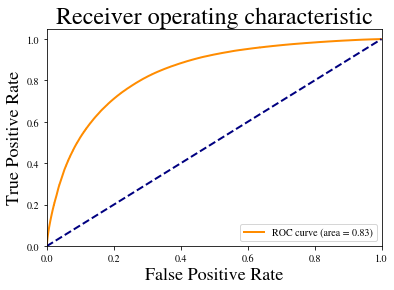

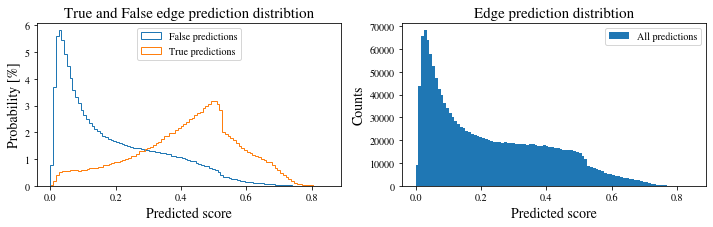

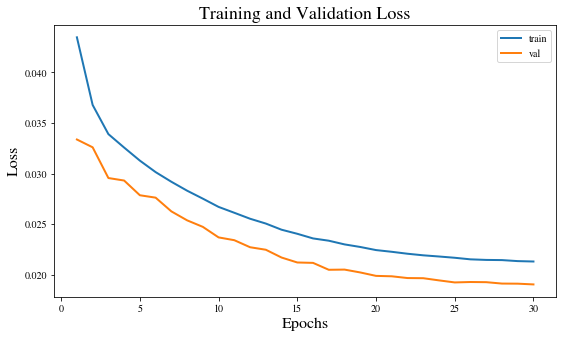

Training epoch 31: 100%|██████████| 20/20 [00:01<00:00, 17.19it/s]


Epoch: 31, train loss: 0.0213
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_31_loss_0.0213.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s]


Epoch: 31, val loss: 0.0191


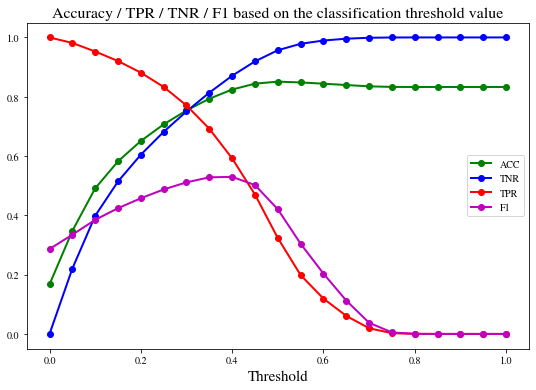

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 496908


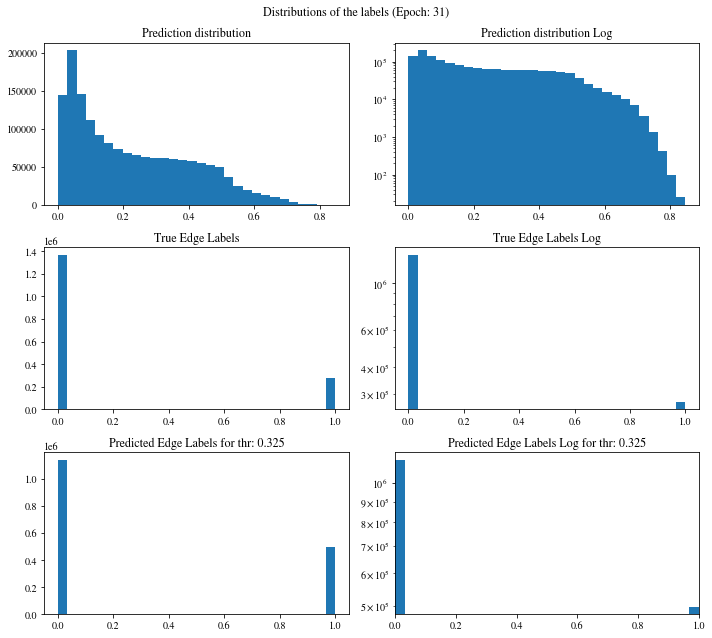

[0.51372564 0.02840288 0.19937944 ... 0.23167482 0.49205229 0.46462476]
Confusion matrix:
[[1067619  296081]
 [  72917  200827]]

Confusion matrix weighted:
[[0.39144203 0.10855797]
 [0.13318465 0.36681535]]

TN: 1067619 	 FN: 72917 	 TP: 200827 	 FP: 296081
Confusion matrix scaled:
[[0.65200337 0.18081901]
 [0.04453099 0.12264664]]

Accuracy: 0.7747
Precision: 0.4042
Negative predictive value: 0.9361
Recall: Correctly classifying 73.3631 % of positive edges
True negative rate: Correctly classifying 78.2884 % of all negative edges
F1 score: 0.5212
[0.74613443 0.77163639] [0.78288407 0.73363069] [0.76406761 0.75215375]
Balanced accuracy: 0.7583
Precision weighted: [0.74613443 0.77163639]
Recall weighted: [0.78288407 0.73363069]
F1 score weighted: [0.76406761 0.75215375]
positive_likelihood_ratio: 3.3789813393258137, negative_likelihood_ratio: 0.3402410654653708


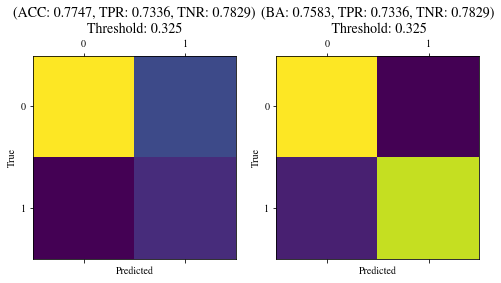

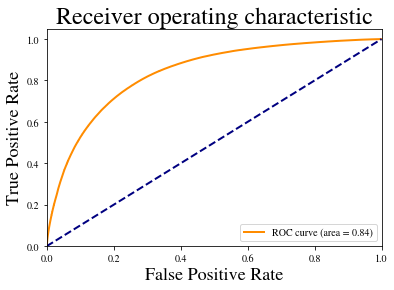

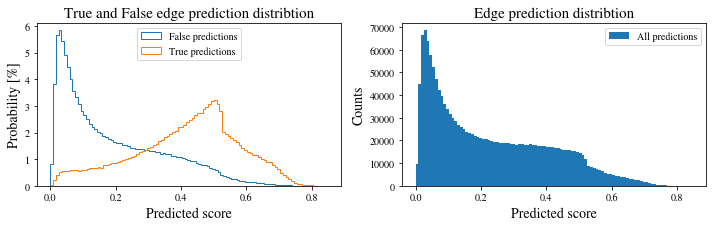

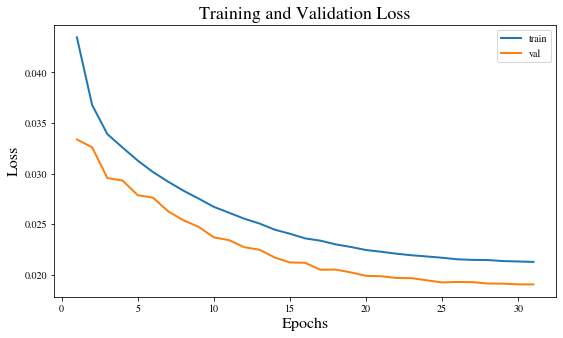

Training epoch 32: 100%|██████████| 20/20 [00:01<00:00, 17.92it/s]


Epoch: 32, train loss: 0.0212
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_32_loss_0.0212.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.45it/s]


Epoch: 32, val loss: 0.0190


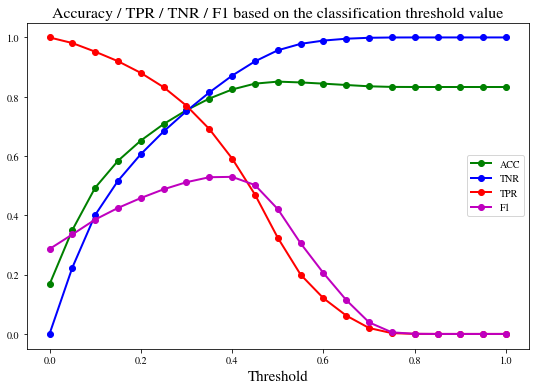

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 549477


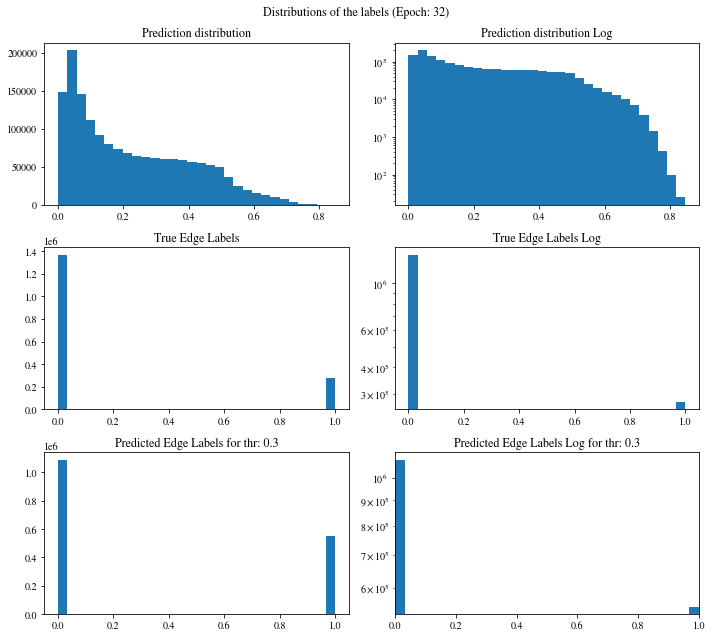

[0.50114644 0.02578894 0.3973293  ... 0.23020498 0.49296305 0.46461442]
Confusion matrix:
[[1024903  338797]
 [  63064  210680]]

Confusion matrix weighted:
[[0.37578023 0.12421977]
 [0.11518791 0.38481209]]

TN: 1024903 	 FN: 63064 	 TP: 210680 	 FP: 338797
Confusion matrix scaled:
[[0.62591637 0.20690601]
 [0.03851368 0.12866394]]

Accuracy: 0.7546
Precision: 0.3834
Negative predictive value: 0.9420
Recall: Correctly classifying 76.9624 % of positive edges
True negative rate: Correctly classifying 75.1560 % of all negative edges
F1 score: 0.5118
[0.76538618 0.75596857] [0.75156046 0.76962417] [0.75841031 0.76273526]
Balanced accuracy: 0.7606
Precision weighted: [0.76538618 0.75596857]
Recall weighted: [0.75156046 0.76962417]
F1 score weighted: [0.75841031 0.76273526]
positive_likelihood_ratio: 3.0978328811779803, negative_likelihood_ratio: 0.3065299968441344


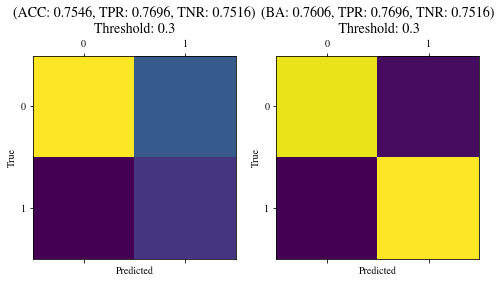

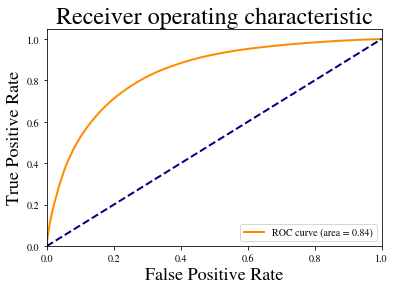

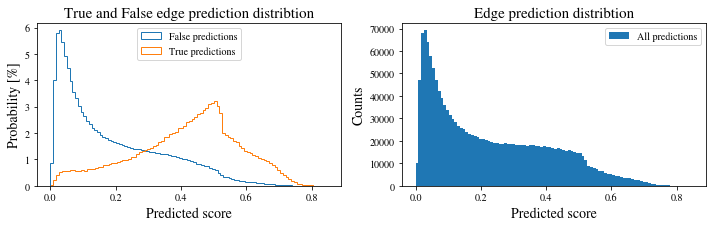

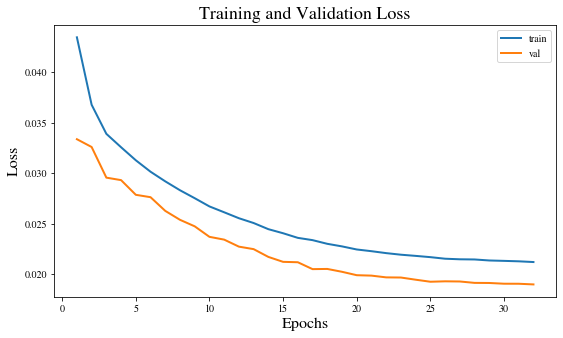

Training epoch 33: 100%|██████████| 20/20 [00:01<00:00, 16.38it/s]


Epoch: 33, train loss: 0.0212
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_33_loss_0.0212.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.80it/s]


Epoch: 33, val loss: 0.0190


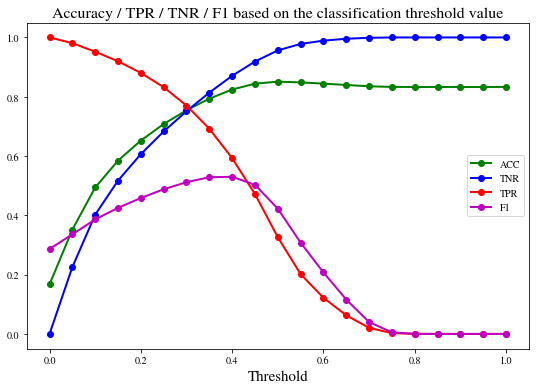

Chosen classification threshold is: 0.3
Edge labels: number of positive: 273744
Predictions: number of positive: 550219


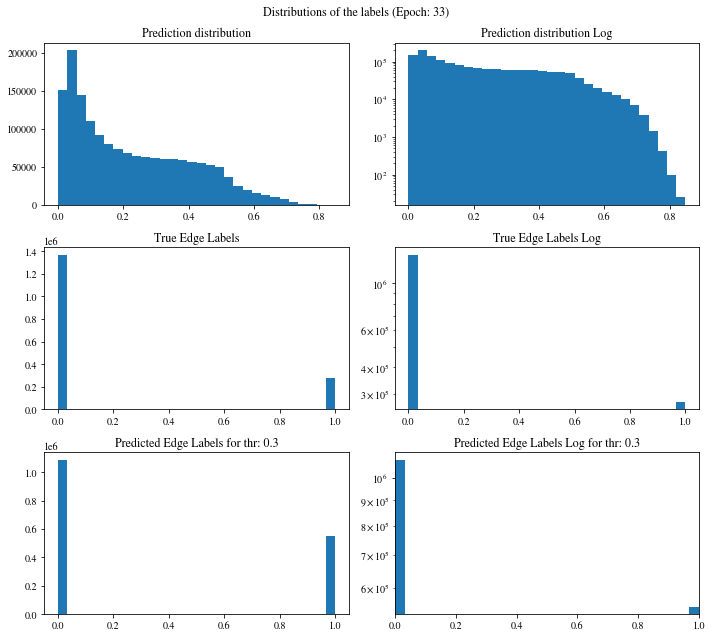

[0.51639891 0.02748763 0.19808152 ... 0.35488293 0.22418487 0.37617376]
Confusion matrix:
[[1024334  339366]
 [  62891  210853]]

Confusion matrix weighted:
[[0.37557161 0.12442839]
 [0.11487192 0.38512808]]

TN: 1024334 	 FN: 62891 	 TP: 210853 	 FP: 339366
Confusion matrix scaled:
[[0.62556887 0.2072535 ]
 [0.03840803 0.12876959]]

Accuracy: 0.7543
Precision: 0.3832
Negative predictive value: 0.9422
Recall: Correctly classifying 77.0256 % of positive edges
True negative rate: Correctly classifying 75.1143 % of all negative edges
F1 score: 0.5118
[0.76577951 0.75581039] [0.75114321 0.77025615] [0.75839075 0.7629649 ]
Balanced accuracy: 0.7607
Precision weighted: [0.76577951 0.75581039]
Recall weighted: [0.75114321 0.77025615]
F1 score weighted: [0.75839075 0.7629649 ]
positive_likelihood_ratio: 3.0951784036064316, negative_likelihood_ratio: 0.3058589150430423


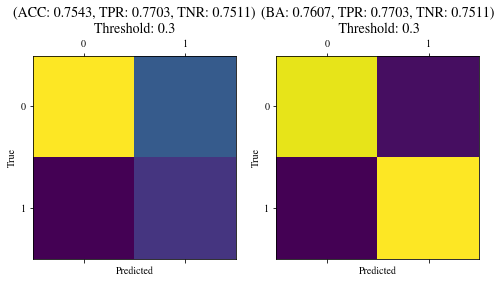

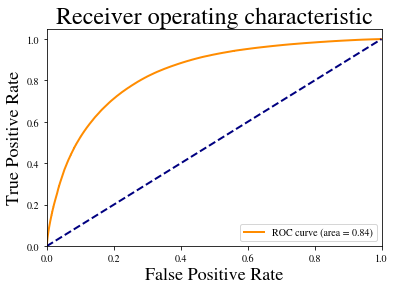

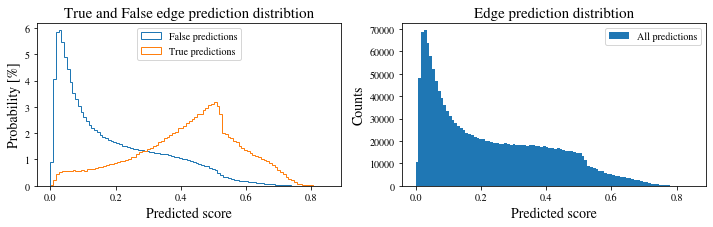

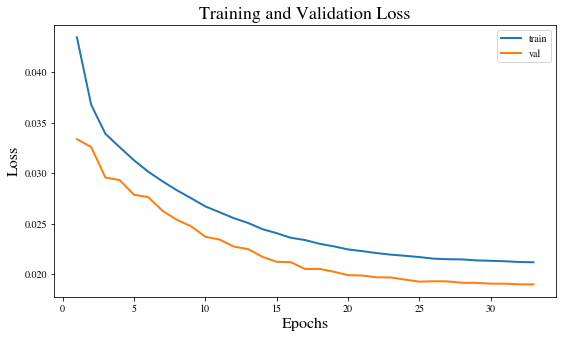

Training epoch 34: 100%|██████████| 20/20 [00:01<00:00, 17.66it/s]


Epoch: 34, train loss: 0.0212
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_34_loss_0.0212.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.20it/s]


Epoch: 34, val loss: 0.0190


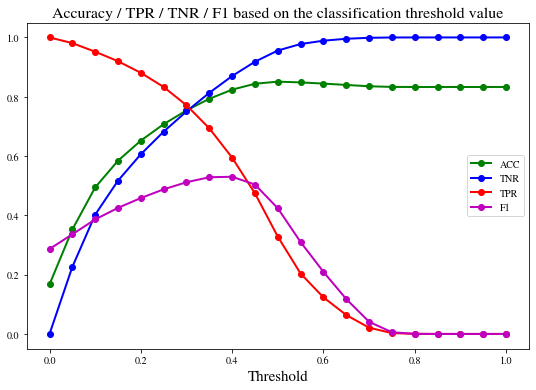

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497663


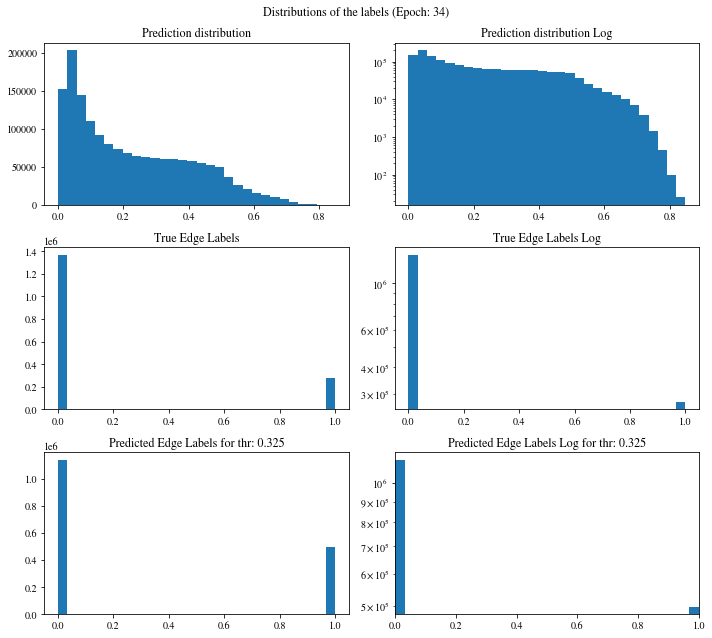

[0.65893722 0.52487749 0.48220912 ... 0.06915002 0.05989416 0.56096196]
Confusion matrix:
[[1067148  296552]
 [  72633  201111]]

Confusion matrix weighted:
[[0.39126934 0.10873066]
 [0.13266592 0.36733408]]

TN: 1067148 	 FN: 72633 	 TP: 201111 	 FP: 296552
Confusion matrix scaled:
[[0.65171572 0.18110665]
 [0.04435755 0.12282008]]

Accuracy: 0.7745
Precision: 0.4041
Negative predictive value: 0.9363
Recall: Correctly classifying 73.4668 % of positive edges
True negative rate: Correctly classifying 78.2539 % of all negative edges
F1 score: 0.5214
[0.74678948 0.77160531] [0.78253868 0.73466816] [0.76424625 0.75268384]
Balanced accuracy: 0.7586
Precision weighted: [0.74678948 0.77160531]
Recall weighted: [0.78253868 0.73466816]
F1 score weighted: [0.76424625 0.75268384]
positive_likelihood_ratio: 3.378385463093509, negative_likelihood_ratio: 0.3390654662227673


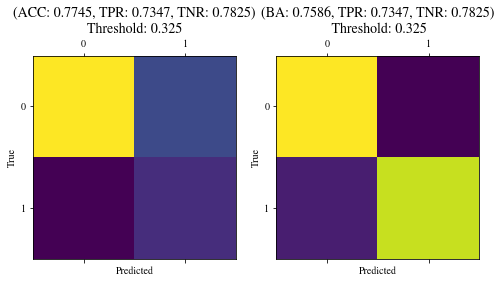

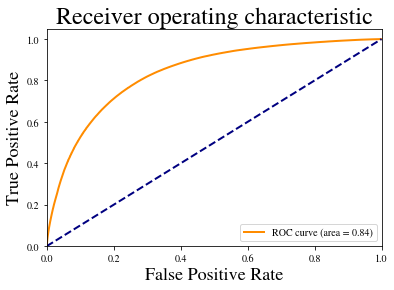

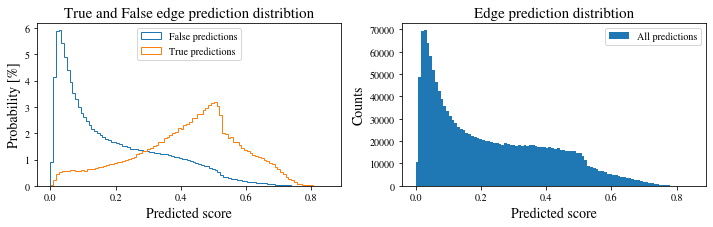

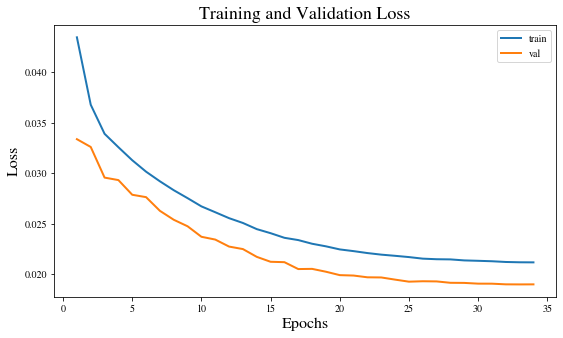

Training epoch 35: 100%|██████████| 20/20 [00:01<00:00, 17.27it/s]


Epoch: 35, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_35_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s]


Epoch: 35, val loss: 0.0190


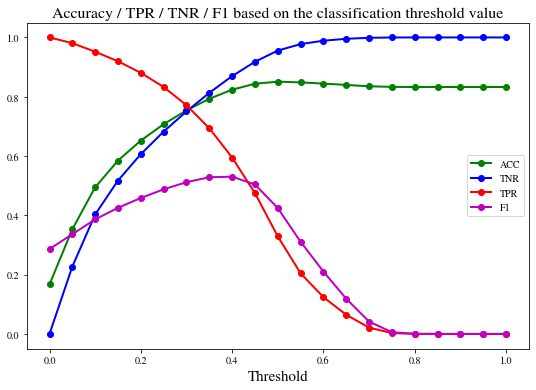

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497805


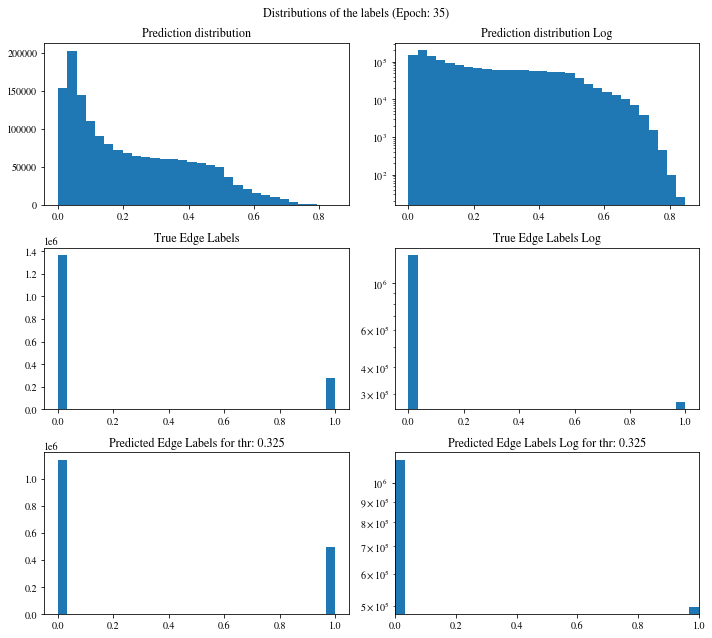

[0.51905197 0.02704936 0.19793698 ... 0.35641417 0.2244938  0.3774519 ]
Confusion matrix:
[[1067068  296632]
 [  72571  201173]]

Confusion matrix weighted:
[[0.39124001 0.10875999]
 [0.13255268 0.36744732]]

TN: 1067068 	 FN: 72571 	 TP: 201173 	 FP: 296632
Confusion matrix scaled:
[[0.65166687 0.18115551]
 [0.04431968 0.12285794]]

Accuracy: 0.7745
Precision: 0.4041
Negative predictive value: 0.9363
Recall: Correctly classifying 73.4895 % of positive edges
True negative rate: Correctly classifying 78.2480 % of all negative edges
F1 score: 0.5215
[0.74693675 0.77161209] [0.78248002 0.73489465] [0.76429538 0.75280592]
Balanced accuracy: 0.7587
Precision weighted: [0.74693675 0.77161209]
Recall weighted: [0.78248002 0.73489465]
F1 score weighted: [0.76429538 0.75280592]
positive_likelihood_ratio: 3.378515564324195, negative_likelihood_ratio: 0.33880143638773286


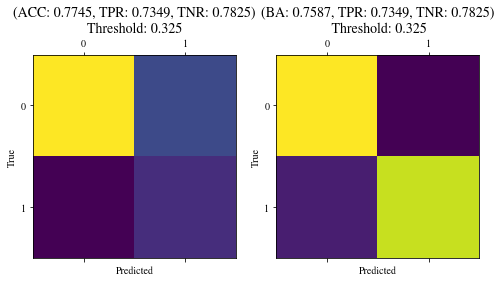

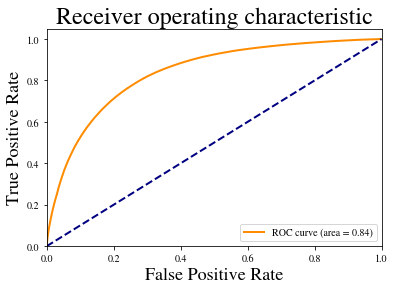

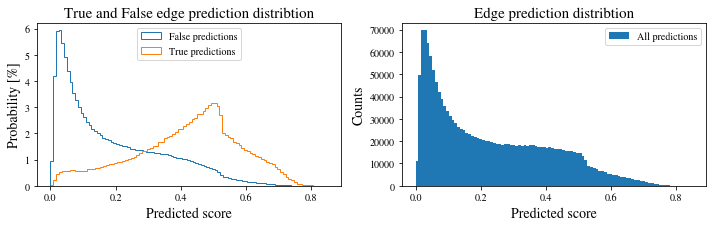

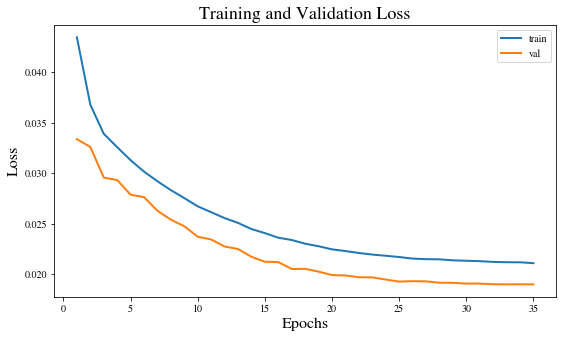

Training epoch 36: 100%|██████████| 20/20 [00:01<00:00, 17.75it/s]


Epoch: 36, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_36_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.10it/s]


Epoch: 36, val loss: 0.0190


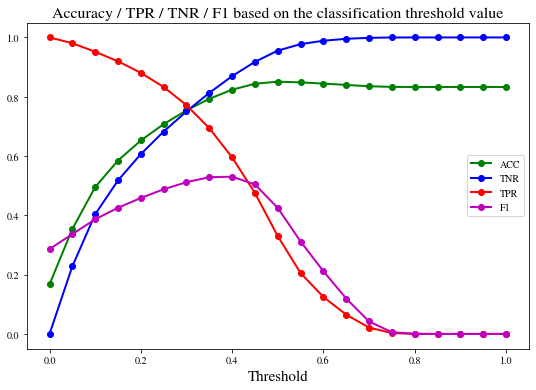

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497929


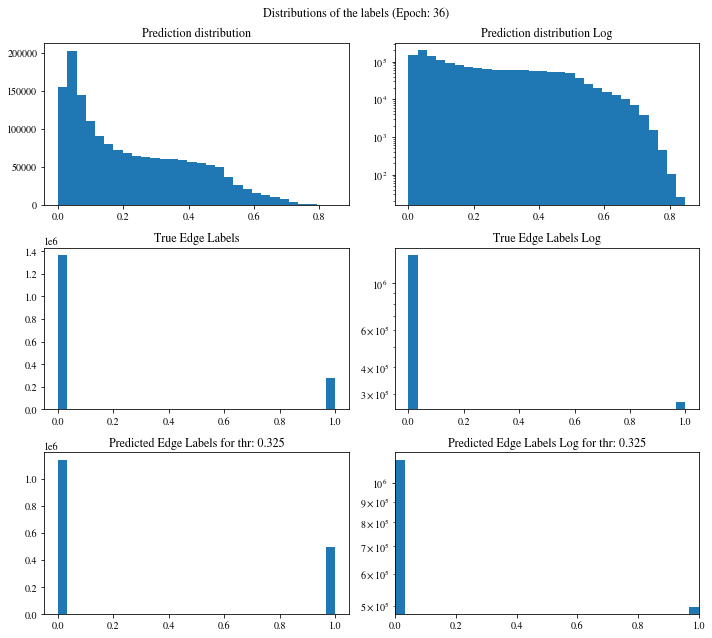

[0.52015889 0.32565808 0.10062772 ... 0.35664418 0.22441718 0.37760133]
Confusion matrix:
[[1066998  296702]
 [  72517  201227]]

Confusion matrix weighted:
[[0.39121434 0.10878566]
 [0.13245404 0.36754596]]

TN: 1066998 	 FN: 72517 	 TP: 201227 	 FP: 296702
Confusion matrix scaled:
[[0.65162412 0.18119826]
 [0.04428671 0.12289092]]

Accuracy: 0.7745
Precision: 0.4041
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5092 % of positive edges
True negative rate: Correctly classifying 78.2429 % of all negative edges
F1 score: 0.5215
[0.74706504 0.77161781] [0.78242869 0.73509191] [0.76433804 0.75291213]
Balanced accuracy: 0.7588
Precision weighted: [0.74706504 0.77161781]
Recall weighted: [0.78242869 0.73509191]
F1 score weighted: [0.76433804 0.75291213]
positive_likelihood_ratio: 3.378625147819478, negative_likelihood_ratio: 0.3385715450185148


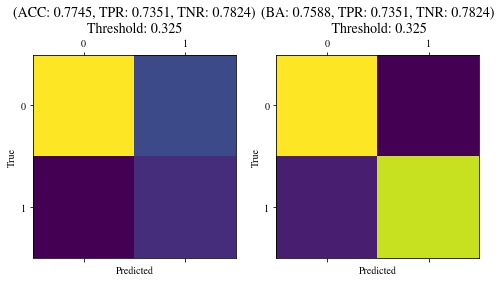

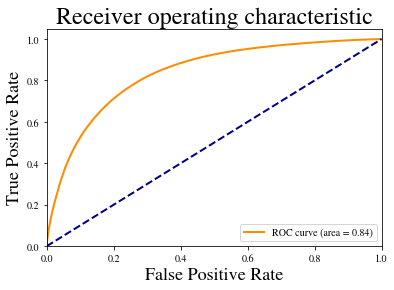

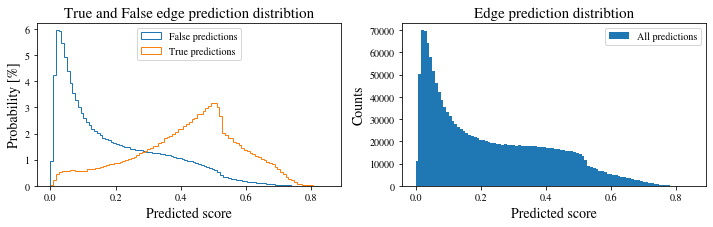

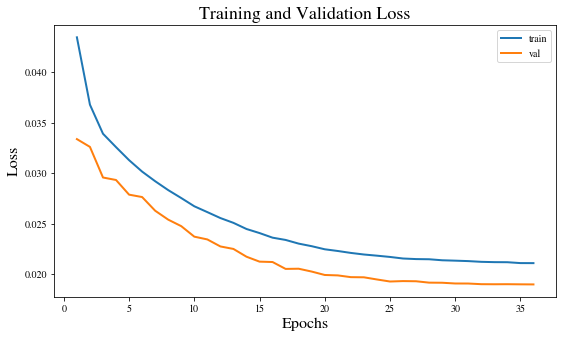

Training epoch 37: 100%|██████████| 20/20 [00:01<00:00, 17.24it/s]


Epoch: 37, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_37_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.41it/s]


Epoch: 37, val loss: 0.0190


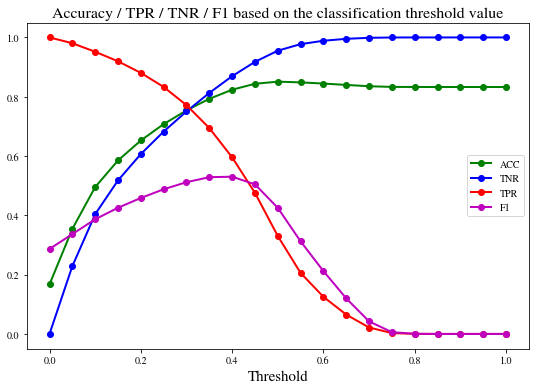

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 498148


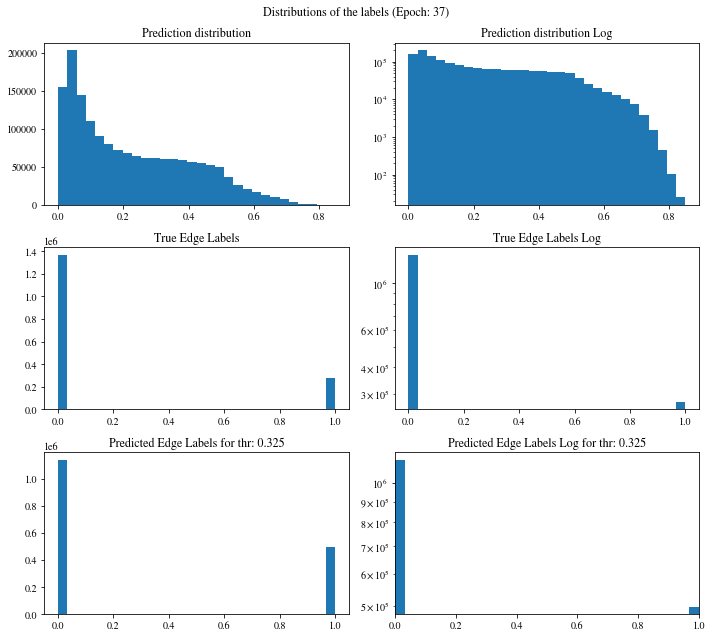

[0.50400424 0.02482957 0.39794666 ... 0.35688859 0.22442894 0.37781402]
Confusion matrix:
[[1066832  296868]
 [  72464  201280]]

Confusion matrix weighted:
[[0.39115348 0.10884652]
 [0.13235724 0.36764276]]

TN: 1066832 	 FN: 72464 	 TP: 201280 	 FP: 296868
Confusion matrix scaled:
[[0.65152274 0.18129964]
 [0.04425434 0.12292329]]

Accuracy: 0.7744
Precision: 0.4041
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5286 % of positive edges
True negative rate: Correctly classifying 78.2307 % of all negative edges
F1 score: 0.5215
[0.74717377 0.77156565] [0.78230696 0.73528552] [0.76433685 0.75298883]
Balanced accuracy: 0.7588
Precision weighted: [0.74717377 0.77156565]
Recall weighted: [0.78230696 0.73528552]
F1 score weighted: [0.76433685 0.75298883]
positive_likelihood_ratio: 3.377625297028836, negative_likelihood_ratio: 0.33837673909448124


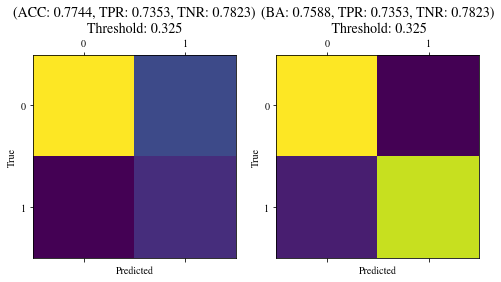

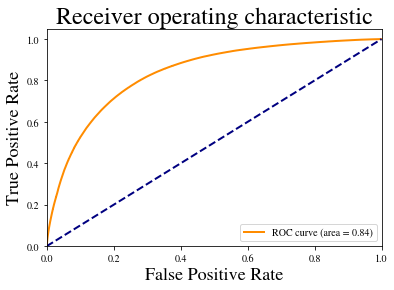

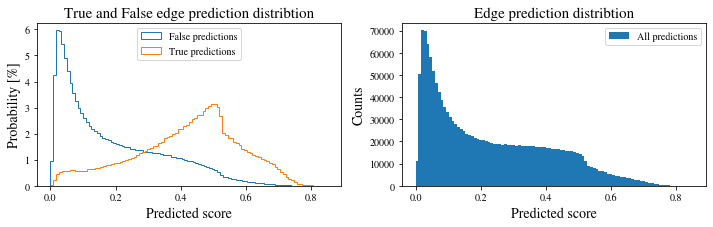

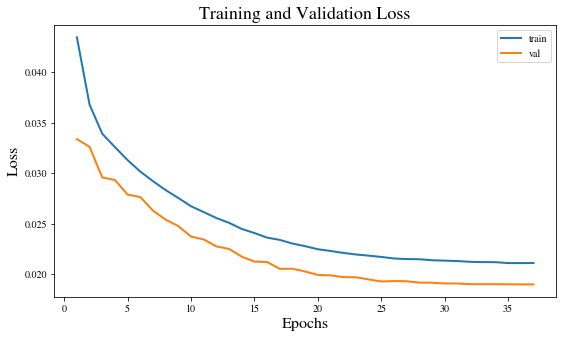

Training epoch 38: 100%|██████████| 20/20 [00:01<00:00, 17.28it/s]


Epoch: 38, train loss: 0.0212
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_38_loss_0.0212.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.07it/s]


Epoch: 38, val loss: 0.0190


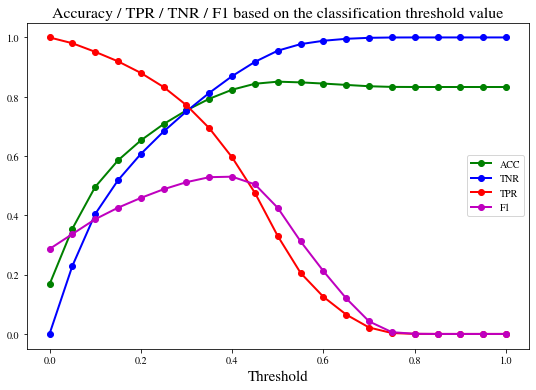

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497638


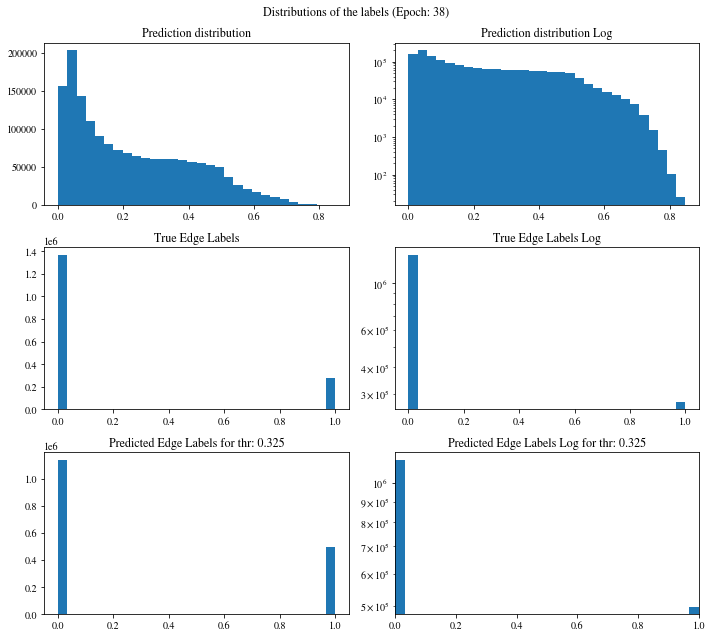

[0.66028666 0.52480137 0.48213461 ... 0.22913952 0.49662635 0.46786469]
Confusion matrix:
[[1067254  296446]
 [  72552  201192]]

Confusion matrix weighted:
[[0.39130821 0.10869179]
 [0.13251797 0.36748203]]

TN: 1067254 	 FN: 72552 	 TP: 201192 	 FP: 296446
Confusion matrix scaled:
[[0.65178046 0.18104192]
 [0.04430808 0.12286955]]

Accuracy: 0.7747
Precision: 0.4043
Negative predictive value: 0.9363
Recall: Correctly classifying 73.4964 % of positive edges
True negative rate: Correctly classifying 78.2616 % of all negative edges
F1 score: 0.5216
[0.74701919 0.77173925] [0.78261641 0.73496405] [0.76440359 0.75290285]
Balanced accuracy: 0.7588
Precision weighted: [0.74701919 0.77173925]
Recall weighted: [0.78261641 0.73496405]
F1 score weighted: [0.76440359 0.75290285]
positive_likelihood_ratio: 3.3809546441810197, negative_likelihood_ratio: 0.3386537033837432


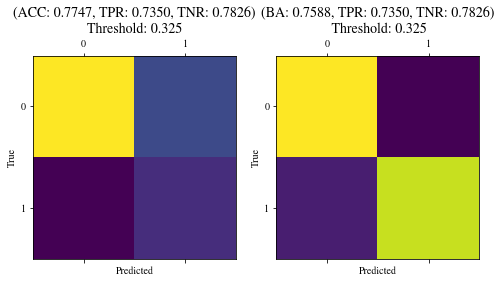

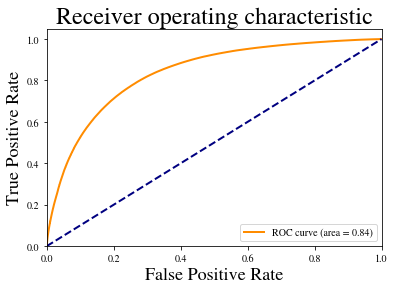

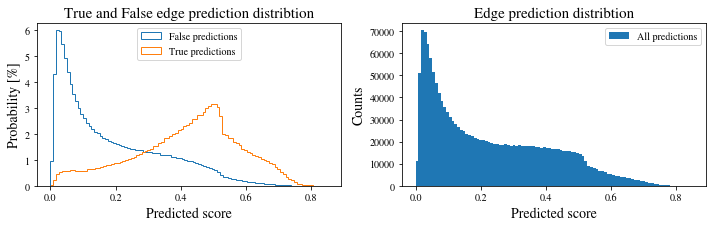

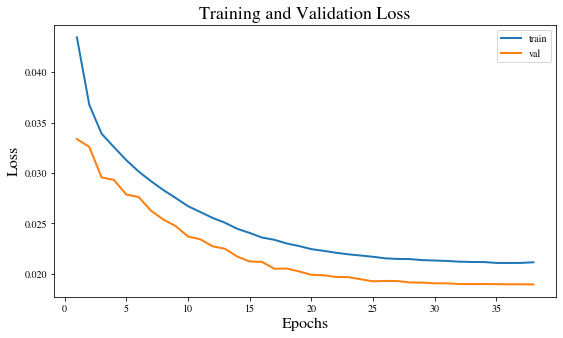

Training epoch 39: 100%|██████████| 20/20 [00:01<00:00, 16.77it/s]


Epoch: 39, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_39_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.69it/s]


Epoch: 39, val loss: 0.0190


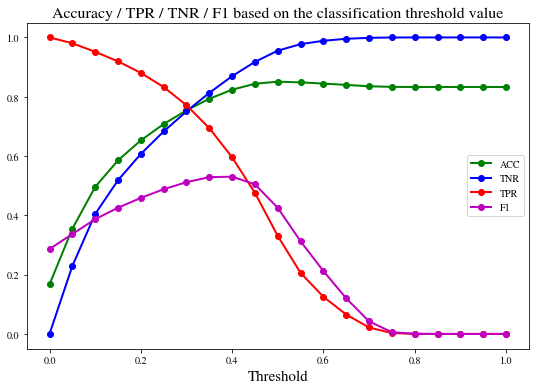

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497784


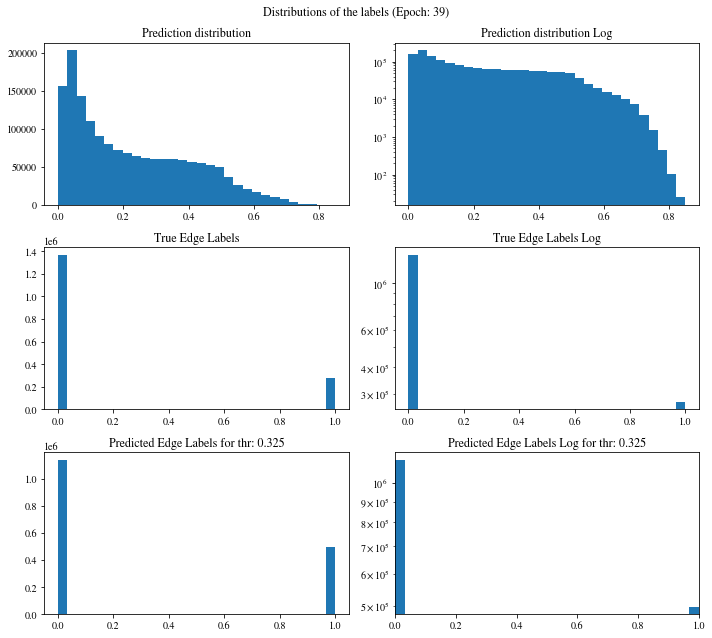

[0.50403023 0.02472784 0.39785933 ... 0.35667706 0.22412188 0.37761888]
Confusion matrix:
[[1067137  296563]
 [  72523  201221]]

Confusion matrix weighted:
[[0.39126531 0.10873469]
 [0.132465   0.367535  ]]

TN: 1067137 	 FN: 72523 	 TP: 201221 	 FP: 296563
Confusion matrix scaled:
[[0.65170901 0.18111337]
 [0.04429037 0.12288726]]

Accuracy: 0.7746
Precision: 0.4042
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5070 % of positive edges
True negative rate: Correctly classifying 78.2531 % of all negative edges
F1 score: 0.5216
[0.74707402 0.77169512] [0.78253062 0.73506999] [0.76439137 0.75293743]
Balanced accuracy: 0.7588
Precision weighted: [0.74707402 0.77169512]
Recall weighted: [0.78253062 0.73506999]
F1 score weighted: [0.76439137 0.75293743]
positive_likelihood_ratio: 3.380107932001442, negative_likelihood_ratio: 0.33855545385630553


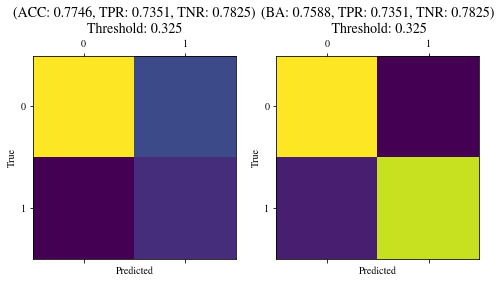

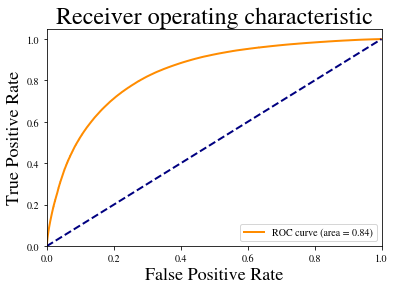

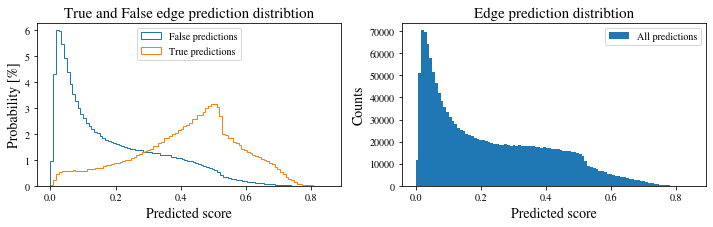

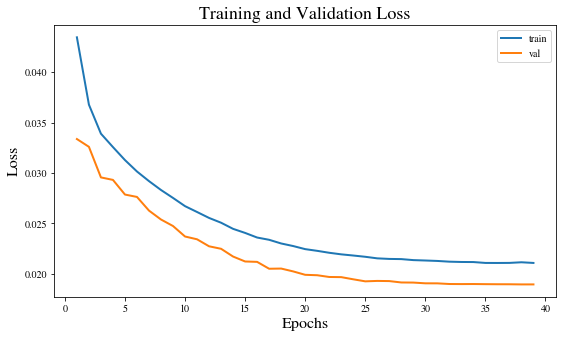

Training epoch 40: 100%|██████████| 20/20 [00:01<00:00, 17.26it/s]


Epoch: 40, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_40_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.93it/s]


Epoch: 40, val loss: 0.0190


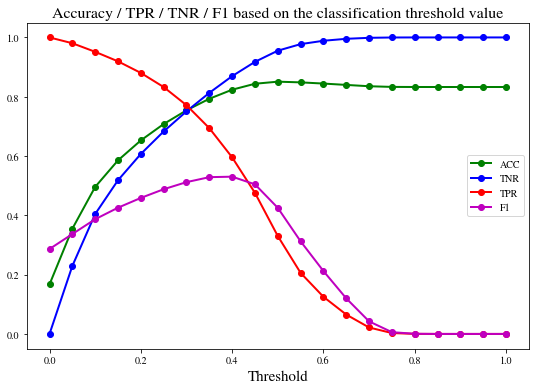

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497770


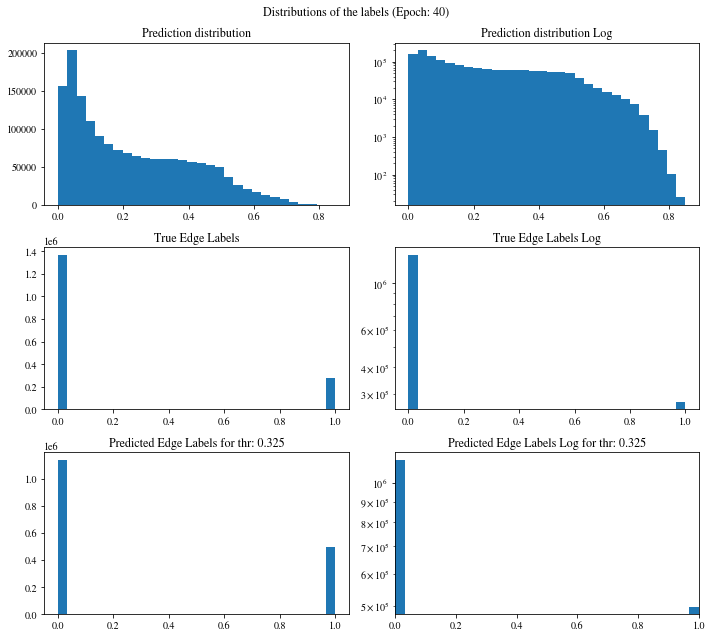

[0.52019864 0.32540685 0.10011767 ... 0.31006372 0.08466441 0.20161627]
Confusion matrix:
[[1067151  296549]
 [  72523  201221]]

Confusion matrix weighted:
[[0.39127044 0.10872956]
 [0.132465   0.367535  ]]

TN: 1067151 	 FN: 72523 	 TP: 201221 	 FP: 296549
Confusion matrix scaled:
[[0.65171755 0.18110482]
 [0.04429037 0.12288726]]

Accuracy: 0.7746
Precision: 0.4042
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5070 % of positive edges
True negative rate: Correctly classifying 78.2541 % of all negative edges
F1 score: 0.5216
[0.7470765  0.77170344] [0.78254088 0.73506999] [0.76439757 0.75294139]
Balanced accuracy: 0.7588
Precision weighted: [0.7470765  0.77170344]
Recall weighted: [0.78254088 0.73506999]
F1 score weighted: [0.76439757 0.75294139]
positive_likelihood_ratio: 3.380267506004551, negative_likelihood_ratio: 0.338551012332703


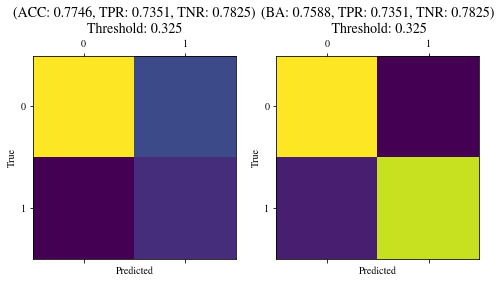

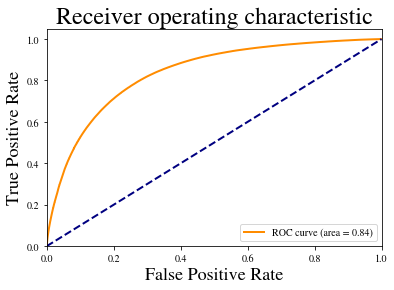

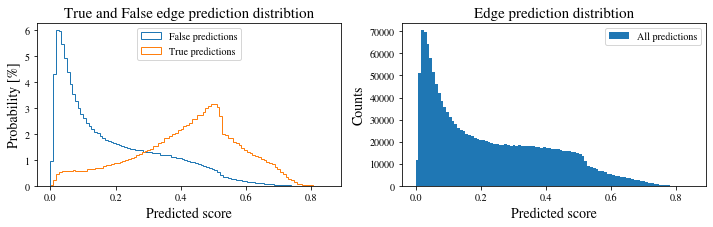

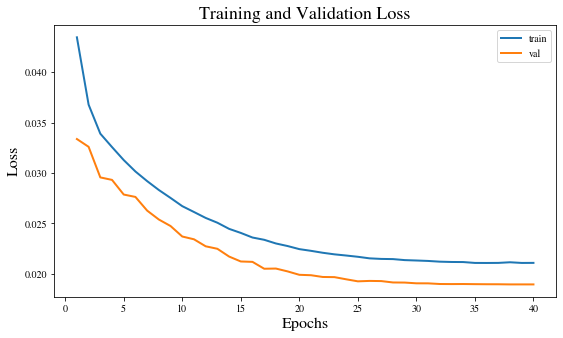

Training epoch 41: 100%|██████████| 20/20 [00:01<00:00, 17.50it/s]


Epoch: 41, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_41_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.26it/s]


Epoch: 41, val loss: 0.0190


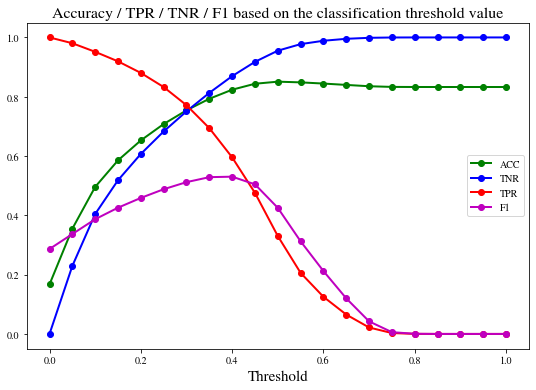

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497773


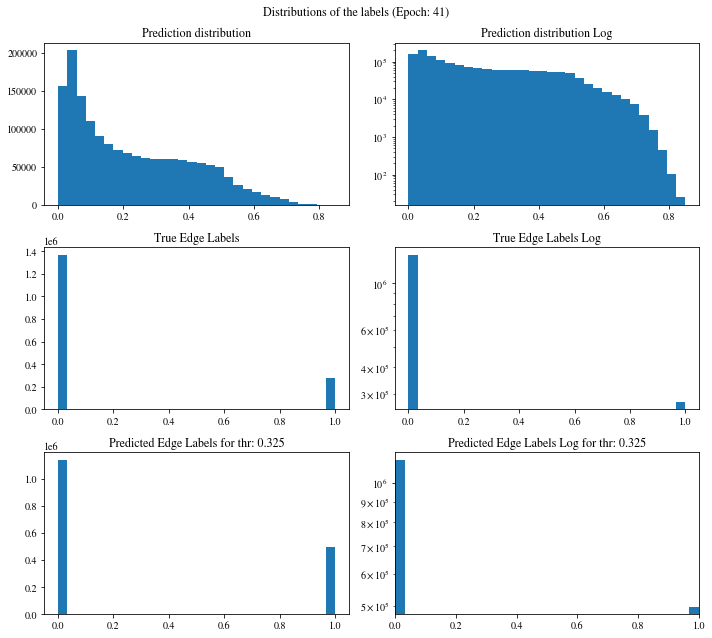

[0.52020562 0.32540342 0.10010484 ... 0.07125249 0.19648688 0.64384246]
Confusion matrix:
[[1067148  296552]
 [  72523  201221]]

Confusion matrix weighted:
[[0.39126934 0.10873066]
 [0.132465   0.367535  ]]

TN: 1067148 	 FN: 72523 	 TP: 201221 	 FP: 296552
Confusion matrix scaled:
[[0.65171572 0.18110665]
 [0.04429037 0.12288726]]

Accuracy: 0.7746
Precision: 0.4042
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5070 % of positive edges
True negative rate: Correctly classifying 78.2539 % of all negative edges
F1 score: 0.5216
[0.74707596 0.77170166] [0.78253868 0.73506999] [0.76439624 0.75294054]
Balanced accuracy: 0.7588
Precision weighted: [0.74707596 0.77170166]
Recall weighted: [0.78253868 0.73506999]
F1 score weighted: [0.76439624 0.75294054]
positive_likelihood_ratio: 3.38023331030694, negative_likelihood_ratio: 0.33855196407795013


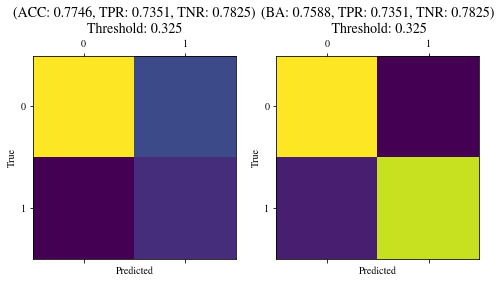

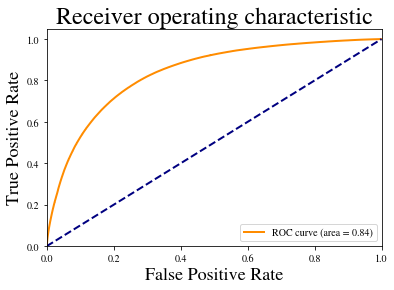

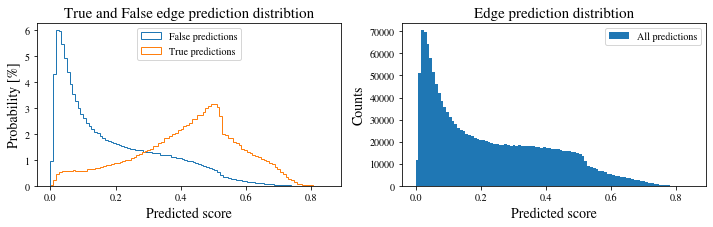

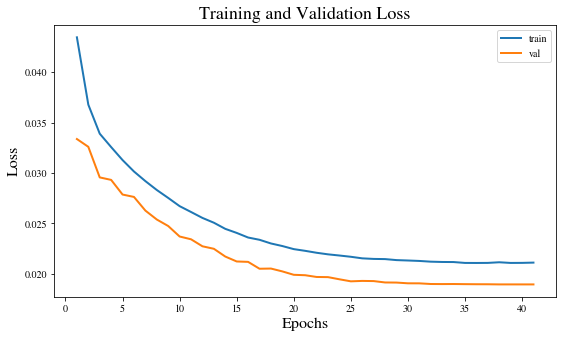

Training epoch 42: 100%|██████████| 20/20 [00:01<00:00, 16.81it/s]


Epoch: 42, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_42_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.07it/s]


Epoch: 42, val loss: 0.0190


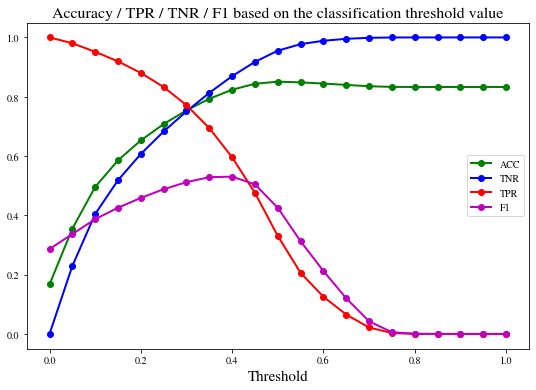

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497816


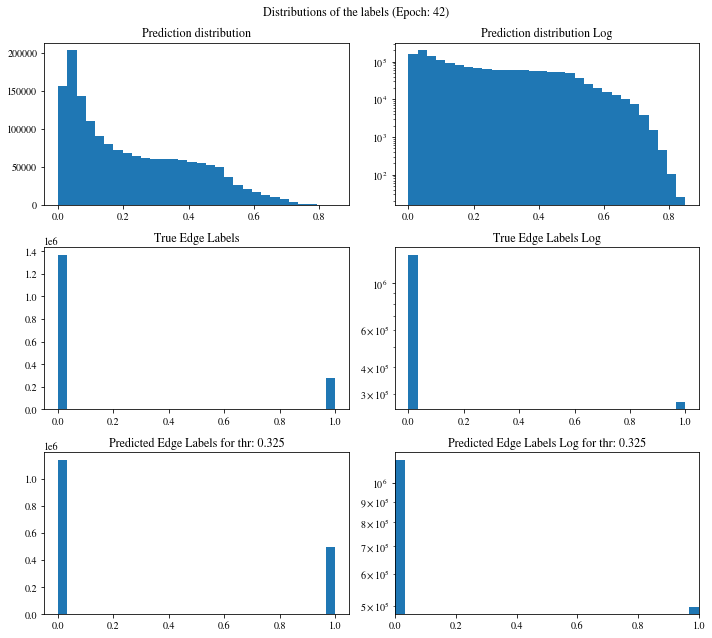

[0.44772822 0.59660941 0.53726345 ... 0.07005511 0.06039641 0.56179041]
Confusion matrix:
[[1067112  296588]
 [  72516  201228]]

Confusion matrix weighted:
[[0.39125614 0.10874386]
 [0.13245222 0.36754778]]

TN: 1067112 	 FN: 72516 	 TP: 201228 	 FP: 296588
Confusion matrix scaled:
[[0.65169374 0.18112864]
 [0.04428609 0.12289153]]

Accuracy: 0.7746
Precision: 0.4042
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5096 % of positive edges
True negative rate: Correctly classifying 78.2512 % of all negative edges
F1 score: 0.5216
[0.74708783 0.7716864 ] [0.78251228 0.73509556] [0.76438985 0.75294669]
Balanced accuracy: 0.7588
Precision weighted: [0.74708783 0.7716864 ]
Recall weighted: [0.78251228 0.73509556]
F1 score weighted: [0.76438985 0.75294669]
positive_likelihood_ratio: 3.379940591898638, negative_likelihood_ratio: 0.33853070692670184


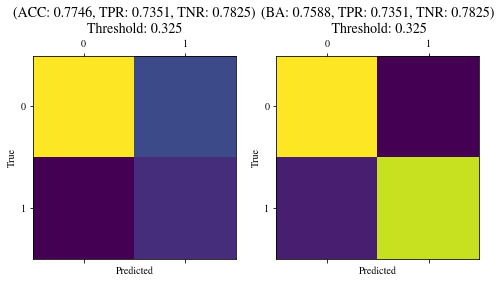

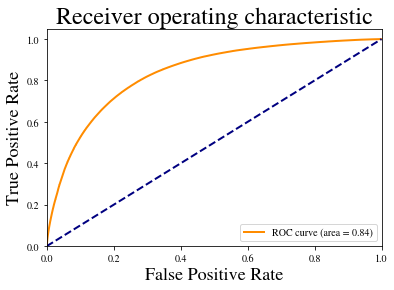

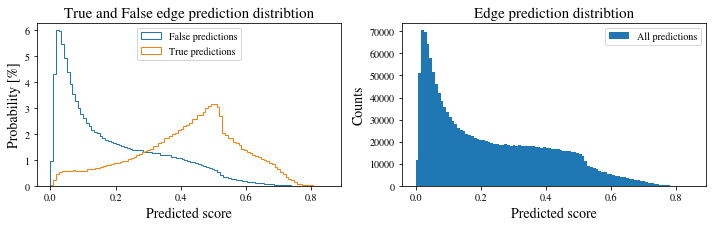

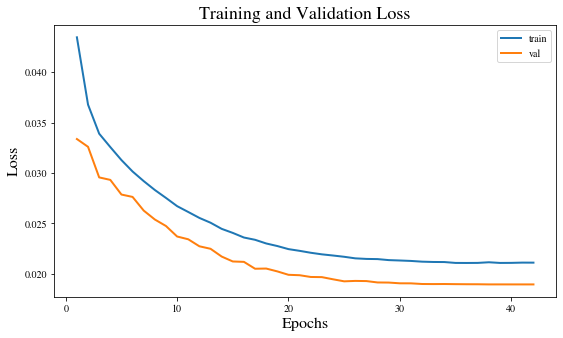

Training epoch 43: 100%|██████████| 20/20 [00:01<00:00, 17.09it/s]


Epoch: 43, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_43_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.97it/s]


Epoch: 43, val loss: 0.0190


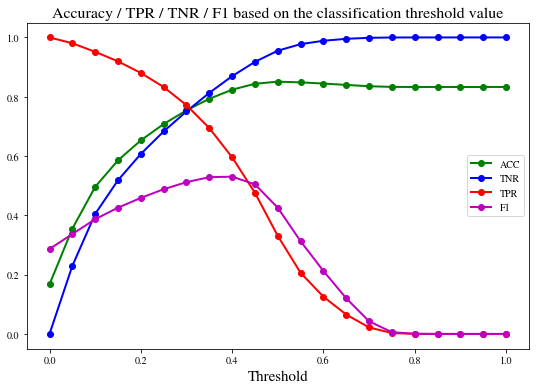

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497790


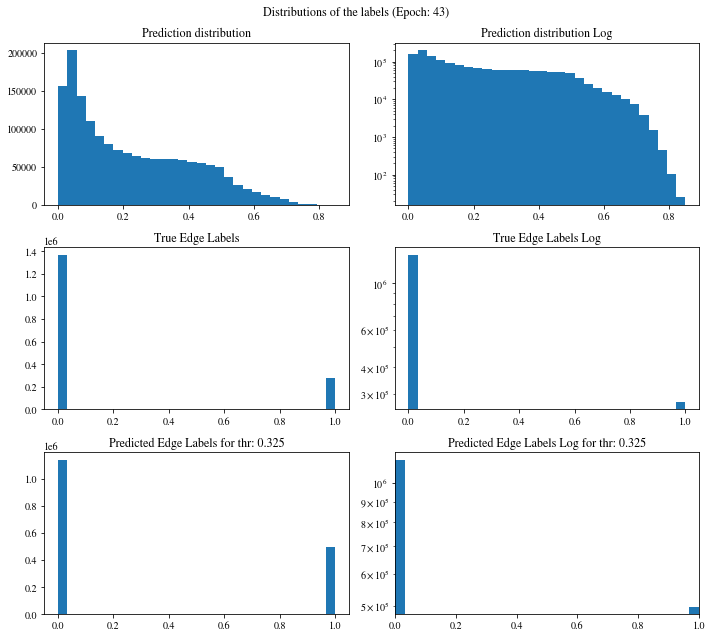

[0.50413328 0.02466903 0.39787221 ... 0.22904547 0.49690741 0.46809667]
Confusion matrix:
[[1067139  296561]
 [  72515  201229]]

Confusion matrix weighted:
[[0.39126604 0.10873396]
 [0.13245039 0.36754961]]

TN: 1067139 	 FN: 72515 	 TP: 201229 	 FP: 296561
Confusion matrix scaled:
[[0.65171023 0.18111215]
 [0.04428548 0.12289214]]

Accuracy: 0.7746
Precision: 0.4042
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5099 % of positive edges
True negative rate: Correctly classifying 78.2532 % of all negative edges
F1 score: 0.5216
[0.74709522 0.77170332] [0.78253208 0.73509922] [0.76440317 0.75295666]
Balanced accuracy: 0.7588
Precision weighted: [0.74709522 0.77170332]
Recall weighted: [0.78253208 0.73509922]
F1 score weighted: [0.76440317 0.75295666]
positive_likelihood_ratio: 3.380265112175006, negative_likelihood_ratio: 0.3385174734203025


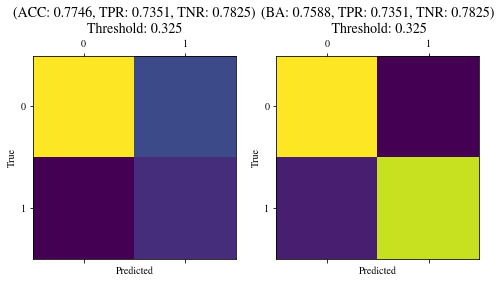

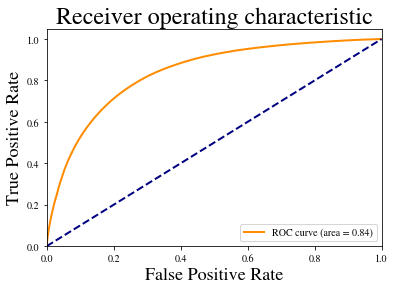

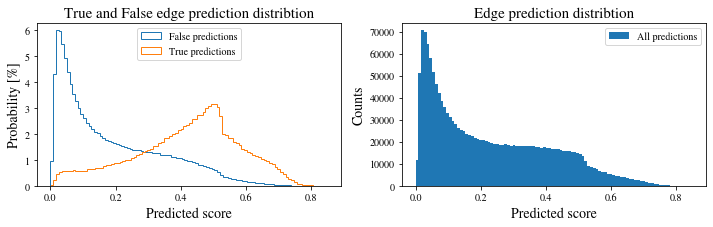

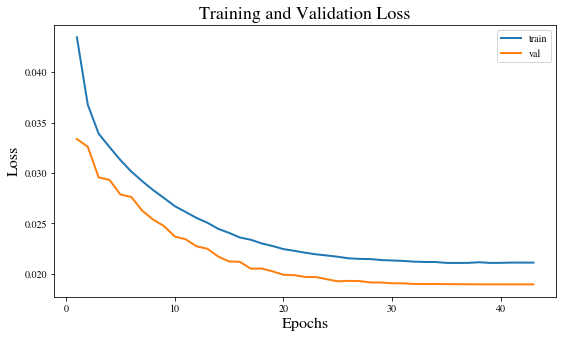

Training epoch 44: 100%|██████████| 20/20 [00:01<00:00, 16.90it/s]


Epoch: 44, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_44_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.55it/s]


Epoch: 44, val loss: 0.0189


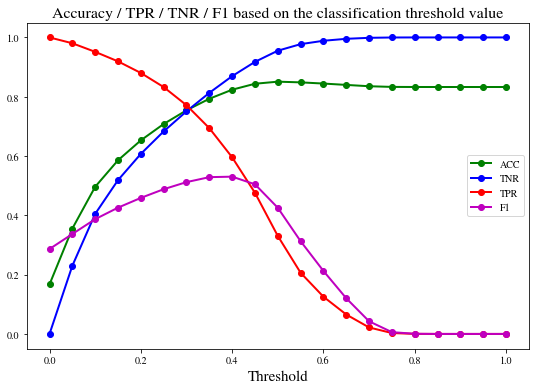

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497706


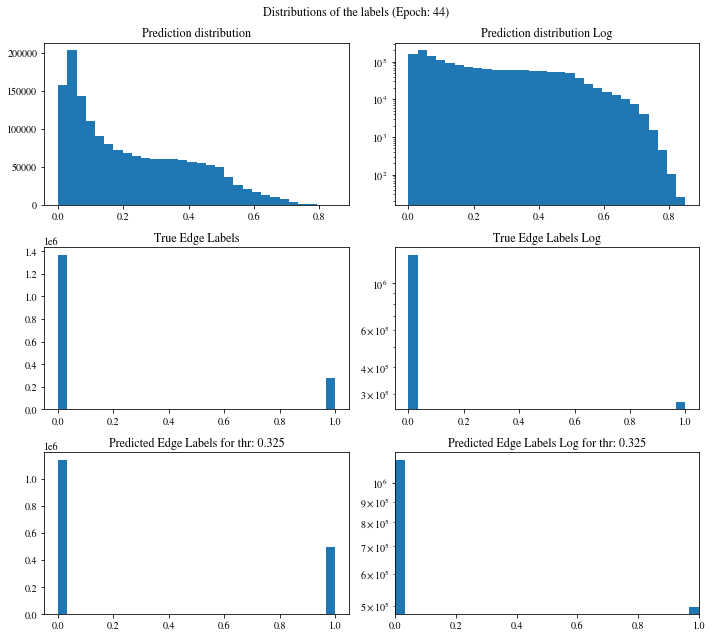

[0.66063851 0.52472997 0.48206323 ... 0.07019358 0.06046963 0.56183326]
Confusion matrix:
[[1067207  296493]
 [  72531  201213]]

Confusion matrix weighted:
[[0.39129097 0.10870903]
 [0.13247962 0.36752038]]

TN: 1067207 	 FN: 72531 	 TP: 201213 	 FP: 296493
Confusion matrix scaled:
[[0.65175175 0.18107062]
 [0.04429526 0.12288237]]

Accuracy: 0.7746
Precision: 0.4043
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5041 % of positive edges
True negative rate: Correctly classifying 78.2582 % of all negative edges
F1 score: 0.5216
[0.74706557 0.77172971] [0.78258195 0.73504077] [0.76441144 0.75293856]
Balanced accuracy: 0.7588
Precision weighted: [0.74706557 0.77172971]
Recall weighted: [0.78258195 0.73504077]
F1 score weighted: [0.76441144 0.75293856]
positive_likelihood_ratio: 3.3807715370836933, negative_likelihood_ratio: 0.33857059094950137


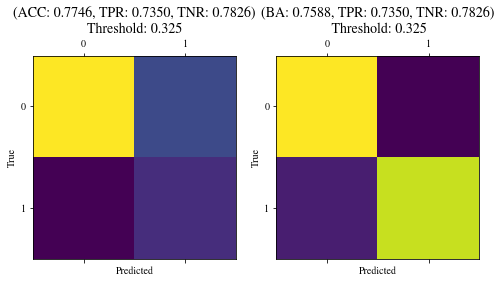

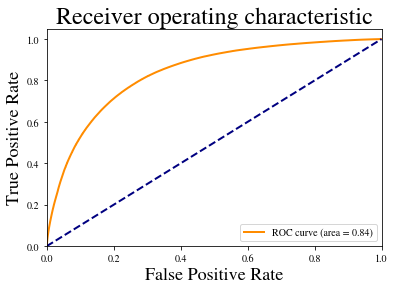

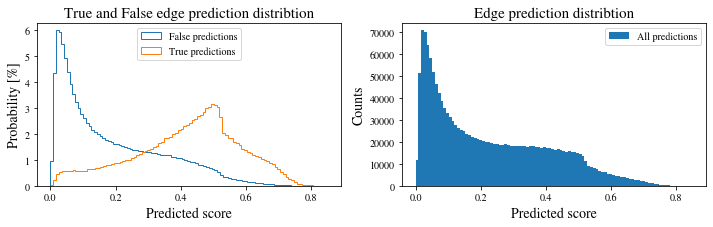

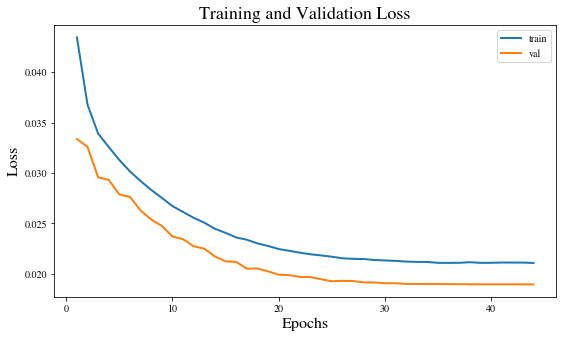

Training epoch 45: 100%|██████████| 20/20 [00:01<00:00, 17.57it/s]


Epoch: 45, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_45_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


Epoch: 45, val loss: 0.0189


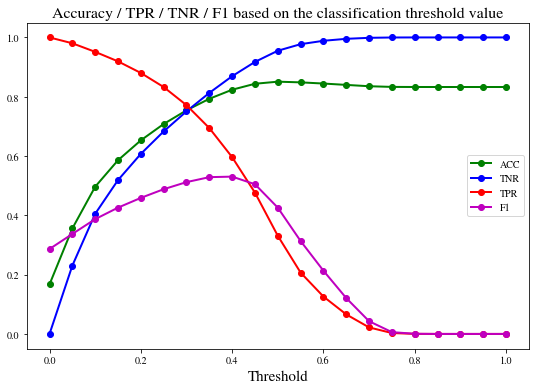

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 498001


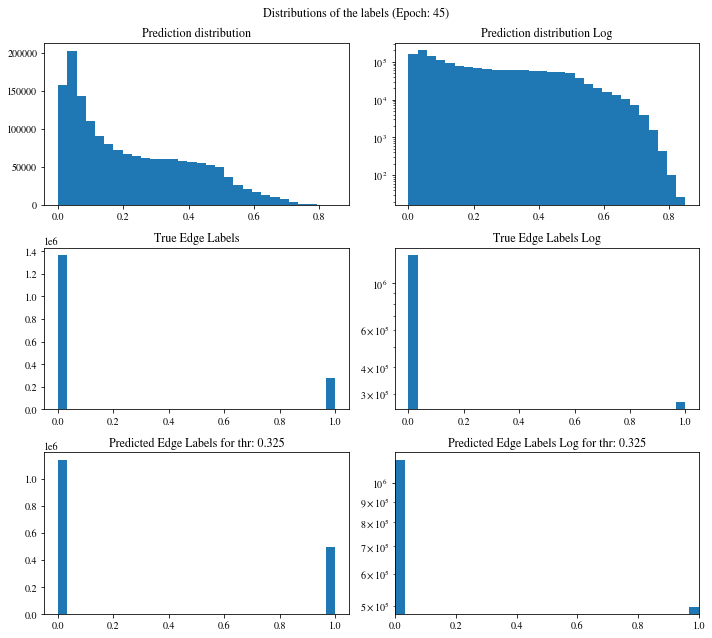

[0.52116942 0.02646759 0.19729723 ... 0.31040505 0.08455671 0.20162614]
Confusion matrix:
[[1066978  296722]
 [  72465  201279]]

Confusion matrix weighted:
[[0.39120701 0.10879299]
 [0.13235907 0.36764093]]

TN: 1066978 	 FN: 72465 	 TP: 201279 	 FP: 296722
Confusion matrix scaled:
[[0.6516119  0.18121047]
 [0.04425495 0.12292268]]

Accuracy: 0.7745
Precision: 0.4042
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5282 % of positive edges
True negative rate: Correctly classifying 78.2414 % of all negative edges
F1 score: 0.5216
[0.74719702 0.77165146] [0.78241402 0.73528187] [0.76440011 0.75302778]
Balanced accuracy: 0.7588
Precision weighted: [0.74719702 0.77165146]
Recall weighted: [0.78241402 0.73528187]
F1 score weighted: [0.76440011 0.75302778]
positive_likelihood_ratio: 3.3792704451191953, negative_likelihood_ratio: 0.3383351062377501


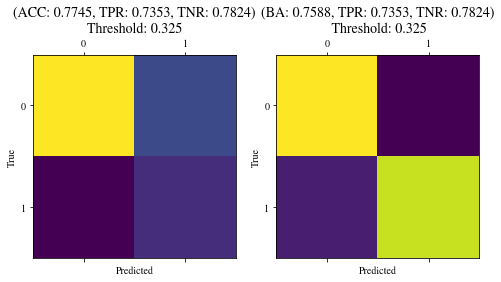

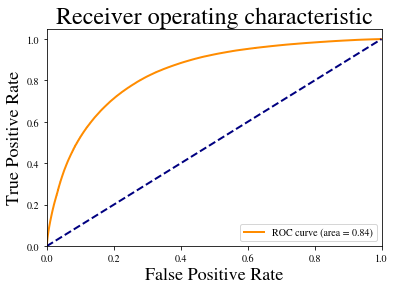

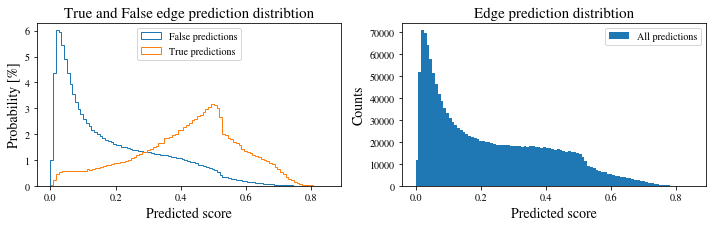

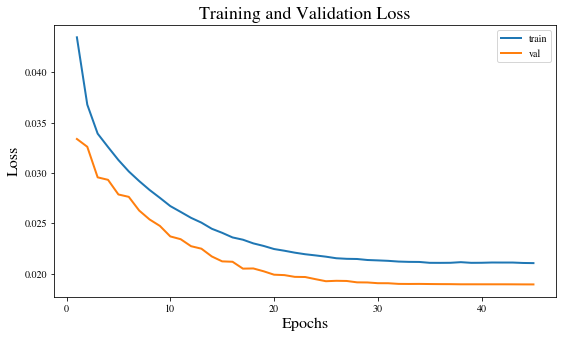

Training epoch 46: 100%|██████████| 20/20 [00:01<00:00, 17.12it/s]


Epoch: 46, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_46_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.27it/s]


Epoch: 46, val loss: 0.0189


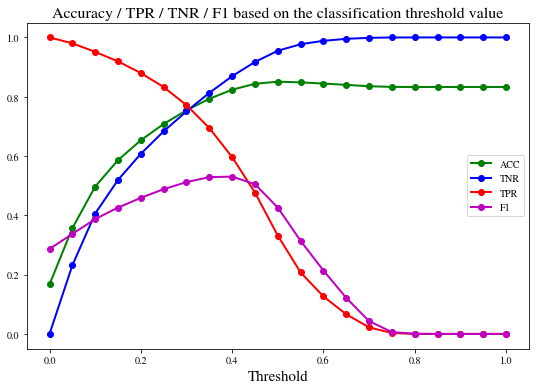

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497884


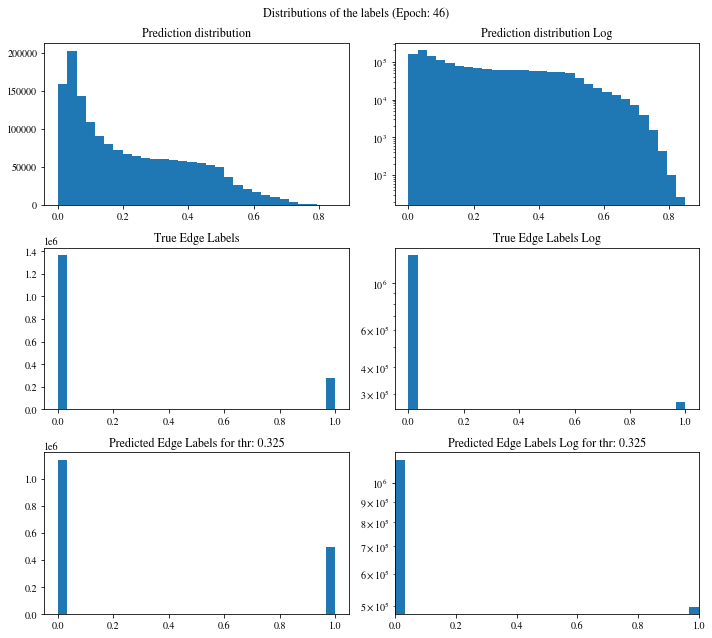

[0.52058917 0.3250463  0.09925057 ... 0.35709906 0.2237751  0.37792686]
Confusion matrix:
[[1067088  296612]
 [  72472  201272]]

Confusion matrix weighted:
[[0.39124734 0.10875266]
 [0.13237185 0.36762815]]

TN: 1067088 	 FN: 72472 	 TP: 201272 	 FP: 296612
Confusion matrix scaled:
[[0.65167908 0.18114329]
 [0.04425922 0.1229184 ]]

Accuracy: 0.7746
Precision: 0.4043
Negative predictive value: 0.9364
Recall: Correctly classifying 73.5256 % of positive edges
True negative rate: Correctly classifying 78.2495 % of all negative edges
F1 score: 0.5217
[0.74719824 0.77171066] [0.78249468 0.7352563 ] [0.76443925 0.75304256]
Balanced accuracy: 0.7589
Precision weighted: [0.74719824 0.77171066]
Recall weighted: [0.78249468 0.7352563 ]
F1 score weighted: [0.76443925 0.75304256]
positive_likelihood_ratio: 3.3804060974767314, negative_likelihood_ratio: 0.33833290845294084


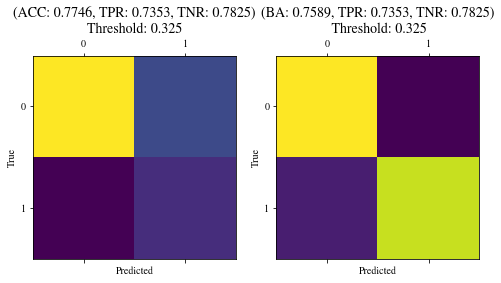

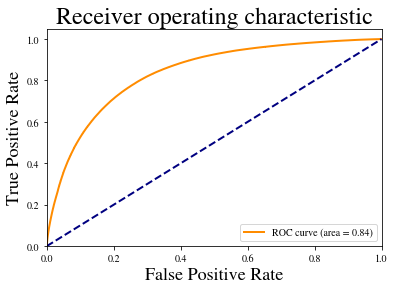

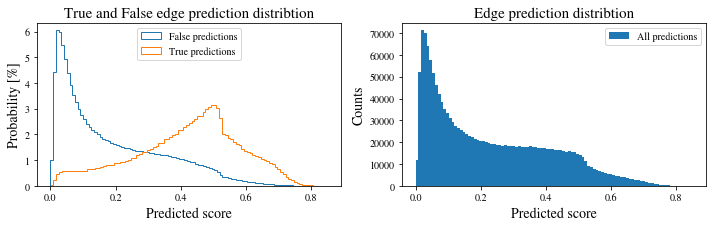

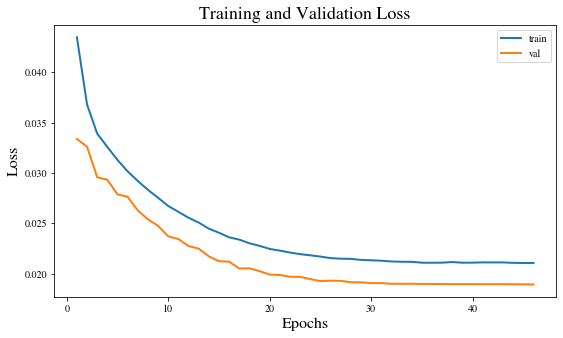

Training epoch 47: 100%|██████████| 20/20 [00:01<00:00, 17.18it/s]


Epoch: 47, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_47_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.35it/s]


Epoch: 47, val loss: 0.0189


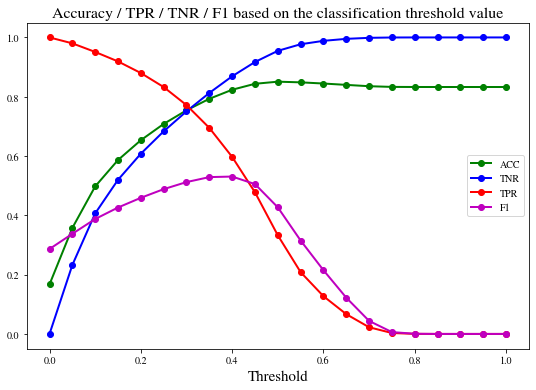

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 498192


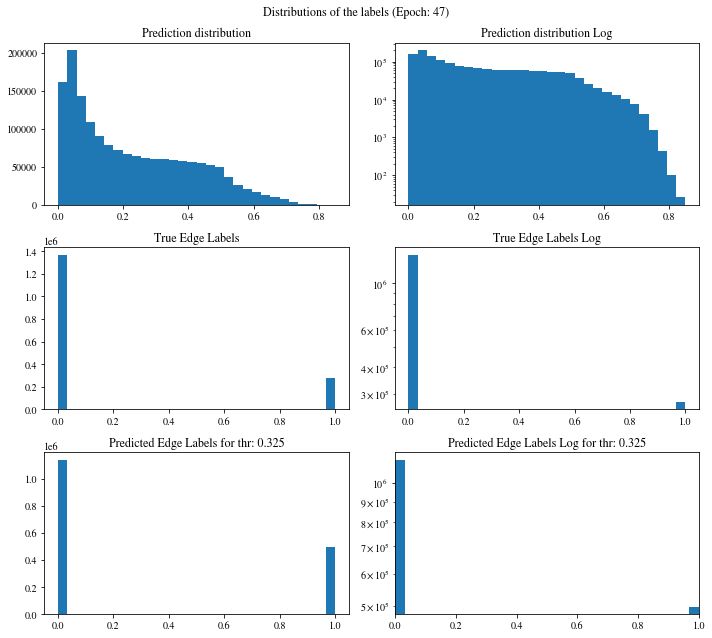

[0.44765174 0.59791654 0.53759909 ... 0.31090102 0.08433944 0.20163035]
Confusion matrix:
[[1066879  296821]
 [  72373  201371]]

Confusion matrix weighted:
[[0.39117071 0.10882929]
 [0.13219103 0.36780897]]

TN: 1066879 	 FN: 72373 	 TP: 201371 	 FP: 296821
Confusion matrix scaled:
[[0.65155144 0.18127093]
 [0.04419876 0.12297886]]

Accuracy: 0.7745
Precision: 0.4042
Negative predictive value: 0.9365
Recall: Correctly classifying 73.5618 % of positive edges
True negative rate: Correctly classifying 78.2341 % of all negative edges
F1 score: 0.5217
[0.74741939 0.7716732 ] [0.78234142 0.73561795] [0.7644818  0.75321435]
Balanced accuracy: 0.7590
Precision weighted: [0.74741939 0.7716732 ]
Recall weighted: [0.78234142 0.73561795]
F1 score weighted: [0.7644818  0.75321435]
positive_likelihood_ratio: 3.3796874139394513, negative_likelihood_ratio: 0.33793691890746574


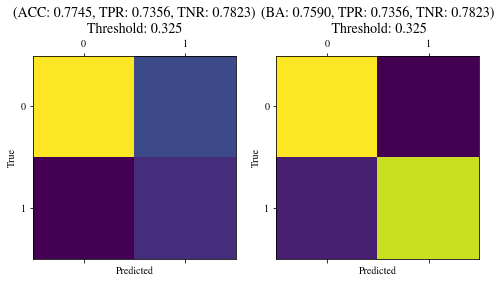

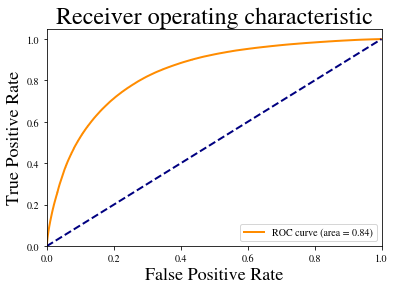

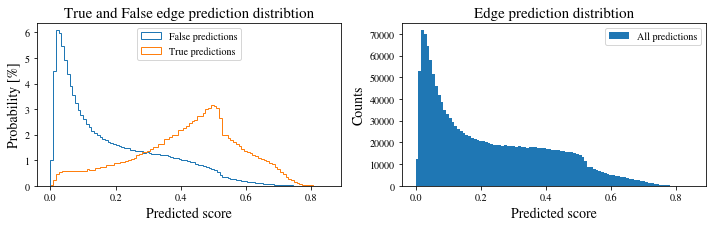

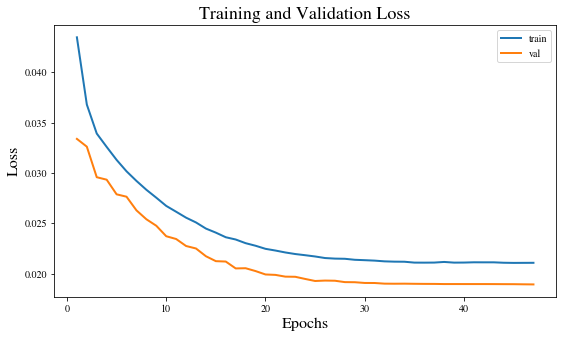

Training epoch 48: 100%|██████████| 20/20 [00:01<00:00, 17.57it/s]


Epoch: 48, train loss: 0.0211
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_48_loss_0.0211.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s]


Epoch: 48, val loss: 0.0189


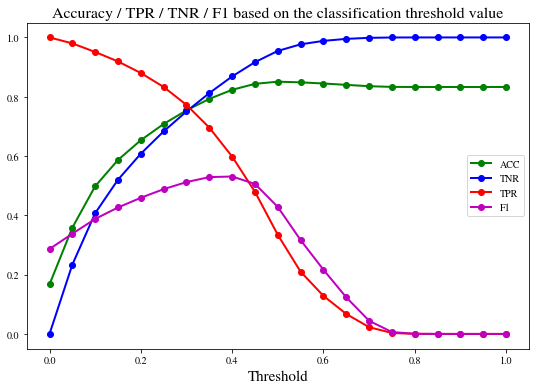

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 498928


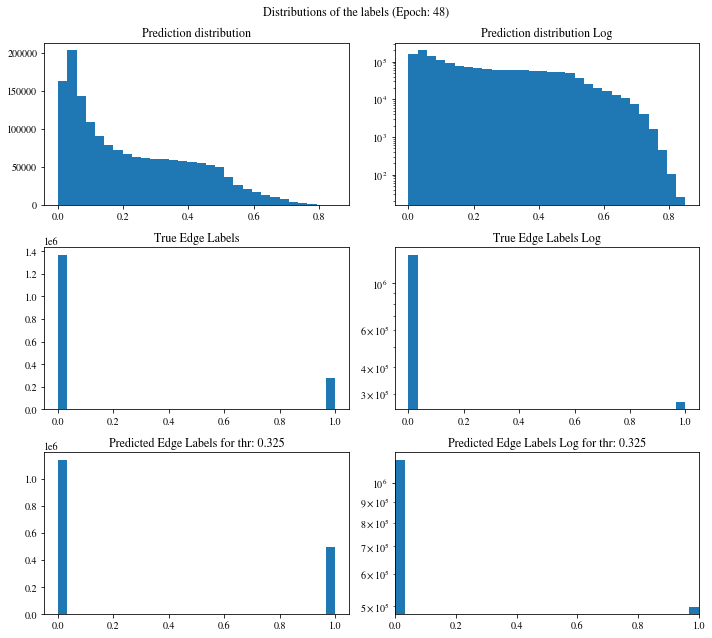

[0.50599408 0.02389326 0.39810708 ... 0.31163231 0.0843216  0.20186262]
Confusion matrix:
[[1066345  297355]
 [  72171  201573]]

Confusion matrix weighted:
[[0.39097492 0.10902508]
 [0.13182207 0.36817793]]

TN: 1066345 	 FN: 72171 	 TP: 201573 	 FP: 297355
Confusion matrix scaled:
[[0.65122532 0.18159705]
 [0.0440754  0.12310223]]

Accuracy: 0.7743
Precision: 0.4040
Negative predictive value: 0.9366
Recall: Correctly classifying 73.6356 % of positive edges
True negative rate: Correctly classifying 78.1950 % of all negative edges
F1 score: 0.5218
[0.74785228 0.77153313] [0.78194984 0.73635587] [0.76452106 0.75353418]
Balanced accuracy: 0.7592
Precision weighted: [0.74785228 0.77153313]
Recall weighted: [0.78194984 0.73635587]
F1 score weighted: [0.76452106 0.75353418]
positive_likelihood_ratio: 3.3770022147131313, negative_likelihood_ratio: 0.3371624628464304


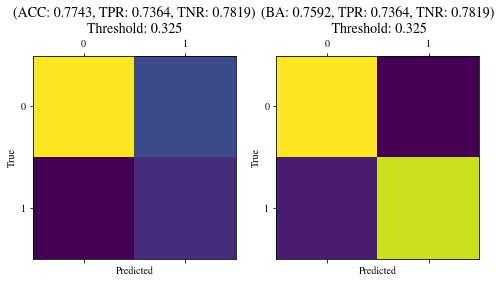

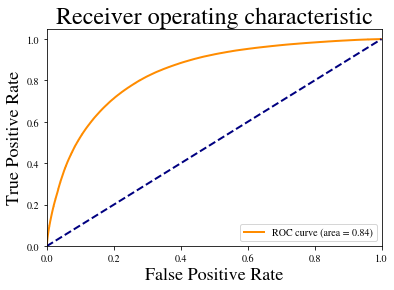

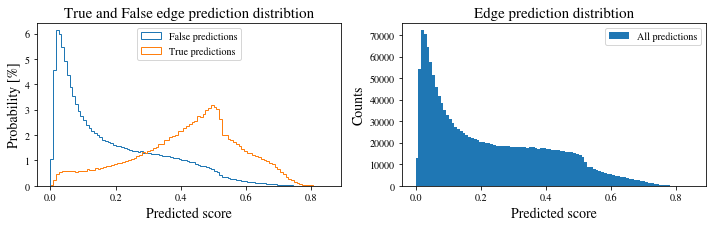

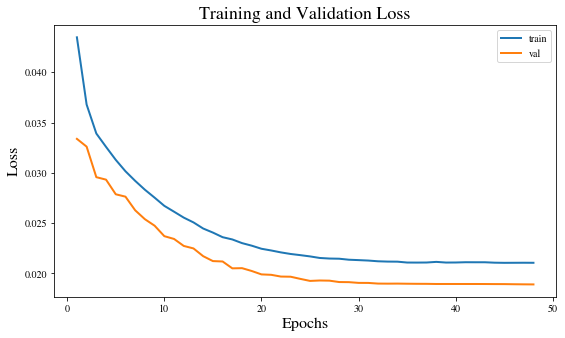

Training epoch 49: 100%|██████████| 20/20 [00:01<00:00, 17.37it/s]


Epoch: 49, train loss: 0.0210
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_49_loss_0.0210.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 19.31it/s]


Epoch: 49, val loss: 0.0189


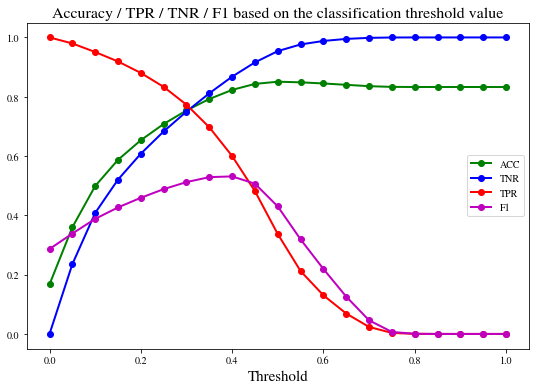

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 500084


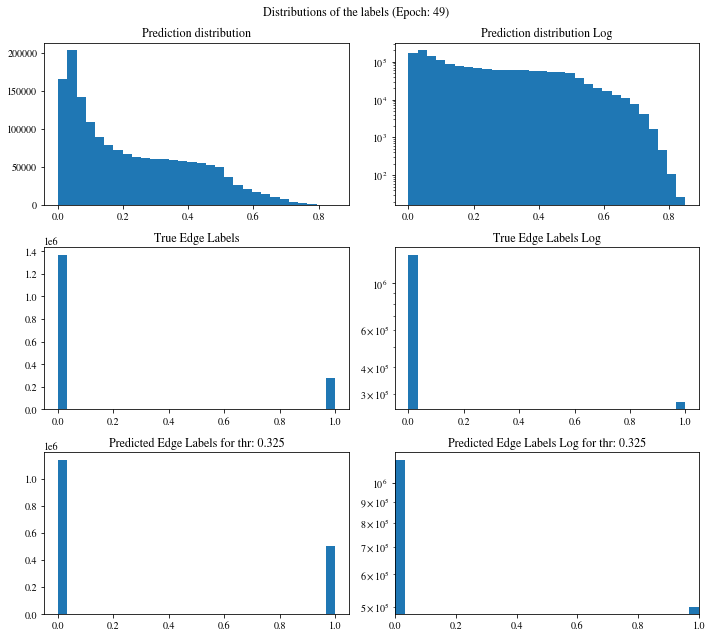

[0.52627313 0.02547125 0.19652523 ... 0.07297827 0.06238563 0.56445521]
Confusion matrix:
[[1065457  298243]
 [  71903  201841]]

Confusion matrix weighted:
[[0.39064934 0.10935066]
 [0.13133256 0.36866744]]

TN: 1065457 	 FN: 71903 	 TP: 201841 	 FP: 298243
Confusion matrix scaled:
[[0.65068302 0.18213936]
 [0.04391173 0.12326589]]

Accuracy: 0.7739
Precision: 0.4036
Negative predictive value: 0.9368
Recall: Correctly classifying 73.7335 % of positive edges
True negative rate: Correctly classifying 78.1299 % of all negative edges
F1 score: 0.5217
[0.74839633 0.77124159] [0.78129867 0.73733488] [0.76449365 0.75390719]
Balanced accuracy: 0.7593
Precision weighted: [0.74839633 0.77124159]
Recall weighted: [0.78129867 0.73733488]
F1 score weighted: [0.76449365 0.75390719]
positive_likelihood_ratio: 3.3714239022918453, negative_likelihood_ratio: 0.33619040572146336


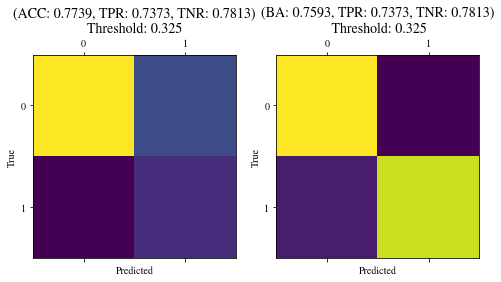

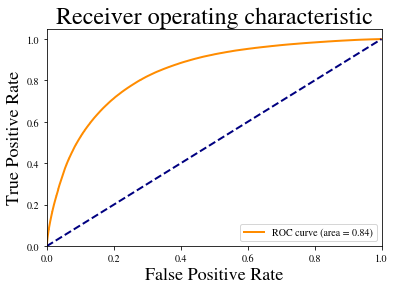

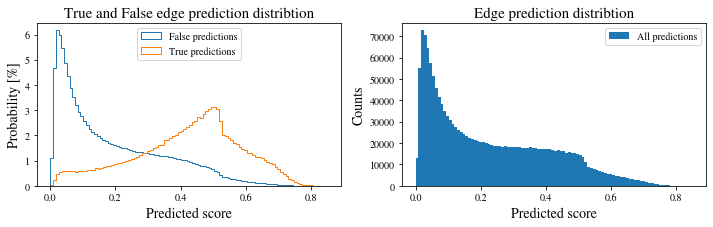

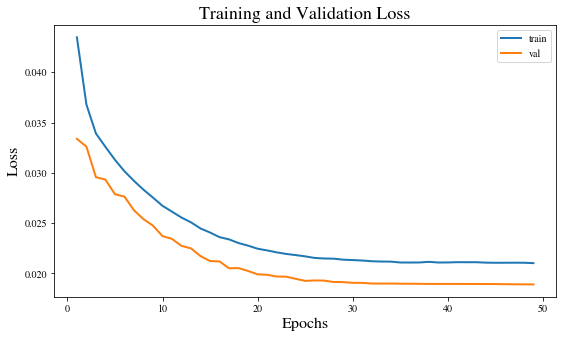

Training epoch 50: 100%|██████████| 20/20 [00:01<00:00, 17.52it/s]


Epoch: 50, train loss: 0.0210
>>> Saving model to ./model_saved/gnn_50_epochs_cosine_annealing/model_epoch_50_loss_0.0210.pt
Validation step


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


Epoch: 50, val loss: 0.0188


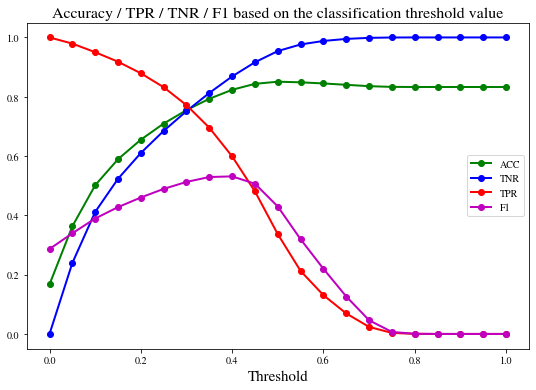

Chosen classification threshold is: 0.325
Edge labels: number of positive: 273744
Predictions: number of positive: 497857


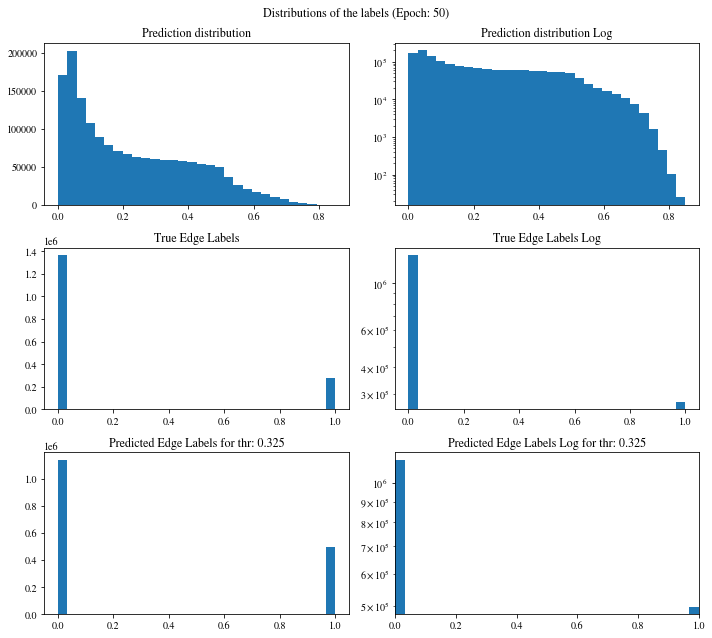

[0.5266704  0.02482948 0.19524829 ... 0.07324369 0.06219384 0.5644418 ]
Confusion matrix:
[[1067300  296400]
 [  72287  201457]]

Confusion matrix weighted:
[[0.39132507 0.10867493]
 [0.13203394 0.36796606]]

TN: 1067300 	 FN: 72287 	 TP: 201457 	 FP: 296400
Confusion matrix scaled:
[[0.65180855 0.18101382]
 [0.04414624 0.12303138]]

Accuracy: 0.7748
Precision: 0.4046
Negative predictive value: 0.9366
Recall: Correctly classifying 73.5932 % of positive edges
True negative rate: Correctly classifying 78.2650 % of all negative edges
F1 score: 0.5222
[0.74771822 0.77199836] [0.78265014 0.73593211] [0.76478551 0.75353392]
Balanced accuracy: 0.7593
Precision weighted: [0.74771822 0.77199836]
Recall weighted: [0.78265014 0.73593211]
F1 score weighted: [0.76478551 0.75353392]
positive_likelihood_ratio: 3.3859332685526136, negative_likelihood_ratio: 0.3374022104384946


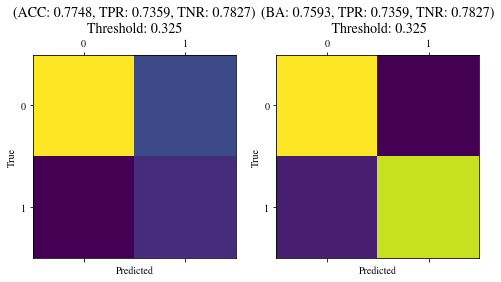

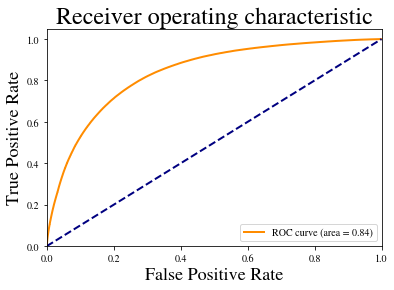

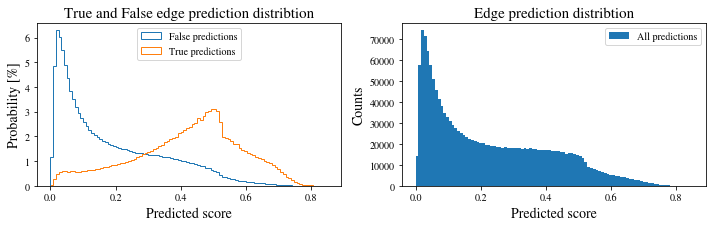

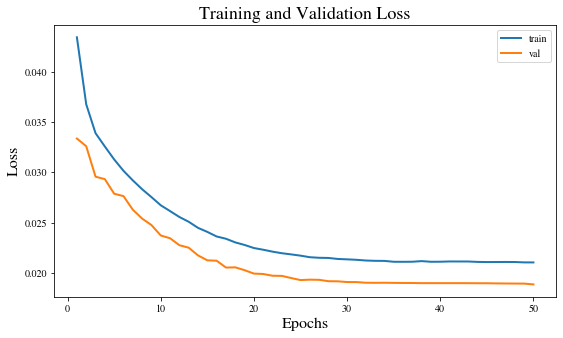

In [20]:
epochs = 50
decision_th = 0.5
outputModelPath = "./model_saved/gnn_50_epochs_cosine_annealing"
mkdir_p(outputModelPath)
train_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):

    loss = train(model, optimizer, train_dl, epoch+1, device, edge_features=True)
    train_loss_hist.append(loss)
    print(f'Epoch: {epoch+1}, train loss: {loss:.4f}')
    
    print(f">>> Saving model to {outputModelPath + f'/model_epoch_{epoch+1}_loss_{loss:.4f}.pt'}")
    torch.save({'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, outputModelPath + f'/model_epoch_{epoch+1}_loss_{loss:.4f}.pt')
    
    # Validation
    model.eval()
    pred, lab = [], []
    val_loss, j = 0, 0
    print("Validation step")
    for sample in tqdm(val_dl, desc="Validation"):
        sample = sample.to(device)
        if sample.edge_index.shape[1] != sample.edge_features.shape[0]:
            continue
        data = prepare_network_input_data(sample.x, sample.edge_index, sample.edge_features, device=device)
        #nn_pred, edge_emb = model(*data, device=device)
        nn_pred = model(*data, device=device)
        pred += nn_pred.tolist()
        lab += sample.edge_label.tolist()
        val_loss += loss_obj(nn_pred, sample.edge_label.float()).item()
        j += 1
        
    val_loss = float(val_loss)/j
    print(f'Epoch: {epoch+1}, val loss: {val_loss:.4f}')
    val_loss_hist.append(val_loss)
    
    TNR, TPR, thresholds = classification_thresholds_plot(np.array(pred), np.array(lab),
                                                          threshold_step=0.05, output_folder=outputModelPath,
                                                          epoch=epoch+1)
    classification_threshold = get_best_threshold(TNR, TPR, thresholds)
    print(f"Chosen classification threshold is: {classification_threshold}")

    plot_prediction_distribution_standard_and_log(np.array(pred), np.array(lab),
                                                  epoch=epoch+1, thr = classification_threshold,
                                                 folder=outputModelPath, val=True)

    test(np.array(lab), np.array(pred), classification_threshold=classification_threshold,
                        output_folder=outputModelPath, epoch=epoch+1)
    save_pred(np.array(pred), np.array(lab), epoch=epoch, out_folder=outputModelPath)
    save_loss(train_loss_hist, val_loss_hist, outputLossFunctionPath=outputModelPath)

    scheduler.step()     

In [18]:
import gc


t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(t, r, a, f)

print(torch.cuda.mem_get_info())
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.mem_get_info())


t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print(t, r, a, f)

15835398144 4188012544 124982272 4063030272
(11503730688, 15835398144)
(15523971072, 15835398144)
15835398144 167772160 71204352 96567808


# MLP model

In [ ]:

# import torch
# import torch.nn as nn


# def prepare_network_input_data(X, edge_index, edge_features=None, device=None):
#     X = torch.nan_to_num(X, nan=0.0)
#     if edge_features is not None:
#         edge_features = torch.nan_to_num(edge_features, nan=0.0)
#         return torch.unsqueeze(X, dim=0), torch.unsqueeze(edge_index, dim=0).float(), torch.unsqueeze(edge_features, dim=0).float()
#     return torch.unsqueeze(X, dim=0), torch.unsqueeze(edge_index, dim=0).float()
    
# class MLP_TrackLinkingNet(nn.Module):
#     def __init__(self, input_dim=33, hidden_dim=256, output_dim=1, dropout=0.2, normalize_stop=30,
#                  reconstruction_volume=(3 - 1.5)*2*47*2, both_way_edge_emb=False, edge_feature_dim=0,
#                  edge_hidden_dim=32):
#         super(MLP_TrackLinkingNet, self).__init__()
        
#         self.input_dim = input_dim
#         self.normalize_stop = normalize_stop
#         self.reconstruction_volume = reconstruction_volume
#         self.both_way_edge_emb = both_way_edge_emb
#         self.edge_feature_dim = edge_feature_dim
        
#         # Node Feature transformation to latent space
#         self.inputnetwork = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.LeakyReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.LeakyReLU()
#         )
        
#         if self.edge_feature_dim != 0:
#             # Edge feature transformation to latent space
#             self.edge_inputnetwork = nn.Sequential(
#                 nn.Linear(edge_feature_dim, edge_hidden_dim),
#                 nn.LeakyReLU(),
#                 nn.Dropout(dropout),
#                 nn.Linear(edge_hidden_dim, edge_hidden_dim),
#                 nn.LeakyReLU()
#             )
            
#         inp_dim = 2*hidden_dim + edge_hidden_dim + edge_feature_dim if self.edge_feature_dim != 0 else 2*hidden_dim
#         # Edge features from node embeddings for classification
#         self.edgenetwork = nn.Sequential(
#             nn.Linear(inp_dim, hidden_dim),
#             nn.LeakyReLU(),
#             nn.Linear(hidden_dim, hidden_dim//2),
#             nn.LeakyReLU(),
#             nn.Linear(hidden_dim//2, output_dim),
#             nn.Dropout(p=dropout),
#             nn.Sigmoid()
#         )
        
    
#     def forward(self, X, edge_index, edge_features=None, device="cuda"):
        
#         X = torch.squeeze(X, dim=0)
#         X = X[:, :self.input_dim]
#         X_norm = torch.zeros_like(X)
        
#         stop = self.normalize_stop
#         epsilon = 10e-5 * torch.ones(X[:, :stop].shape, device=device)
        
#         std = X[:, :stop].std(dim=0, unbiased=False) + epsilon
#         X_norm[:, :stop] = (X[:, :stop] - X[:, :stop].mean(dim=0)) / std
            
#         if self.input_dim > self.normalize_stop:
#             # Normalizing total number of LCs and trackster -> turning it to density
        
#             X_norm[:, stop] = X[:, stop] / (1000 * self.reconstruction_volume)
#             X_norm[:, stop+1] = X[:, stop+1] / (100 * self.reconstruction_volume)
            
#         if self.input_dim == 33:
#             # normalize across existent entries and set the rest to -1
#             valid_time_idx = X[:, -1] > -99
#             invalid_time_idx = X[:, -1] <= -99
#             valid_time_X = X[valid_time_idx]
            
#             epsilon_time = 10e-5 * torch.ones(valid_time_X[:, -1].shape, device=device)
#             std_time = valid_time_X[:, -1].std(dim=0, unbiased=False) + epsilon_time
            
#             normalized_time = (valid_time_X[:, -1] - valid_time_X[:, -1].mean(dim=0)) / std_time
            
#             X_norm[valid_time_idx, -1] = normalized_time
#             X_norm[invalid_time_idx, -1] = -10 
            
#         # Standirdize `edge_features` if present
#         if self.edge_feature_dim != 0:
#             if edge_features is not None:
#                 edge_features = torch.squeeze(edge_features, dim=0)
#                 edge_features_norm = torch.zeros_like(edge_features)
#                 epsilon = 10e-5 * torch.ones(edge_features.shape, device=device)
#                 std = edge_features.std(dim=0, unbiased=False) + epsilon
#                 edge_features_norm = (edge_features - edge_features.mean(dim=0)) / std
#                 # TODO: time normalization should be different!!!
                
#                 edge_inp_emb = self.edge_inputnetwork(edge_features_norm)
                
#             else:
#                 print("ERROR: Edge features not provided!")
#                 return 100, 100
           
            
#         # Feature transformation to latent space
#         node_emb = self.inputnetwork(X_norm)
#         src, dst = torch.squeeze(edge_index, dim=0).long()
        
        
#         if self.edge_feature_dim != 0:
#             #print(node_emb[src].shape, node_emb[dst].shape, edge_features_norm.shape)
#             edge_emb = torch.cat([node_emb[src], node_emb[dst], edge_inp_emb, edge_features_norm], dim=-1)
#         else:
#             edge_emb = torch.cat([node_emb[src], node_emb[dst]], dim=-1)
            
#         pred = self.edgenetwork(edge_emb).squeeze(-1)
        
#         if self.both_way_edge_emb:
#             edge_emb_reversed = torch.cat([node_emb[dst], node_emb[src]], dim=-1)
#             pred_reversed = self.edgenetwork(edge_emb_reversed).squeeze(-1) 
#             #pred = (pred+pred_reversed)/2
#             pred = torch.min(pred, pred_reversed)
        
#         return pred, node_emb